# Compound Classification Challenge-Part 1

This is a notebook for the challenge. For a simple demo, we will use Random Forest with the Morgan fingerprint as our feature vector.

In [8]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

In [48]:
!pip install graphviz

In [49]:
!pip install dtreeviz rdkit-pypi PyTDC

In [25]:
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision trees
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats
from tdc.single_pred import ADME
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs

In [34]:
tqdm.pandas()

In [33]:
def standardize(smiles):
    # Code borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

## Data

Let's load the compound data file.

In [35]:
cmpd_df = pd.read_csv('cmpd.csv')
cmpd_df.head()

inchikey  \
0  FNHKPVJBJVTLMP-UHFFFAOYSA-N   
1  CUDVHEFYRIWYQD-UHFFFAOYSA-N   
2  TTZSNFLLYPYKIL-UHFFFAOYSA-N   
3  UOVCGJXDGOGOCZ-UHFFFAOYSA-N   
4  CUIHSIWYWATEQL-UHFFFAOYSA-N   

                                              smiles  group activity  
0  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...  train   active  
1  CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...  train   active  
2  Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...   test   active  
3       COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2  train   active  
4  Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...   test   active

# SMILES Representation


Text(0, 0.5, 'Probability')

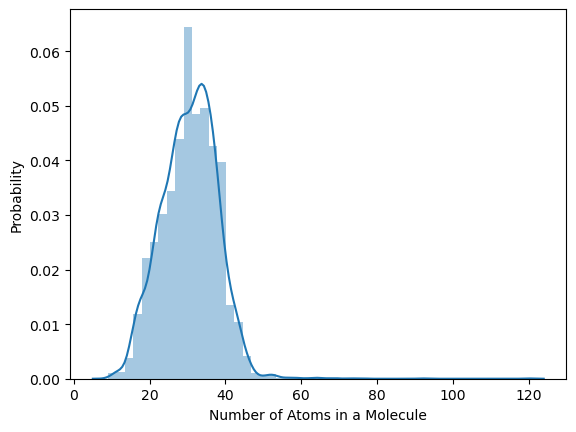

In [36]:
num_atoms=[]
large_molecule = []
large_molecule_class = []
heavy_molecule = []
heavy_molecule_class = []
for i in range(len(cmpd_df.index)):
    num_atoms.append( Chem.MolFromSmiles(cmpd_df.loc[i,'smiles']).GetNumAtoms())
    if Chem.MolFromSmiles(cmpd_df.loc[i,'smiles']).GetNumAtoms() > 60:
        large_molecule.append(cmpd_df.loc[i,'smiles'])
        large_molecule_class.append(cmpd_df.loc[i,'activity'])
    
sns.distplot(num_atoms)
plt.xlabel('Number of Atoms in a Molecule')
plt.ylabel('Probability')

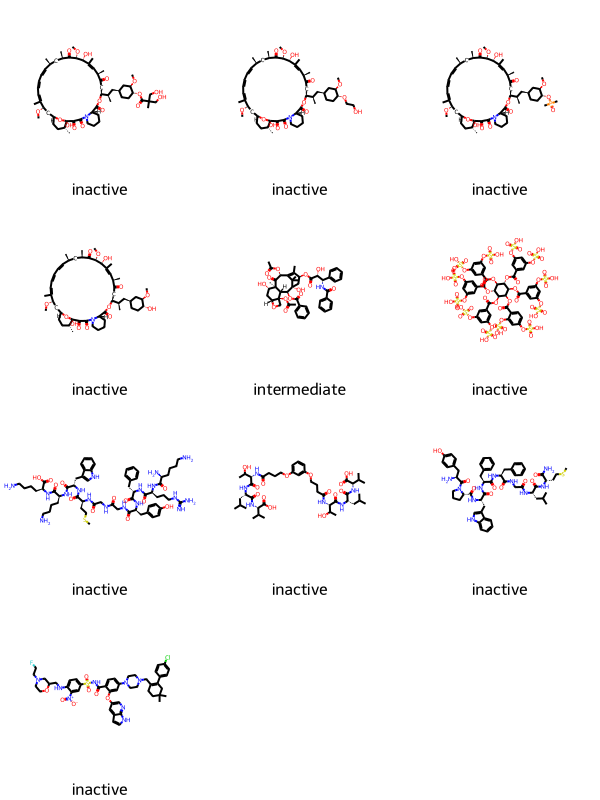

In [37]:
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in large_molecule],molsPerRow=3,legends=large_molecule_class)

# Data munging

In [38]:
cmpd_df.shape

(5530, 4)

In [39]:
block = BlockLogs()
cmpd_df['mol'] = cmpd_df.smiles.progress_apply(standardize)
del block

  0%|                                                                                         | 0/5530 [00:00<?, ?it/s][19:18:59] Initializing MetalDisconnector
[19:18:59] Running MetalDisconnector
[19:18:59] Initializing Normalizer
[19:18:59] Running Normalizer
[19:18:59] Initializing MetalDisconnector
[19:18:59] Running MetalDisconnector
[19:18:59] Initializing Normalizer
[19:18:59] Running Normalizer
[19:18:59] Running LargestFragmentChooser
[19:18:59] Fragment: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)c(F)c2)ccn1
[19:18:59] New largest fragment: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)c(F)c2)ccn1 (48)
[19:18:59] Running Uncharger
[19:18:59] Initializing MetalDisconnector
[19:18:59] Running MetalDisconnector
[19:18:59] Initializing Normalizer
[19:18:59] Running Normalizer
[19:18:59] Initializing MetalDisconnector
[19:18:59] Running MetalDisconnector
[19:18:59] Initializing Normalizer
[19:18:59] Running Normalizer
[19:18:59] Running LargestFragmentChooser
[19:18:59] 

  0%|▏                                                                               | 16/5530 [00:00<03:19, 27.58it/s][19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Running LargestFragmentChooser
[19:19:00] Fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12
[19:19:00] New largest fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12 (66)
[19:19:00] Running Uncharger
[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Running LargestFragmentChooser
[

[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Running LargestFragmentChooser
[19:19:00] Fragment: O=S(=O)(O)NC1C(O)OC(COS(=O)(=O)O)C(O)C1O
[19:19:00] New largest fragment: O=S(=O)(O)NC1C(O)OC(COS(=O)(=O)O)C(O)C1O (33)
[19:19:00] Running Uncharger
[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Initializing MetalDisconnector
[19:19:00] Running MetalDisconnector
[19:19:00] Initializing Normalizer
[19:19:00] Running Normalizer
[19:19:00] Running LargestFragmentChooser
[19:19:00] Fragment: CCN(CC)CCCCNc1ncc2cc(-c3cc(OC)cc(OC)c3)c(NC(=O)NC(C)(C)C)nc2n1
[19:19:00] New largest fragment: CCN(CC)CCCCNc1ncc2cc(-c3cc(OC)cc(OC)c3)c(NC(=O)NC(C)(

  1%|▋                                                                               | 49/5530 [00:02<03:42, 24.61it/s][19:19:01] Initializing MetalDisconnector
[19:19:01] Running MetalDisconnector
[19:19:01] Initializing Normalizer
[19:19:01] Running Normalizer
[19:19:01] Initializing MetalDisconnector
[19:19:01] Running MetalDisconnector
[19:19:01] Initializing Normalizer
[19:19:01] Running Normalizer
[19:19:01] Running LargestFragmentChooser
[19:19:01] Fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12
[19:19:01] New largest fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12 (66)
[19:19:01] Running Uncharger
[19:19:01] Initializing MetalDisconnector
[19:19:01] Running MetalDisconnector
[19:19:01] Initializing Normalizer
[19:19:01] Running Normalizer
[19:19:01] Initializing MetalDisconnector
[19:19:01] Running MetalDisconnector
[19:19:01] Initializing Normalizer
[19:19:01] Running Normalizer
[19:19:01] Running LargestFragmentChooser
[

  1%|▉                                                                               | 67/5530 [00:02<03:04, 29.69it/s][19:19:02] Initializing MetalDisconnector
[19:19:02] Running MetalDisconnector
[19:19:02] Initializing Normalizer
[19:19:02] Running Normalizer
[19:19:02] Initializing MetalDisconnector
[19:19:02] Running MetalDisconnector
[19:19:02] Initializing Normalizer
[19:19:02] Running Normalizer
[19:19:02] Running LargestFragmentChooser
[19:19:02] Fragment: COc1ccc(CCc2cc(Nc3ccnc(NCc4cc(C)no4)n3)[nH]n2)cc1OC
[19:19:02] New largest fragment: COc1ccc(CCc2cc(Nc3ccnc(NCc4cc(C)no4)n3)[nH]n2)cc1OC (57)
[19:19:02] Running Uncharger
[19:19:02] Initializing MetalDisconnector
[19:19:02] Running MetalDisconnector
[19:19:02] Initializing Normalizer
[19:19:02] Running Normalizer
[19:19:02] Initializing MetalDisconnector
[19:19:02] Running MetalDisconnector
[19:19:02] Initializing Normalizer
[19:19:02] Running Normalizer
[19:19:02] Running LargestFragmentChooser
[19:19:02] Fragment: Cc1cc(CN

  2%|█▏                                                                              | 83/5530 [00:04<07:35, 11.97it/s][19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Running LargestFragmentChooser
[19:19:04] Fragment: CCN(CC)CCCCNc1cc2nc(O)c(-c3c(Cl)cccc3Cl)cc2cn1
[19:19:04] New largest fragment: CCN(CC)CCCCNc1cc2nc(O)c(-c3c(Cl)cccc3Cl)cc2cn1 (55)
[19:19:04] Running Uncharger
[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Running LargestFragmentChooser
[19:19:04] Fragment: CCN(CC)C(=O)c1ccc(

[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Running LargestFragmentChooser
[19:19:04] Fragment: CCN(CC)CCNc1cc2c(cn1)cc(-c1c(Cl)cccc1Cl)c(=O)n2C
[19:19:04] New largest fragment: CCN(CC)CCNc1cc2c(cn1)cc(-c1c(Cl)cccc1Cl)c(=O)n2C (52)
[19:19:04] Running Uncharger
[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Initializing MetalDisconnector
[19:19:04] Running MetalDisconnector
[19:19:04] Initializing Normalizer
[19:19:04] Running Normalizer
[19:19:04] Running LargestFragmentChooser
[19:19:04] Fragment: CCN(CC)CCCCCNc1cc2c(cn1)cc(-c1c(Cl)cccc1Cl)c(=O)n2C
[19:19:04] New largest fragment: CCN(CC)CCCCCNc1cc2c(cn1)cc(-c1c(Cl)cccc1Cl)c(=O)

  2%|█▋                                                                             | 120/5530 [00:06<03:41, 24.37it/s][19:19:05] Initializing MetalDisconnector
[19:19:05] Running MetalDisconnector
[19:19:05] Initializing Normalizer
[19:19:05] Running Normalizer
[19:19:05] Initializing MetalDisconnector
[19:19:05] Running MetalDisconnector
[19:19:05] Initializing Normalizer
[19:19:05] Running Normalizer
[19:19:05] Running LargestFragmentChooser
[19:19:05] Fragment: Cc1cn(-c2cc(NC(=O)Nc3ccc(-c4nc5[nH]ncc5[nH]4)c(C)c3)cc(C(F)(F)F)c2)cn1
[19:19:05] New largest fragment: Cc1cn(-c2cc(NC(=O)Nc3ccc(-c4nc5[nH]ncc5[nH]4)c(C)c3)cc(C(F)(F)F)c2)cn1 (54)
[19:19:05] Running Uncharger
[19:19:06] Tautomer enumeration stopped at 222 tautomers: max transforms reached
[19:19:06] Initializing MetalDisconnector
[19:19:06] Running MetalDisconnector
[19:19:06] Initializing Normalizer
[19:19:06] Running Normalizer
[19:19:06] Initializing MetalDisconnector
[19:19:06] Running MetalDisconnector
[19:19:06] Initia

  2%|█▉                                                                             | 137/5530 [00:07<04:41, 19.13it/s][19:19:06] Initializing MetalDisconnector
[19:19:06] Running MetalDisconnector
[19:19:06] Initializing Normalizer
[19:19:06] Running Normalizer
[19:19:06] Initializing MetalDisconnector
[19:19:06] Running MetalDisconnector
[19:19:06] Initializing Normalizer
[19:19:06] Running Normalizer
[19:19:06] Running LargestFragmentChooser
[19:19:06] Fragment: CCn1cc(-c2ccnc3[nH]c(-c4cccc(CN(C)C)c4)cc23)c(-c2ccc(NC(=O)N(C)C)cc2)n1
[19:19:06] New largest fragment: CCn1cc(-c2ccnc3[nH]c(-c4cccc(CN(C)C)c4)cc23)c(-c2ccc(NC(=O)N(C)C)cc2)n1 (71)
[19:19:06] Running Uncharger
[19:19:06] Initializing MetalDisconnector
[19:19:06] Running MetalDisconnector
[19:19:06] Initializing Normalizer
[19:19:06] Running Normalizer
[19:19:06] Initializing MetalDisconnector
[19:19:06] Running MetalDisconnector
[19:19:06] Initializing Normalizer
[19:19:06] Running Normalizer
[19:19:06] Running LargestFragm

  3%|██▏                                                                            | 153/5530 [00:07<02:56, 30.49it/s][19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Running LargestFragmentChooser
[19:19:07] Fragment: COc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n2)c1
[19:19:07] New largest fragment: COc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n2)c1 (45)
[19:19:07] Running Uncharger
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Running LargestFragmentChooser
[19:19:07] Fragment: Cn1c(=O)

  3%|██▍                                                                            | 169/5530 [00:07<02:19, 38.38it/s][19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Running LargestFragmentChooser
[19:19:07] Fragment: O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1
[19:19:07] New largest fragment: O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1 (39)
[19:19:07] Running Uncharger
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Running LargestFragmentChooser
[19:19:07] Fragment: NC(=O)c1cc2c(Oc3ccc(Br)cc3)cncc2s1

[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Running LargestFragmentChooser
[19:19:07] Fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12
[19:19:07] New largest fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12 (66)
[19:19:07] Running Uncharger
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Initializing MetalDisconnector
[19:19:07] Running MetalDisconnector
[19:19:07] Initializing Normalizer
[19:19:07] Running Normalizer
[19:19:07] Running LargestFragmentChooser
[19:19:07] Fragment: NS(=O)(=O)c1ccc(Nc2nc(N3CCOCC3)nc3[nH]cnc23)cc1
[19:19:07] New largest fragment: NS(=O)(=O)c1ccc(Nc

  4%|██▉                                                                            | 202/5530 [00:09<05:26, 16.31it/s][19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Running LargestFragmentChooser
[19:19:09] Fragment: O=C(O)c1ccc2c(c1)nc(Nc1cccc(Cl)c1)c1ccncc12
[19:19:09] New largest fragment: O=C(O)c1ccc2c(c1)nc(Nc1cccc(Cl)c1)c1ccncc12 (37)
[19:19:09] Running Uncharger
[19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Running LargestFragmentChooser
[19:19:09] Fragment: CCNC(=O)NCc1ccccc1-c1cc(

  4%|███▏                                                                           | 219/5530 [00:09<03:09, 28.09it/s][19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Running LargestFragmentChooser
[19:19:09] Fragment: COc1cc2nc(-c3cc(F)ccc3O)nc(N[C@@H]3CNC[C@H]3C(C)(C)O)c2cc1OC
[19:19:09] New largest fragment: COc1cc2nc(-c3cc(F)ccc3O)nc(N[C@@H]3CNC[C@H]3C(C)(C)O)c2cc1OC (59)
[19:19:09] Running Uncharger
[19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Initializing MetalDisconnector
[19:19:09] Running MetalDisconnector
[19:19:09] Initializing Normalizer
[19:19:09] Running Normalizer
[19:19:09] Running LargestFragmentChooser
[19:19:09] 

  4%|███▍                                                                           | 237/5530 [00:10<02:34, 34.28it/s][19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Running LargestFragmentChooser
[19:19:10] Fragment: Cn1ccc2ncnc(Oc3ccc(NC(=O)Nc4cccnc4)c(Cl)c3)c21
[19:19:10] New largest fragment: Cn1ccc2ncnc(Oc3ccc(NC(=O)Nc4cccnc4)c(Cl)c3)c21 (43)
[19:19:10] Running Uncharger
[19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Running LargestFragmentChooser
[19:19:10] Fragment: Cn1ccc2ncnc(Oc3ccc

  5%|███▋                                                                           | 254/5530 [00:10<01:42, 51.45it/s][19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Running LargestFragmentChooser
[19:19:10] Fragment: Cn1ccc2ncnc(Oc3ccc(NC(=O)Nc4cc(CN5CCOCC5)cc(C(F)(F)F)c4)c(Cl)c3)c21
[19:19:10] New largest fragment: Cn1ccc2ncnc(Oc3ccc(NC(=O)Nc4cc(CN5CCOCC5)cc(C(F)(F)F)c4)c(Cl)c3)c21 (63)
[19:19:10] Running Uncharger
[19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Initializing MetalDisconnector
[19:19:10] Running MetalDisconnector
[19:19:10] Initializing Normalizer
[19:19:10] Running Normalizer
[19:19:10] Running LargestFragmentChoos

[19:19:11] Initializing MetalDisconnector
[19:19:11] Running MetalDisconnector
[19:19:11] Initializing Normalizer
[19:19:11] Running Normalizer
[19:19:11] Initializing MetalDisconnector
[19:19:11] Running MetalDisconnector
[19:19:11] Initializing Normalizer
[19:19:11] Running Normalizer
[19:19:11] Running LargestFragmentChooser
[19:19:11] Fragment: Nc1cc2nc(N)c(-c3c(Cl)cccc3Cl)cc2cn1
[19:19:11] New largest fragment: Nc1cc2nc(N)c(-c3c(Cl)cccc3Cl)cc2cn1 (30)
[19:19:11] Running Uncharger
[19:19:11] Initializing MetalDisconnector
[19:19:11] Running MetalDisconnector
[19:19:11] Initializing Normalizer
[19:19:11] Running Normalizer
[19:19:11] Initializing MetalDisconnector
[19:19:11] Running MetalDisconnector
[19:19:11] Initializing Normalizer
[19:19:11] Running Normalizer
[19:19:11] Running LargestFragmentChooser
[19:19:11] Fragment: CC(C)(C)NC(=O)Nc1nc2cc(N)ncc2cc1-c1c(Cl)cccc1Cl
[19:19:11] New largest fragment: CC(C)(C)NC(=O)Nc1nc2cc(N)ncc2cc1-c1c(Cl)cccc1Cl (46)
[19:19:11] Running Unchar

  5%|████▎                                                                          | 301/5530 [00:13<04:16, 20.39it/s][19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Running LargestFragmentChooser
[19:19:13] Fragment: O=C(Cc1cccs1)Nc1nc2ccccc2s1
[19:19:13] New largest fragment: O=C(Cc1cccs1)Nc1nc2ccccc2s1 (28)
[19:19:13] Running Uncharger
[19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Running LargestFragmentChooser
[19:19:13] Fragment: O=C(Nc1ccccc1)Nc1ccccn1
[19:19:13] New largest fragment:

  6%|████▌                                                                          | 318/5530 [00:14<03:46, 23.02it/s][19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Running LargestFragmentChooser
[19:19:13] Fragment: COCCOc1cc2ncnc(Nc3ccc(Cl)cc3F)c2cc1OCCOC
[19:19:13] New largest fragment: COCCOc1cc2ncnc(Nc3ccc(Cl)cc3F)c2cc1OCCOC (50)
[19:19:13] Running Uncharger
[19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Initializing MetalDisconnector
[19:19:13] Running MetalDisconnector
[19:19:13] Initializing Normalizer
[19:19:13] Running Normalizer
[19:19:13] Running LargestFragmentChooser
[19:19:13] Fragment: COc1ccc(-c2ccc3c(c2)NC(=O)/C3=

  6%|████▊                                                                          | 336/5530 [00:14<02:49, 30.59it/s][19:19:14] Initializing MetalDisconnector
[19:19:14] Running MetalDisconnector
[19:19:14] Initializing Normalizer
[19:19:14] Running Normalizer
[19:19:14] Initializing MetalDisconnector
[19:19:14] Running MetalDisconnector
[19:19:14] Initializing Normalizer
[19:19:14] Running Normalizer
[19:19:14] Running LargestFragmentChooser
[19:19:14] Fragment: O=[N+]([O-])c1cccc2c1ncn2-c1ccccc1
[19:19:14] New largest fragment: O=[N+]([O-])c1cccc2c1ncn2-c1ccccc1 (27)
[19:19:14] Running Uncharger
[19:19:14] Initializing MetalDisconnector
[19:19:14] Running MetalDisconnector
[19:19:14] Initializing Normalizer
[19:19:14] Running Normalizer
[19:19:14] Initializing MetalDisconnector
[19:19:14] Running MetalDisconnector
[19:19:14] Initializing Normalizer
[19:19:14] Running Normalizer
[19:19:14] Running LargestFragmentChooser
[19:19:14] Fragment: COc1cc2ncnc(Nc3ccccc3F)c2cc1OC
[19:19:14] 

  6%|█████                                                                          | 354/5530 [00:15<03:08, 27.52it/s][19:19:14] Initializing MetalDisconnector
[19:19:14] Running MetalDisconnector
[19:19:14] Initializing Normalizer
[19:19:14] Running Normalizer
[19:19:14] Initializing MetalDisconnector
[19:19:14] Running MetalDisconnector
[19:19:14] Initializing Normalizer
[19:19:14] Running Normalizer
[19:19:14] Running LargestFragmentChooser
[19:19:14] Fragment: Cc1ccc(-c2csc3ncnc(Nc4ccc(C(=O)O)cc4)c23)cc1
[19:19:14] New largest fragment: Cc1ccc(-c2csc3ncnc(Nc4ccc(C(=O)O)cc4)c23)cc1 (41)
[19:19:14] Running Uncharger
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Running LargestFragmentChooser
[19:19:15] Fragment: c1ccc(-n2ncc3ccccc32)c

  7%|█████▍                                                                         | 383/5530 [00:15<01:18, 65.92it/s][19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Running LargestFragmentChooser
[19:19:15] Fragment: O=C(Nc1cccc(C(F)(F)F)c1)c1ccccc1NCc1ccncc1
[19:19:15] New largest fragment: O=C(Nc1cccc(C(F)(F)F)c1)c1ccccc1NCc1ccncc1 (43)
[19:19:15] Running Uncharger
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Running LargestFragmentChooser
[19:19:15] Fragment: COC(=O)c1cccc2ncn(-c3ccccc

  7%|█████▋                                                                         | 402/5530 [00:16<01:55, 44.51it/s][19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Running LargestFragmentChooser
[19:19:15] Fragment: FC(F)(F)c1ccc(/C=C/c2nc(COc3ccc(CCCCn4ccnn4)cc3)co2)cc1
[19:19:15] New largest fragment: FC(F)(F)c1ccc(/C=C/c2nc(COc3ccc(CCCCn4ccnn4)cc3)co2)cc1 (57)
[19:19:15] Running Uncharger
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Initializing MetalDisconnector
[19:19:15] Running MetalDisconnector
[19:19:15] Initializing Normalizer
[19:19:15] Running Normalizer
[19:19:15] Running LargestFragmentChooser
[19:19:15] Fragment: 

[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Running LargestFragmentChooser
[19:19:16] Fragment: O=c1[nH]ccc2cc(OC3CCNCC3)ccc12
[19:19:16] New largest fragment: O=c1[nH]ccc2cc(OC3CCNCC3)ccc12 (34)
[19:19:16] Running Uncharger
[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Running LargestFragmentChooser
[19:19:16] Fragment: c1ccc(Cc2cn(-c3ccc4[nH]ncc4c3)nn2)cc1
[19:19:16] New largest fragment: c1ccc(Cc2cn(-c3ccc4[nH]ncc4c3)nn2)cc1 (34)
[19:19:16] Running Uncharger
  8%|██████               

[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Running LargestFragmentChooser
[19:19:16] Fragment: COc1cc2c(Nc3c(Cl)ccc4c3OCO4)ncnc2cc1OCCCN1CCCCC1
[19:19:16] New largest fragment: COc1cc2c(Nc3c(Cl)ccc4c3OCO4)ncnc2cc1OCCCN1CCCCC1 (60)
[19:19:16] Running Uncharger
[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Initializing MetalDisconnector
[19:19:16] Running MetalDisconnector
[19:19:16] Initializing Normalizer
[19:19:16] Running Normalizer
[19:19:16] Running LargestFragmentChooser
[19:19:16] Fragment: COc1cc2c(Nc3c(Cl)ccc4c3OCO4)ncnc2cc1OCC1CCN(C)CC1
[19:19:16] New largest fragment: COc1cc2c(Nc3c(Cl)ccc4c3OCO4)ncnc2cc1OCC1CCN(C)CC1 

[19:19:17] Initializing MetalDisconnector
[19:19:17] Running MetalDisconnector
[19:19:17] Initializing Normalizer
[19:19:17] Running Normalizer
[19:19:17] Initializing MetalDisconnector
[19:19:17] Running MetalDisconnector
[19:19:17] Initializing Normalizer
[19:19:17] Running Normalizer
[19:19:17] Running LargestFragmentChooser
[19:19:17] Fragment: Cc1ccc(C)c(N(C)c2ccnc(Nc3cc(N4CCOCC4)cc(N4CCOCC4)c3)n2)c1
[19:19:17] New largest fragment: Cc1ccc(C)c(N(C)c2ccnc(Nc3cc(N4CCOCC4)cc(N4CCOCC4)c3)n2)c1 (69)
[19:19:17] Running Uncharger
[19:19:17] Initializing MetalDisconnector
[19:19:17] Running MetalDisconnector
[19:19:17] Initializing Normalizer
[19:19:17] Running Normalizer
[19:19:17] Initializing MetalDisconnector
[19:19:17] Running MetalDisconnector
[19:19:17] Initializing Normalizer
[19:19:17] Running Normalizer
[19:19:17] Running LargestFragmentChooser
[19:19:17] Fragment: COc1ccc(C)c(N(C)c2ccnc(Nc3cc(N4CCOCC4)cc(N4CCOCC4)c3)n2)c1
[19:19:17] New largest fragment: COc1ccc(C)c(N(C)c2ccnc(

  8%|██████▋                                                                        | 469/5530 [00:18<03:31, 23.89it/s][19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: Cc1cc(-c2cccc(N)c2)c(/C=C2\C(=O)Nc3ccccc32)[nH]1
[19:19:18] New largest fragment: Cc1cc(-c2cccc(N)c2)c(/C=C2\C(=O)Nc3ccccc32)[nH]1 (41)
[19:19:18] Running Uncharger
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: O=C(c1ccco1)N1

  9%|███████                                                                        | 494/5530 [00:18<01:36, 52.34it/s][19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: CCOC(=O)C1=C2C(=NC1=O)c1cccc3c(SCCN4CCSC4)ccc2c13
[19:19:18] New largest fragment: CCOC(=O)C1=C2C(=NC1=O)c1cccc3c(SCCN4CCSC4)ccc2c13 (49)
[19:19:18] Running Uncharger
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: C=CCOC(=O)C1

  9%|███████▍                                                                       | 517/5530 [00:19<01:30, 55.57it/s][19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: NS(=O)(=O)c1ccc(NC=C2C(=O)Nc3ccc4ncsc4c32)cc1
[19:19:18] New largest fragment: NS(=O)(=O)c1ccc(NC=C2C(=O)Nc3ccc4ncsc4c32)cc1 (37)
[19:19:18] Running Uncharger
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: O=C1Nc2ccccc2/C1=C/N

[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmentChooser
[19:19:18] Fragment: CN(C)CCOc1ccc(-c2cc(-c3ccc4c(c3)CCC4=NO)c(-c3ccncc3)o2)cc1
[19:19:18] New largest fragment: CN(C)CCOc1ccc(-c2cc(-c3ccc4c(c3)CCC4=NO)c(-c3ccncc3)o2)cc1 (61)
[19:19:18] Fragment: Cl
[19:19:18] Running Uncharger
 10%|███████▋                                                                       | 534/5530 [00:19<01:21, 61.52it/s][19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Initializing MetalDisconnector
[19:19:18] Running MetalDisconnector
[19:19:18] Initializing Normalizer
[19:19:18] Running Normalizer
[19:19:18] Running LargestFragmen

 10%|███████▊                                                                       | 549/5530 [00:19<01:26, 57.81it/s][19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Running LargestFragmentChooser
[19:19:19] Fragment: CC(=O)Nc1ccc(-c2cc3ncnc(SCC(=O)O)c3s2)cc1
[19:19:19] New largest fragment: CC(=O)Nc1ccc(-c2cc3ncnc(SCC(=O)O)c3s2)cc1 (37)
[19:19:19] Running Uncharger
[19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Running LargestFragmentChooser
[19:19:19] Fragment: Cc1cccc(NC(=O)Nc2ccc(-c3cccc

 10%|████████                                                                       | 565/5530 [00:20<01:36, 51.24it/s][19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Running LargestFragmentChooser
[19:19:19] Fragment: Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21
[19:19:19] New largest fragment: Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21 (59)
[19:19:19] Running Uncharger
[19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Initializing MetalDisconnector
[19:19:19] Running MetalDisconnector
[19:19:19] Initializing Normalizer
[19:19:19] Running Normalizer
[19:19:19] Running LargestFragmentChooser
[19

 11%|████████▎                                                                      | 584/5530 [00:20<01:40, 49.30it/s][19:19:20] Initializing MetalDisconnector
[19:19:20] Running MetalDisconnector
[19:19:20] Initializing Normalizer
[19:19:20] Running Normalizer
[19:19:20] Initializing MetalDisconnector
[19:19:20] Running MetalDisconnector
[19:19:20] Initializing Normalizer
[19:19:20] Running Normalizer
[19:19:20] Running LargestFragmentChooser
[19:19:20] Fragment: COc1cc(OC)cc(-c2cc3cnc(NCCCN4CCN(C)CC4)nc3nc2NC(=O)NC(C)(C)C)c1
[19:19:20] New largest fragment: COc1cc(OC)cc(-c2cc3cnc(NCCCN4CCN(C)CC4)nc3nc2NC(=O)NC(C)(C)C)c1 (79)
[19:19:20] Running Uncharger
[19:19:20] Initializing MetalDisconnector
[19:19:20] Running MetalDisconnector
[19:19:20] Initializing Normalizer
[19:19:20] Running Normalizer
[19:19:20] Initializing MetalDisconnector
[19:19:20] Running MetalDisconnector
[19:19:20] Initializing Normalizer
[19:19:20] Running Normalizer
[19:19:20] Running LargestFragmentChooser
[19:1

 11%|████████▌                                                                      | 599/5530 [00:22<06:08, 13.37it/s][19:19:21] Initializing MetalDisconnector
[19:19:21] Running MetalDisconnector
[19:19:21] Initializing Normalizer
[19:19:21] Running Normalizer
[19:19:21] Initializing MetalDisconnector
[19:19:21] Running MetalDisconnector
[19:19:21] Initializing Normalizer
[19:19:21] Running Normalizer
[19:19:21] Running LargestFragmentChooser
[19:19:21] Fragment: COc1cc(OC)cc(-c2cc3cnc(NCCCN4CCN(C)CC4)cc3nc2NC(=O)NC(C)(C)C)c1
[19:19:21] New largest fragment: COc1cc(OC)cc(-c2cc3cnc(NCCCN4CCN(C)CC4)cc3nc2NC(=O)NC(C)(C)C)c1 (80)
[19:19:21] Running Uncharger
[19:19:21] Initializing MetalDisconnector
[19:19:21] Running MetalDisconnector
[19:19:21] Initializing Normalizer
[19:19:21] Running Normalizer
[19:19:21] Initializing MetalDisconnector
[19:19:21] Running MetalDisconnector
[19:19:21] Initializing Normalizer
[19:19:21] Running Normalizer
[19:19:21] Running LargestFragmentChooser
[19:1

 11%|████████▊                                                                      | 614/5530 [00:23<05:35, 14.64it/s][19:19:22] Initializing MetalDisconnector
[19:19:22] Running MetalDisconnector
[19:19:22] Initializing Normalizer
[19:19:22] Running Normalizer
[19:19:22] Initializing MetalDisconnector
[19:19:22] Running MetalDisconnector
[19:19:22] Initializing Normalizer
[19:19:22] Running Normalizer
[19:19:22] Running LargestFragmentChooser
[19:19:22] Fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-c2cccnc2)cs1
[19:19:22] New largest fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-c2cccnc2)cs1 (66)
[19:19:22] Running Uncharger
[19:19:22] Initializing MetalDisconnector
[19:19:22] Running MetalDisconnector
[19:19:22] Initializing Normalizer
[19:19:22] Running Normalizer
[19:19:22] Initializing MetalDisconnector
[19:19:22] Running MetalDisconnector
[19:19:22] Initializing Normalizer
[19:19:22] Running Normalizer
[19:19:22] Running LargestFragmentChooser
[19:19:22] Frag

 12%|█████████▏                                                                     | 643/5530 [00:24<04:29, 18.16it/s][19:19:24] Initializing MetalDisconnector
[19:19:24] Running MetalDisconnector
[19:19:24] Initializing Normalizer
[19:19:24] Running Normalizer
[19:19:24] Initializing MetalDisconnector
[19:19:24] Running MetalDisconnector
[19:19:24] Initializing Normalizer
[19:19:24] Running Normalizer
[19:19:24] Running LargestFragmentChooser
[19:19:24] Fragment: COC(=O)Nc1nc2ccc(Sc3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)cc3)cc2[nH]1
[19:19:24] New largest fragment: COC(=O)Nc1nc2ccc(Sc3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)cc3)cc2[nH]1 (53)
[19:19:24] Fragment: O=S(=O)(O)O
[19:19:24] Running Uncharger
[19:19:24] Initializing MetalDisconnector
[19:19:24] Running MetalDisconnector
[19:19:24] Initializing Normalizer
[19:19:24] Running Normalizer
[19:19:24] Initializing MetalDisconnector
[19:19:24] Running MetalDisconnector
[19:19:24] Initializing Normalizer
[19:19:24] Running Normalizer
[19:19:24] Run

 12%|█████████▍                                                                     | 660/5530 [00:25<05:03, 16.02it/s][19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Running LargestFragmentChooser
[19:19:25] Fragment: Cl
[19:19:25] New largest fragment: Cl (2)
[19:19:25] Fragment: NC(=O)c1cccc(Nc2nccc(Nc3cccc(F)c3)n2)c1
[19:19:25] New largest fragment: NC(=O)c1cccc(Nc2nccc(Nc3cccc(F)c3)n2)c1 (38)
[19:19:25] Running Uncharger
[19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Running LargestFragm

 12%|█████████▋                                                                     | 674/5530 [00:26<02:40, 30.18it/s][19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Running LargestFragmentChooser
[19:19:25] Fragment: COc1ccc(-c2oc3ncnc(N)c3c2-c2ccc(NC(=O)Nc3cc(C(F)(F)F)ccc3F)cc2)cc1
[19:19:25] New largest fragment: COc1ccc(-c2oc3ncnc(N)c3c2-c2ccc(NC(=O)Nc3cc(C(F)(F)F)ccc3F)cc2)cc1 (58)
[19:19:25] Fragment: Cl
[19:19:25] Running Uncharger
[19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Initializing MetalDisconnector
[19:19:25] Running MetalDisconnector
[19:19:25] Initializing Normalizer
[19:19:25] Running Normalizer
[19:19:25] Runnin

 13%|█████████▉                                                                     | 692/5530 [00:26<02:03, 39.18it/s][19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Running LargestFragmentChooser
[19:19:26] Fragment: Cl
[19:19:26] New largest fragment: Cl (2)
[19:19:26] Fragment: O
[19:19:26] New largest fragment: O (3)
[19:19:26] Fragment: CN(C)CCOc1ccc(-c2nc(-c3ccncc3)c(-c3ccc4c(c3)CC/C4=N\O)[nH]2)cc1
[19:19:26] New largest fragment: CN(C)CCOc1ccc(-c2nc(-c3ccncc3)c(-c3ccc4c(c3)CC/C4=N\O)[nH]2)cc1 (61)
[19:19:26] Running Uncharger
[19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Initializing MetalDisconnector
[19:19:26] Running Meta

[19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Running LargestFragmentChooser
[19:19:26] Fragment: CONC(=O)c1cc(Nc2ncnn3cc(-c4nnc(CC(C)C)o4)c(C(C)C)c23)c(F)cc1F
[19:19:26] New largest fragment: CONC(=O)c1cc(Nc2ncnn3cc(-c4nnc(CC(C)C)o4)c(C(C)C)c23)c(F)cc1F (60)
[19:19:26] Running Uncharger
[19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Initializing MetalDisconnector
[19:19:26] Running MetalDisconnector
[19:19:26] Initializing Normalizer
[19:19:26] Running Normalizer
[19:19:26] Running LargestFragmentChooser
[19:19:26] Fragment: Cc1c(CN2CCN(C(=O)[C@H](C)O)CC2)sc2c(N3CCOCC3)nc(-c3cnc(N)nc3)nc12
[19:19:26] New largest fragment: Cc1c(CN2

 13%|██████████▍                                                                    | 728/5530 [00:27<02:12, 36.28it/s][19:19:27] Initializing MetalDisconnector
[19:19:27] Running MetalDisconnector
[19:19:27] Initializing Normalizer
[19:19:27] Running Normalizer
[19:19:27] Initializing MetalDisconnector
[19:19:27] Running MetalDisconnector
[19:19:27] Initializing Normalizer
[19:19:27] Running Normalizer
[19:19:27] Running LargestFragmentChooser
[19:19:27] Fragment: CCC(=O)Oc1cccc(-c2nc(N3CCOCC3)c3cc4ncccc4n3n2)c1
[19:19:27] New largest fragment: CCC(=O)Oc1cccc(-c2nc(N3CCOCC3)c3cc4ncccc4n3n2)c1 (51)
[19:19:27] Running Uncharger
[19:19:27] Initializing MetalDisconnector
[19:19:27] Running MetalDisconnector
[19:19:27] Initializing Normalizer
[19:19:27] Running Normalizer
[19:19:27] Initializing MetalDisconnector
[19:19:27] Running MetalDisconnector
[19:19:27] Initializing Normalizer
[19:19:27] Running Normalizer
[19:19:27] Running LargestFragmentChooser
[19:19:27] Fragment: CCCC(=O)Oc1ccc

 13%|██████████▋                                                                    | 745/5530 [00:30<10:32,  7.57it/s][19:19:30] Initializing MetalDisconnector
[19:19:30] Running MetalDisconnector
[19:19:30] Initializing Normalizer
[19:19:30] Running Normalizer
[19:19:30] Initializing MetalDisconnector
[19:19:30] Running MetalDisconnector
[19:19:30] Initializing Normalizer
[19:19:30] Running Normalizer
[19:19:30] Running LargestFragmentChooser
[19:19:30] Fragment: CC(=O)OC[C@H]1O[C@@H](NC(=O)CCCn2[se]c3ccccc3c2=O)[C@H](OC(C)=O)[C@@H](OC(C)=O)[C@@H]1OC(C)=O
[19:19:30] New largest fragment: CC(=O)OC[C@H]1O[C@@H](NC(=O)CCCn2[se]c3ccccc3c2=O)[C@H](OC(C)=O)[C@@H](OC(C)=O)[C@@H]1OC(C)=O (69)
[19:19:30] Running Uncharger
[19:19:30] Initializing MetalDisconnector
[19:19:30] Running MetalDisconnector
[19:19:30] Initializing Normalizer
[19:19:30] Running Normalizer
[19:19:30] Initializing MetalDisconnector
[19:19:30] Running MetalDisconnector
[19:19:30] Initializing Normalizer
[19:19:30] Runnin

 14%|███████████                                                                    | 777/5530 [00:32<02:57, 26.84it/s][19:19:31] Initializing MetalDisconnector
[19:19:31] Running MetalDisconnector
[19:19:31] Initializing Normalizer
[19:19:31] Running Normalizer
[19:19:31] Initializing MetalDisconnector
[19:19:31] Running MetalDisconnector
[19:19:31] Initializing Normalizer
[19:19:31] Running Normalizer
[19:19:31] Running LargestFragmentChooser
[19:19:31] Fragment: O=c1cc(-c2ccncc2)nc(NC2CCCCC2)[nH]1
[19:19:31] New largest fragment: O=c1cc(-c2ccncc2)nc(NC2CCCCC2)[nH]1 (38)
[19:19:31] Running Uncharger
[19:19:31] Initializing MetalDisconnector
[19:19:31] Running MetalDisconnector
[19:19:31] Initializing Normalizer
[19:19:31] Running Normalizer
[19:19:31] Initializing MetalDisconnector
[19:19:31] Running MetalDisconnector
[19:19:31] Initializing Normalizer
[19:19:31] Running Normalizer
[19:19:31] Running LargestFragmentChooser
[19:19:31] Fragment: CONC(=O)c1cc(Nc2ncnn3cc(-c4nnc(N(C)C)o4)

 14%|███████████▎                                                                   | 795/5530 [00:32<03:10, 24.81it/s][19:19:32] Initializing MetalDisconnector
[19:19:32] Running MetalDisconnector
[19:19:32] Initializing Normalizer
[19:19:32] Running Normalizer
[19:19:32] Initializing MetalDisconnector
[19:19:32] Running MetalDisconnector
[19:19:32] Initializing Normalizer
[19:19:32] Running Normalizer
[19:19:32] Running LargestFragmentChooser
[19:19:32] Fragment: O=C(NC(CO)c1ccccc1)N1CC=C(c2c[nH]c3ncccc23)CC1
[19:19:32] New largest fragment: O=C(NC(CO)c1ccccc1)N1CC=C(c2c[nH]c3ncccc23)CC1 (49)
[19:19:32] Running Uncharger
[19:19:32] Initializing MetalDisconnector
[19:19:32] Running MetalDisconnector
[19:19:32] Initializing Normalizer
[19:19:32] Running Normalizer
[19:19:32] Initializing MetalDisconnector
[19:19:32] Running MetalDisconnector
[19:19:32] Initializing Normalizer
[19:19:32] Running Normalizer
[19:19:32] Running LargestFragmentChooser
[19:19:32] Fragment: CN(C)CCCN(C)C(=O)c

 15%|███████████▌                                                                   | 813/5530 [00:33<03:27, 22.72it/s][19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Running LargestFragmentChooser
[19:19:33] Fragment: Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(C#CCN)cnc(N)c34)cc2)c1
[19:19:33] New largest fragment: Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(C#CCN)cnc(N)c34)cc2)c1 (52)
[19:19:33] Running Uncharger
[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Running LargestFragmentChooser
[19:19:33] Fragment: CC(Nc1

[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Running LargestFragmentChooser
[19:19:33] Fragment: O=C(NCc1ccc(Cl)cc1)c1cc2c(-c3ccccc3)n[nH]c2s1
[19:19:33] New largest fragment: O=C(NCc1ccc(Cl)cc1)c1cc2c(-c3ccccc3)n[nH]c2s1 (39)
[19:19:33] Running Uncharger
[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Initializing MetalDisconnector
[19:19:33] Running MetalDisconnector
[19:19:33] Initializing Normalizer
[19:19:33] Running Normalizer
[19:19:33] Running LargestFragmentChooser
[19:19:33] Fragment: Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(C)c5)cnc(N)c34)cc2)c1
[19:19:33] New largest fragment: Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(C)c5)cnc(N

[19:19:34] Initializing MetalDisconnector
[19:19:34] Running MetalDisconnector
[19:19:34] Initializing Normalizer
[19:19:34] Running Normalizer
[19:19:34] Running LargestFragmentChooser
[19:19:34] Fragment: NC(=O)c1cccc2c1Nc1nnc(Cl)cc1C(=O)N2
[19:19:34] New largest fragment: NC(=O)c1cccc2c1Nc1nnc(Cl)cc1C(=O)N2 (28)
[19:19:34] Running Uncharger
[19:19:34] Initializing MetalDisconnector
[19:19:34] Running MetalDisconnector
[19:19:34] Initializing Normalizer
[19:19:34] Running Normalizer
[19:19:34] Initializing MetalDisconnector
[19:19:34] Running MetalDisconnector
[19:19:34] Initializing Normalizer
[19:19:34] Running Normalizer
[19:19:34] Running LargestFragmentChooser
[19:19:34] Fragment: CN(C)CC(C)(C)CNc1nccc(-c2c(-c3ccc(F)cc3)nc3occn23)n1
[19:19:34] New largest fragment: CN(C)CC(C)(C)CNc1nccc(-c2c(-c3ccc(F)cc3)nc3occn23)n1 (55)
[19:19:34] Running Uncharger
 15%|████████████                                                                   | 847/5530 [00:34<02:48, 27.84it/s][19:19:34] 

 16%|████████████▎                                                                  | 865/5530 [00:35<03:42, 21.01it/s][19:19:35] Initializing MetalDisconnector
[19:19:35] Running MetalDisconnector
[19:19:35] Initializing Normalizer
[19:19:35] Running Normalizer
[19:19:35] Initializing MetalDisconnector
[19:19:35] Running MetalDisconnector
[19:19:35] Initializing Normalizer
[19:19:35] Running Normalizer
[19:19:35] Running LargestFragmentChooser
[19:19:35] Fragment: CC(C)(C)NC(=O)c1ccc2nc3[nH]c4ccccc4c3nc2c1
[19:19:35] New largest fragment: CC(C)(C)NC(=O)c1ccc2nc3[nH]c4ccccc4c3nc2c1 (42)
[19:19:35] Running Uncharger
[19:19:35] Initializing MetalDisconnector
[19:19:35] Running MetalDisconnector
[19:19:35] Initializing Normalizer
[19:19:35] Running Normalizer
[19:19:35] Initializing MetalDisconnector
[19:19:35] Running MetalDisconnector
[19:19:35] Initializing Normalizer
[19:19:35] Running Normalizer
[19:19:35] Running LargestFragmentChooser
[19:19:35] Fragment: CCCCn1c(NC(=O)c2cccc(C#N)c

 16%|████████████▊                                                                  | 895/5530 [00:36<02:23, 32.38it/s][19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Running LargestFragmentChooser
[19:19:36] Fragment: O=C(NCc1ccc(Br)cc1)Nc1ccc2[nH]ncc2c1
[19:19:36] New largest fragment: O=C(NCc1ccc(Br)cc1)Nc1ccc2[nH]ncc2c1 (34)
[19:19:36] Running Uncharger
[19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Running LargestFragmentChooser
[19:19:36] Fragment: CCCOc1nc(NC(C)=O)cc(N)c1C#N
[19:19:36]

 16%|█████████████                                                                  | 911/5530 [00:37<02:13, 34.70it/s][19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Running LargestFragmentChooser
[19:19:36] Fragment: CN1CCN(c2cccc(Nc3nccc(-c4c(C(N)=O)nc5ccccn45)n3)c2)CC1
[19:19:36] New largest fragment: CN1CCN(c2cccc(Nc3nccc(-c4c(C(N)=O)nc5ccccn45)n3)c2)CC1 (56)
[19:19:36] Running Uncharger
[19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Initializing MetalDisconnector
[19:19:36] Running MetalDisconnector
[19:19:36] Initializing Normalizer
[19:19:36] Running Normalizer
[19:19:36] Running LargestFragmentChooser
[19:19:36] Fragment: CC

 17%|█████████████▎                                                                 | 928/5530 [00:37<01:53, 40.53it/s][19:19:37] Initializing MetalDisconnector
[19:19:37] Running MetalDisconnector
[19:19:37] Initializing Normalizer
[19:19:37] Running Normalizer
[19:19:37] Initializing MetalDisconnector
[19:19:37] Running MetalDisconnector
[19:19:37] Initializing Normalizer
[19:19:37] Running Normalizer
[19:19:37] Running LargestFragmentChooser
[19:19:37] Fragment: CCCS(=O)(=O)Nc1ccc(-c2ccc3[nH]nc(NC(=O)CC)c3c2)cc1
[19:19:37] New largest fragment: CCCS(=O)(=O)Nc1ccc(-c2ccc3[nH]nc(NC(=O)CC)c3c2)cc1 (49)
[19:19:37] Running Uncharger
[19:19:37] Initializing MetalDisconnector
[19:19:37] Running MetalDisconnector
[19:19:37] Initializing Normalizer
[19:19:37] Running Normalizer
[19:19:37] Initializing MetalDisconnector
[19:19:37] Running MetalDisconnector
[19:19:37] Initializing Normalizer
[19:19:37] Running Normalizer
[19:19:37] Running LargestFragmentChooser
[19:19:37] Fragment: C#Cc1cc2c(

[19:19:38] Initializing MetalDisconnector
[19:19:38] Running MetalDisconnector
[19:19:38] Initializing Normalizer
[19:19:38] Running Normalizer
[19:19:38] Initializing MetalDisconnector
[19:19:38] Running MetalDisconnector
[19:19:38] Initializing Normalizer
[19:19:38] Running Normalizer
[19:19:38] Running LargestFragmentChooser
[19:19:38] Fragment: CC(C)(CO)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4occn34)nn12
[19:19:38] New largest fragment: CC(C)(CO)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4occn34)nn12 (46)
[19:19:38] Running Uncharger
 17%|█████████████▌                                                                 | 945/5530 [00:39<05:30, 13.88it/s][19:19:38] Initializing MetalDisconnector
[19:19:38] Running MetalDisconnector
[19:19:38] Initializing Normalizer
[19:19:38] Running Normalizer
[19:19:38] Initializing MetalDisconnector
[19:19:38] Running MetalDisconnector
[19:19:38] Initializing Normalizer
[19:19:38] Running Normalizer
[19:19:38] Running LargestFragmentChooser
[19:19:38] Fragment: Nc1ncn

 17%|█████████████▋                                                                 | 962/5530 [00:39<03:35, 21.22it/s][19:19:39] Initializing MetalDisconnector
[19:19:39] Running MetalDisconnector
[19:19:39] Initializing Normalizer
[19:19:39] Running Normalizer
[19:19:39] Initializing MetalDisconnector
[19:19:39] Running MetalDisconnector
[19:19:39] Initializing Normalizer
[19:19:39] Running Normalizer
[19:19:39] Running LargestFragmentChooser
[19:19:39] Fragment: O=S(=O)(Nc1ccc2c(c1)C(=NO)c1ccccc1-2)c1cccc(Br)c1
[19:19:39] New largest fragment: O=S(=O)(Nc1ccc2c(c1)C(=NO)c1ccccc1-2)c1cccc(Br)c1 (39)
[19:19:39] Running Uncharger
[19:19:39] Initializing MetalDisconnector
[19:19:39] Running MetalDisconnector
[19:19:39] Initializing Normalizer
[19:19:39] Running Normalizer
[19:19:39] Initializing MetalDisconnector
[19:19:39] Running MetalDisconnector
[19:19:39] Initializing Normalizer
[19:19:39] Running Normalizer
[19:19:39] Running LargestFragmentChooser
[19:19:39] Fragment: O=C(Nc1ccc2[

 18%|██████████████                                                                 | 981/5530 [00:40<03:58, 19.04it/s][19:19:40] Initializing MetalDisconnector
[19:19:40] Running MetalDisconnector
[19:19:40] Initializing Normalizer
[19:19:40] Running Normalizer
[19:19:40] Initializing MetalDisconnector
[19:19:40] Running MetalDisconnector
[19:19:40] Initializing Normalizer
[19:19:40] Running Normalizer
[19:19:40] Running LargestFragmentChooser
[19:19:40] Fragment: Cc1n[nH]c2ccc(-c3cncc(OCC(N)Cc4cccc(Cl)c4)c3)cc12
[19:19:40] New largest fragment: Cc1n[nH]c2ccc(-c3cncc(OCC(N)Cc4cccc(Cl)c4)c3)cc12 (49)
[19:19:40] Running Uncharger
[19:19:40] Initializing MetalDisconnector
[19:19:40] Running MetalDisconnector
[19:19:40] Initializing Normalizer
[19:19:40] Running Normalizer
[19:19:40] Initializing MetalDisconnector
[19:19:40] Running MetalDisconnector
[19:19:40] Initializing Normalizer
[19:19:40] Running Normalizer
[19:19:40] Running LargestFragmentChooser
[19:19:40] Fragment: O=C(O)c1csc2

 18%|██████████████                                                                | 1000/5530 [00:42<04:23, 17.21it/s][19:19:41] Initializing MetalDisconnector
[19:19:41] Running MetalDisconnector
[19:19:41] Initializing Normalizer
[19:19:41] Running Normalizer
[19:19:41] Initializing MetalDisconnector
[19:19:41] Running MetalDisconnector
[19:19:41] Initializing Normalizer
[19:19:41] Running Normalizer
[19:19:41] Running LargestFragmentChooser
[19:19:41] Fragment: O=c1[nH]c2cc(Br)cnc2[nH]1
[19:19:41] New largest fragment: O=c1[nH]c2cc(Br)cnc2[nH]1 (15)
[19:19:41] Running Uncharger
[19:19:41] Initializing MetalDisconnector
[19:19:41] Running MetalDisconnector
[19:19:41] Initializing Normalizer
[19:19:41] Running Normalizer
[19:19:41] Initializing MetalDisconnector
[19:19:41] Running MetalDisconnector
[19:19:41] Initializing Normalizer
[19:19:41] Running Normalizer
[19:19:41] Running LargestFragmentChooser
[19:19:41] Fragment: CC(CCC(=O)O)(c1ccc(O)c(N)c1)c1ccc(O)c(N)c1
[19:19:41] New la

 18%|██████████████▎                                                               | 1018/5530 [00:43<05:51, 12.85it/s][19:19:42] Initializing MetalDisconnector
[19:19:42] Running MetalDisconnector
[19:19:42] Initializing Normalizer
[19:19:42] Running Normalizer
[19:19:42] Initializing MetalDisconnector
[19:19:42] Running MetalDisconnector
[19:19:42] Initializing Normalizer
[19:19:42] Running Normalizer
[19:19:42] Running LargestFragmentChooser
[19:19:42] Fragment: O=C(NCc1ccccc1)c1ccc(-c2ccncc2)cc1
[19:19:42] New largest fragment: O=C(NCc1ccccc1)c1ccc(-c2ccncc2)cc1 (38)
[19:19:42] Running Uncharger
[19:19:42] Initializing MetalDisconnector
[19:19:42] Running MetalDisconnector
[19:19:42] Initializing Normalizer
[19:19:42] Running Normalizer
[19:19:42] Initializing MetalDisconnector
[19:19:42] Running MetalDisconnector
[19:19:42] Initializing Normalizer
[19:19:42] Running Normalizer
[19:19:42] Running LargestFragmentChooser
[19:19:42] Fragment: CC(Nc1cncc(-n2cnc3ccc(C#N)cc32)n1)c1ccccc1

 19%|██████████████▌                                                               | 1035/5530 [00:44<04:14, 17.68it/s][19:19:43] Initializing MetalDisconnector
[19:19:43] Running MetalDisconnector
[19:19:43] Initializing Normalizer
[19:19:43] Running Normalizer
[19:19:43] Initializing MetalDisconnector
[19:19:43] Running MetalDisconnector
[19:19:43] Initializing Normalizer
[19:19:43] Running Normalizer
[19:19:43] Running LargestFragmentChooser
[19:19:43] Fragment: Cc1nccn2c(-c3ccnc(NCCC(C)(C)O)n3)c(-c3ccc(F)cc3F)nc12
[19:19:43] New largest fragment: Cc1nccn2c(-c3ccnc(NCCC(C)(C)O)n3)c(-c3ccc(F)cc3F)nc12 (53)
[19:19:43] Running Uncharger
[19:19:43] Initializing MetalDisconnector
[19:19:43] Running MetalDisconnector
[19:19:43] Initializing Normalizer
[19:19:43] Running Normalizer
[19:19:43] Initializing MetalDisconnector
[19:19:43] Running MetalDisconnector
[19:19:43] Initializing Normalizer
[19:19:43] Running Normalizer
[19:19:43] Running LargestFragmentChooser
[19:19:43] Fragment: CN(C

 19%|██████████████▊                                                               | 1051/5530 [00:44<03:27, 21.55it/s][19:19:44] Initializing MetalDisconnector
[19:19:44] Running MetalDisconnector
[19:19:44] Initializing Normalizer
[19:19:44] Running Normalizer
[19:19:44] Initializing MetalDisconnector
[19:19:44] Running MetalDisconnector
[19:19:44] Initializing Normalizer
[19:19:44] Running Normalizer
[19:19:44] Running LargestFragmentChooser
[19:19:44] Fragment: CN1CCN(c2ccc(Nc3ncc(Cl)c(Nc4ccc5[nH]ncc5c4)n3)cc2)CC1
[19:19:44] New largest fragment: CN1CCN(c2ccc(Nc3ncc(Cl)c(Nc4ccc5[nH]ncc5c4)n3)cc2)CC1 (54)
[19:19:44] Running Uncharger
[19:19:44] Initializing MetalDisconnector
[19:19:44] Running MetalDisconnector
[19:19:44] Initializing Normalizer
[19:19:44] Running Normalizer
[19:19:44] Initializing MetalDisconnector
[19:19:44] Running MetalDisconnector
[19:19:44] Initializing Normalizer
[19:19:44] Running Normalizer
[19:19:44] Running LargestFragmentChooser
[19:19:44] Fragment: Cc1c

 19%|███████████████                                                               | 1069/5530 [00:45<02:35, 28.72it/s][19:19:45] Initializing MetalDisconnector
[19:19:45] Running MetalDisconnector
[19:19:45] Initializing Normalizer
[19:19:45] Running Normalizer
[19:19:45] Initializing MetalDisconnector
[19:19:45] Running MetalDisconnector
[19:19:45] Initializing Normalizer
[19:19:45] Running Normalizer
[19:19:45] Running LargestFragmentChooser
[19:19:45] Fragment: O=C(Nc1cccc(C(F)(F)F)n1)Nc1ccnc2c(Cl)cccc12
[19:19:45] New largest fragment: O=C(Nc1cccc(C(F)(F)F)n1)Nc1ccnc2c(Cl)cccc12 (35)
[19:19:45] Running Uncharger
[19:19:45] Initializing MetalDisconnector
[19:19:45] Running MetalDisconnector
[19:19:45] Initializing Normalizer
[19:19:45] Running Normalizer
[19:19:45] Initializing MetalDisconnector
[19:19:45] Running MetalDisconnector
[19:19:45] Initializing Normalizer
[19:19:45] Running Normalizer
[19:19:45] Running LargestFragmentChooser
[19:19:45] Fragment: Nc1ncnc2c1C(=O)Nc1ccccc1

 20%|███████████████▌                                                              | 1100/5530 [00:47<02:55, 25.23it/s][19:19:46] Initializing MetalDisconnector
[19:19:46] Running MetalDisconnector
[19:19:46] Initializing Normalizer
[19:19:46] Running Normalizer
[19:19:46] Initializing MetalDisconnector
[19:19:46] Running MetalDisconnector
[19:19:46] Initializing Normalizer
[19:19:46] Running Normalizer
[19:19:46] Running LargestFragmentChooser
[19:19:46] Fragment: O=c1[nH]cc(I)c2nc(-c3cccc(Cl)c3)cn12
[19:19:46] New largest fragment: O=c1[nH]cc(I)c2nc(-c3cccc(Cl)c3)cn12 (25)
[19:19:46] Running Uncharger
[19:19:46] Initializing MetalDisconnector
[19:19:46] Running MetalDisconnector
[19:19:46] Initializing Normalizer
[19:19:46] Running Normalizer
[19:19:46] Initializing MetalDisconnector
[19:19:46] Running MetalDisconnector
[19:19:46] Initializing Normalizer
[19:19:46] Running Normalizer
[19:19:46] Running LargestFragmentChooser
[19:19:46] Fragment: COc1ccc2c(NC(=O)Nc3cccc(C(F)(F)F)n3)cc

 20%|███████████████▊                                                              | 1118/5530 [00:48<07:21, 10.00it/s][19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Running LargestFragmentChooser
[19:19:48] Fragment: O=C(Nc1cccc(F)c1)Nc1cccc(-c2ccc3cn[nH]c3c2)c1
[19:19:48] New largest fragment: O=C(Nc1cccc(F)c1)Nc1cccc(-c2ccc3cn[nH]c3c2)c1 (41)
[19:19:48] Running Uncharger
[19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Running LargestFragmentChooser
[19:19:48] Fragment: Cc1ccc(CNc2c(Nc3ccnc

 21%|████████████████                                                              | 1136/5530 [00:49<04:11, 17.45it/s][19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Running LargestFragmentChooser
[19:19:48] Fragment: CN(C)c1ccc(Nc2cc(-c3csc(Br)c3)[nH]n2)cc1
[19:19:48] New largest fragment: CN(C)c1ccc(Nc2cc(-c3csc(Br)c3)[nH]n2)cc1 (36)
[19:19:48] Running Uncharger
[19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Initializing MetalDisconnector
[19:19:48] Running MetalDisconnector
[19:19:48] Initializing Normalizer
[19:19:48] Running Normalizer
[19:19:48] Running LargestFragmentChooser
[19:19:48] Fragment: Cc1ccc(C)c(NC(=O)c2cc(-c3ccco3

 21%|████████████████▎                                                             | 1154/5530 [00:50<04:11, 17.41it/s][19:19:49] Initializing MetalDisconnector
[19:19:49] Running MetalDisconnector
[19:19:49] Initializing Normalizer
[19:19:49] Running Normalizer
[19:19:49] Initializing MetalDisconnector
[19:19:49] Running MetalDisconnector
[19:19:49] Initializing Normalizer
[19:19:49] Running Normalizer
[19:19:49] Running LargestFragmentChooser
[19:19:49] Fragment: NC(=O)Cn1cc(-c2cc(-c3cc4ccccc4s3)c3[nH]ncc3c2)c2nc(N)ncc21
[19:19:49] New largest fragment: NC(=O)Cn1cc(-c2cc(-c3cc4ccccc4s3)c3[nH]ncc3c2)c2nc(N)ncc21 (49)
[19:19:49] Running Uncharger
[19:19:49] Initializing MetalDisconnector
[19:19:49] Running MetalDisconnector
[19:19:49] Initializing Normalizer
[19:19:49] Running Normalizer
[19:19:49] Initializing MetalDisconnector
[19:19:49] Running MetalDisconnector
[19:19:49] Initializing Normalizer
[19:19:49] Running Normalizer
[19:19:49] Running LargestFragmentChooser
[19:19:49] Frag

[19:19:50] Initializing MetalDisconnector
[19:19:50] Running MetalDisconnector
[19:19:50] Initializing Normalizer
[19:19:50] Running Normalizer
[19:19:50] Initializing MetalDisconnector
[19:19:50] Running MetalDisconnector
[19:19:50] Initializing Normalizer
[19:19:50] Running Normalizer
[19:19:50] Running LargestFragmentChooser
[19:19:50] Fragment: Clc1ccc2c(c1)nnc1nnnn12
[19:19:50] New largest fragment: Clc1ccc2c(c1)nnc1nnnn12 (17)
[19:19:50] Running Uncharger
[19:19:50] Initializing MetalDisconnector
[19:19:50] Running MetalDisconnector
[19:19:50] Initializing Normalizer
[19:19:50] Running Normalizer
[19:19:50] Initializing MetalDisconnector
[19:19:50] Running MetalDisconnector
[19:19:50] Initializing Normalizer
[19:19:50] Running Normalizer
[19:19:50] Running LargestFragmentChooser
[19:19:50] Fragment: O=C(c1cc(Cc2n[nH]c(=O)c3c2CCCC3)ccc1F)N1CCN(c2ncccn2)CC1
[19:19:50] New largest fragment: O=C(c1cc(Cc2n[nH]c(=O)c3c2CCCC3)ccc1F)N1CCN(c2ncccn2)CC1 (58)
[19:19:50] Running Uncharger
 2

[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Running LargestFragmentChooser
[19:19:51] Fragment: COCCOC1CCC(n2nc(-c3ccc(Nc4nc5cc(C)cc(Cl)c5o4)cc3)c3c(N)ncnc32)CC1
[19:19:51] New largest fragment: COCCOC1CCC(n2nc(-c3ccc(Nc4nc5cc(C)cc(Cl)c5o4)cc3)c3c(N)ncnc32)CC1 (69)
[19:19:51] Running Uncharger
[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Running LargestFragmentChooser
[19:19:51] Fragment: Nc1nnc2ccc(-c3ccccc3)cn12
[19:19:51] New largest fragment: Nc1nnc2ccc(-c3ccccc3)cn12 (26)
[19:19:51

 22%|█████████████████                                                             | 1207/5530 [00:52<01:40, 42.86it/s][19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Running LargestFragmentChooser
[19:19:51] Fragment: Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5ccc(OC(F)F)cc5)cc4)csc23)cn1
[19:19:51] New largest fragment: Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5ccc(OC(F)F)cc5)cc4)csc23)cn1 (56)
[19:19:51] Running Uncharger
[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Initializing MetalDisconnector
[19:19:51] Running MetalDisconnector
[19:19:51] Initializing Normalizer
[19:19:51] Running Normalizer
[19:19:51] Running LargestFragmentChooser
[19:1

 22%|█████████████████▎                                                            | 1223/5530 [00:53<02:42, 26.52it/s][19:19:52] Initializing MetalDisconnector
[19:19:52] Running MetalDisconnector
[19:19:52] Initializing Normalizer
[19:19:52] Running Normalizer
[19:19:52] Initializing MetalDisconnector
[19:19:52] Running MetalDisconnector
[19:19:52] Initializing Normalizer
[19:19:52] Running Normalizer
[19:19:52] Running LargestFragmentChooser
[19:19:52] Fragment: c1ccc2c(c1)Cc1c[nH]nc1-2
[19:19:52] New largest fragment: c1ccc2c(c1)Cc1c[nH]nc1-2 (20)
[19:19:52] Running Uncharger
[19:19:52] Initializing MetalDisconnector
[19:19:52] Running MetalDisconnector
[19:19:52] Initializing Normalizer
[19:19:52] Running Normalizer
[19:19:52] Initializing MetalDisconnector
[19:19:52] Running MetalDisconnector
[19:19:52] Initializing Normalizer
[19:19:52] Running Normalizer
[19:19:52] Running LargestFragmentChooser
[19:19:52] Fragment: Cc1ccnc2[nH]c3cc(C(C)C)ccc3c(=O)c12
[19:19:52] New largest fra

[19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Running LargestFragmentChooser
[19:19:53] Fragment: CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)cc32)c1C
[19:19:53] New largest fragment: CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)cc32)c1C (56)
[19:19:53] Running Uncharger
 22%|█████████████████▌                                                            | 1244/5530 [00:53<02:11, 32.66it/s][19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Running LargestFragmentChooser
[19:19:53] Fragment: Fc1c

 23%|█████████████████▊                                                            | 1259/5530 [00:54<02:59, 23.74it/s][19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Running LargestFragmentChooser
[19:19:53] Fragment: CC(Nc1c(Nc2ccncc2)c(=O)c1=O)C1CCCCC1
[19:19:53] New largest fragment: CC(Nc1c(Nc2ccncc2)c(=O)c1=O)C1CCCCC1 (43)
[19:19:53] Running Uncharger
[19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Initializing MetalDisconnector
[19:19:53] Running MetalDisconnector
[19:19:53] Initializing Normalizer
[19:19:53] Running Normalizer
[19:19:53] Running LargestFragmentChooser
[19:19:53] Fragment: O=c1[nH]sc2c1c(=O)c1cc(F)c(NCc3ccccc3)

 23%|█████████████████▉                                                            | 1275/5530 [00:54<02:08, 33.00it/s][19:19:54] Initializing MetalDisconnector
[19:19:54] Running MetalDisconnector
[19:19:54] Initializing Normalizer
[19:19:54] Running Normalizer
[19:19:54] Initializing MetalDisconnector
[19:19:54] Running MetalDisconnector
[19:19:54] Initializing Normalizer
[19:19:54] Running Normalizer
[19:19:54] Running LargestFragmentChooser
[19:19:54] Fragment: O=c1[nH]cnc2c1oc1ccc(Cl)cc12
[19:19:54] New largest fragment: O=c1[nH]cnc2c1oc1ccc(Cl)cc12 (20)
[19:19:54] Running Uncharger
[19:19:54] Initializing MetalDisconnector
[19:19:54] Running MetalDisconnector
[19:19:54] Initializing Normalizer
[19:19:54] Running Normalizer
[19:19:54] Initializing MetalDisconnector
[19:19:54] Running MetalDisconnector
[19:19:54] Initializing Normalizer
[19:19:54] Running Normalizer
[19:19:54] Running LargestFragmentChooser
[19:19:54] Fragment: CCCS(=O)(=O)Nc1ccc(-c2ccc3[nH]nc(N)c3c2)cc1
[19:19:54]

 23%|██████████████████▏                                                           | 1292/5530 [00:55<03:14, 21.82it/s][19:19:55] Initializing MetalDisconnector
[19:19:55] Running MetalDisconnector
[19:19:55] Initializing Normalizer
[19:19:55] Running Normalizer
[19:19:55] Initializing MetalDisconnector
[19:19:55] Running MetalDisconnector
[19:19:55] Initializing Normalizer
[19:19:55] Running Normalizer
[19:19:55] Running LargestFragmentChooser
[19:19:55] Fragment: CNC(=O)C=Cc1cnc(N)c2c(-c3ccc4c(c3)OCO4)csc12
[19:19:55] New largest fragment: CNC(=O)C=Cc1cnc(N)c2c(-c3ccc4c(c3)OCO4)csc12 (40)
[19:19:55] Running Uncharger
[19:19:55] Initializing MetalDisconnector
[19:19:55] Running MetalDisconnector
[19:19:55] Initializing Normalizer
[19:19:55] Running Normalizer
[19:19:55] Initializing MetalDisconnector
[19:19:55] Running MetalDisconnector
[19:19:55] Initializing Normalizer
[19:19:55] Running Normalizer
[19:19:55] Running LargestFragmentChooser
[19:19:55] Fragment: Cn1cc(-c2cc3nc(Br)cnc3

 24%|██████████████████▍                                                           | 1311/5530 [00:56<02:44, 25.65it/s][19:19:55] Initializing MetalDisconnector
[19:19:55] Running MetalDisconnector
[19:19:55] Initializing Normalizer
[19:19:55] Running Normalizer
[19:19:55] Initializing MetalDisconnector
[19:19:55] Running MetalDisconnector
[19:19:55] Initializing Normalizer
[19:19:55] Running Normalizer
[19:19:55] Running LargestFragmentChooser
[19:19:55] Fragment: Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(C#CCNS(C)(=O)=O)cnc(N)c34)cc2)c1
[19:19:55] New largest fragment: Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(C#CCNS(C)(=O)=O)cnc(N)c34)cc2)c1 (58)
[19:19:56] Running Uncharger
[19:19:56] Initializing MetalDisconnector
[19:19:56] Running MetalDisconnector
[19:19:56] Initializing Normalizer
[19:19:56] Running Normalizer
[19:19:56] Initializing MetalDisconnector
[19:19:56] Running MetalDisconnector
[19:19:56] Initializing Normalizer
[19:19:56] Running Normalizer
[19:19:56] Running LargestFragmentChooser
[19:19:

 24%|██████████████████▋                                                           | 1328/5530 [00:57<03:28, 20.12it/s][19:19:56] Initializing MetalDisconnector
[19:19:56] Running MetalDisconnector
[19:19:56] Initializing Normalizer
[19:19:56] Running Normalizer
[19:19:56] Initializing MetalDisconnector
[19:19:56] Running MetalDisconnector
[19:19:56] Initializing Normalizer
[19:19:56] Running Normalizer
[19:19:56] Running LargestFragmentChooser
[19:19:56] Fragment: Nc1cc(=O)[nH]n1-c1ccccn1
[19:19:56] New largest fragment: Nc1cc(=O)[nH]n1-c1ccccn1 (21)
[19:19:56] Running Uncharger
[19:19:56] Initializing MetalDisconnector
[19:19:56] Running MetalDisconnector
[19:19:56] Initializing Normalizer
[19:19:56] Running Normalizer
[19:19:56] Initializing MetalDisconnector
[19:19:56] Running MetalDisconnector
[19:19:56] Initializing Normalizer
[19:19:56] Running Normalizer
[19:19:56] Running LargestFragmentChooser
[19:19:56] Fragment: O=C(Nc1n[nH]c2ccc(-c3cn(Cc4ccccc4)nn3)cc12)c1cc(F)ccc1F
[19:19

 24%|██████████████████▉                                                           | 1345/5530 [00:57<01:52, 37.14it/s][19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Running LargestFragmentChooser
[19:19:57] Fragment: CC(C)(CO)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4)nn12
[19:19:57] New largest fragment: CC(C)(CO)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4)nn12 (50)
[19:19:57] Running Uncharger
[19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Running LargestFragmentChooser
[19:19:57] Fragment: COc1cc

 25%|███████████████████▏                                                          | 1363/5530 [00:58<02:04, 33.38it/s][19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Running LargestFragmentChooser
[19:19:57] Fragment: Cc1ccc(-c2cc(-c3cc(Br)ccc3O)[nH]c(=O)c2C#N)s1
[19:19:57] New largest fragment: Cc1ccc(-c2cc(-c3cc(Br)ccc3O)[nH]c(=O)c2C#N)s1 (34)
[19:19:57] Running Uncharger
[19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Initializing MetalDisconnector
[19:19:57] Running MetalDisconnector
[19:19:57] Initializing Normalizer
[19:19:57] Running Normalizer
[19:19:57] Running LargestFragmentChooser
[19:19:57] Fragment: COc1ccccc1CNC(=N)Nc1

 25%|███████████████████▋                                                          | 1398/5530 [00:59<01:57, 35.17it/s][19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Running LargestFragmentChooser
[19:19:59] Fragment: CCOC(=O)C1=c2sc(=Cc3ccco3)c(=O)n2C(N)=C(C#N)C1c1ccco1
[19:19:59] New largest fragment: CCOC(=O)C1=c2sc(=Cc3ccco3)c(=O)n2C(N)=C(C#N)C1c1ccco1 (44)
[19:19:59] Running Uncharger
[19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Running LargestFragmentChooser
[19:19:59] Fragment: CC(C

 26%|████████████████████                                                          | 1418/5530 [01:00<02:26, 27.98it/s][19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Running LargestFragmentChooser
[19:19:59] Fragment: CCS(=O)(=O)c1ccc(-c2cncc3sc(C(N)=O)cc23)cc1
[19:19:59] New largest fragment: CCS(=O)(=O)c1ccc(-c2cncc3sc(C(N)=O)cc23)cc1 (37)
[19:19:59] Running Uncharger
[19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Initializing MetalDisconnector
[19:19:59] Running MetalDisconnector
[19:19:59] Initializing Normalizer
[19:19:59] Running Normalizer
[19:19:59] Running LargestFragmentChooser
[19:19:59] Fragment: CSc1c[nH]c2ncnc(NCCCO)c1

 26%|████████████████████▏                                                         | 1435/5530 [01:00<02:56, 23.22it/s][19:20:00] Initializing MetalDisconnector
[19:20:00] Running MetalDisconnector
[19:20:00] Initializing Normalizer
[19:20:00] Running Normalizer
[19:20:00] Initializing MetalDisconnector
[19:20:00] Running MetalDisconnector
[19:20:00] Initializing Normalizer
[19:20:00] Running Normalizer
[19:20:00] Running LargestFragmentChooser
[19:20:00] Fragment: CCc1ccc2nccc(NC(=O)Nc3cccc(C(F)(F)F)n3)c2c1
[19:20:00] New largest fragment: CCc1ccc2nccc(NC(=O)Nc3cccc(C(F)(F)F)n3)c2c1 (41)
[19:20:00] Running Uncharger
[19:20:00] Initializing MetalDisconnector
[19:20:00] Running MetalDisconnector
[19:20:00] Initializing Normalizer
[19:20:00] Running Normalizer
[19:20:00] Initializing MetalDisconnector
[19:20:00] Running MetalDisconnector
[19:20:00] Initializing Normalizer
[19:20:00] Running Normalizer
[19:20:00] Running LargestFragmentChooser
[19:20:00] Fragment: OCCn1cc(-c2cnc3nnn(Cc4cc

 26%|████████████████████▌                                                         | 1455/5530 [01:01<02:10, 31.23it/s][19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Running LargestFragmentChooser
[19:20:01] Fragment: N#CCC(C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
[19:20:01] New largest fragment: N#CCC(C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1 (41)
[19:20:01] Running Uncharger
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Running LargestFragmentChooser
[19:20:01] Fragment: Nc1n[nH]c2ncc(Br)cc12
[19:20:0

[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Running LargestFragmentChooser
[19:20:01] Fragment: Cc1n[nH]c2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12
[19:20:01] New largest fragment: Cc1n[nH]c2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12 (49)
[19:20:01] Running Uncharger
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Running LargestFragmentChooser
[19:20:01] Fragment: CCOCC(C)Oc1cccc2[nH]nc(N)c12
[19:20:01] New largest fragment: CCOCC(C)Oc1cccc2[nH]nc(N)c12 (34)
[19:20:01] Running Uncharger
 27%|█████████

[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Running LargestFragmentChooser
[19:20:01] Fragment: O=c1[nH]n2ccccc2c1Br
[19:20:01] New largest fragment: O=c1[nH]n2ccccc2c1Br (16)
[19:20:01] Running Uncharger
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Initializing MetalDisconnector
[19:20:01] Running MetalDisconnector
[19:20:01] Initializing Normalizer
[19:20:01] Running Normalizer
[19:20:01] Running LargestFragmentChooser
[19:20:01] Fragment: CCc1nc(Nc2ccc(N3CCOCC3)c(Cl)c2)nc2[nH]ccc12
[19:20:01] New largest fragment: CCc1nc(Nc2ccc(N3CCOCC3)c(Cl)c2)nc2[nH]ccc12 (45)
[19:20:01] Running Uncharger
[19:20:02] Initializing MetalDisco

[19:20:02] Initializing MetalDisconnector
[19:20:02] Running MetalDisconnector
[19:20:02] Initializing Normalizer
[19:20:02] Running Normalizer
[19:20:02] Initializing MetalDisconnector
[19:20:02] Running MetalDisconnector
[19:20:02] Initializing Normalizer
[19:20:02] Running Normalizer
[19:20:02] Running LargestFragmentChooser
[19:20:02] Fragment: O=C1NCc2c1cccc2-c1ccc(Nc2nc3ccccc3o2)cc1
[19:20:02] New largest fragment: O=C1NCc2c1cccc2-c1ccc(Nc2nc3ccccc3o2)cc1 (41)
[19:20:02] Running Uncharger
[19:20:02] Initializing MetalDisconnector
[19:20:02] Running MetalDisconnector
[19:20:02] Initializing Normalizer
[19:20:02] Running Normalizer
[19:20:02] Initializing MetalDisconnector
[19:20:02] Running MetalDisconnector
[19:20:02] Initializing Normalizer
[19:20:02] Running Normalizer
[19:20:02] Running LargestFragmentChooser
[19:20:02] Fragment: OCCCn1cnc(-c2ccc(F)cc2)c1-c1ccncc1
[19:20:02] New largest fragment: OCCCn1cnc(-c2ccc(F)cc2)c1-c1ccncc1 (38)
[19:20:02] Running Uncharger
 27%|███████

 28%|█████████████████████▍                                                        | 1523/5530 [01:03<02:58, 22.39it/s][19:20:03] Initializing MetalDisconnector
[19:20:03] Running MetalDisconnector
[19:20:03] Initializing Normalizer
[19:20:03] Running Normalizer
[19:20:03] Initializing MetalDisconnector
[19:20:03] Running MetalDisconnector
[19:20:03] Initializing Normalizer
[19:20:03] Running Normalizer
[19:20:03] Running LargestFragmentChooser
[19:20:03] Fragment: COc1nccn2c(-c3ccnc(NCC(C)(C)CO)n3)c(-c3ccc(F)cc3)nc12
[19:20:03] New largest fragment: COc1nccn2c(-c3ccnc(NCC(C)(C)CO)n3)c(-c3ccc(F)cc3)nc12 (54)
[19:20:03] Running Uncharger
[19:20:03] Initializing MetalDisconnector
[19:20:03] Running MetalDisconnector
[19:20:03] Initializing Normalizer
[19:20:03] Running Normalizer
[19:20:03] Initializing MetalDisconnector
[19:20:03] Running MetalDisconnector
[19:20:03] Initializing Normalizer
[19:20:03] Running Normalizer
[19:20:03] Running LargestFragmentChooser
[19:20:03] Fragment: Cc1c

 28%|█████████████████████▋                                                        | 1538/5530 [01:04<03:36, 18.43it/s][19:20:04] Initializing MetalDisconnector
[19:20:04] Running MetalDisconnector
[19:20:04] Initializing Normalizer
[19:20:04] Running Normalizer
[19:20:04] Initializing MetalDisconnector
[19:20:04] Running MetalDisconnector
[19:20:04] Initializing Normalizer
[19:20:04] Running Normalizer
[19:20:04] Running LargestFragmentChooser
[19:20:04] Fragment: CCN(C(C)=O)c1ccc(Nc2nc(NC3CC3)c3nc[nH]c3n2)cc1
[19:20:04] New largest fragment: CCN(C(C)=O)c1ccc(Nc2nc(NC3CC3)c3nc[nH]c3n2)cc1 (47)
[19:20:04] Running Uncharger
[19:20:04] Initializing MetalDisconnector
[19:20:04] Running MetalDisconnector
[19:20:04] Initializing Normalizer
[19:20:04] Running Normalizer
[19:20:04] Initializing MetalDisconnector
[19:20:04] Running MetalDisconnector
[19:20:04] Initializing Normalizer
[19:20:04] Running Normalizer
[19:20:04] Running LargestFragmentChooser
[19:20:04] Fragment: CC(=O)Nc1cc(N)c(C#

 28%|█████████████████████▉                                                        | 1553/5530 [01:05<03:27, 19.19it/s][19:20:05] Initializing MetalDisconnector
[19:20:05] Running MetalDisconnector
[19:20:05] Initializing Normalizer
[19:20:05] Running Normalizer
[19:20:05] Initializing MetalDisconnector
[19:20:05] Running MetalDisconnector
[19:20:05] Initializing Normalizer
[19:20:05] Running Normalizer
[19:20:05] Running LargestFragmentChooser
[19:20:05] Fragment: Nc1nc(=O)[nH]c2sccc12
[19:20:05] New largest fragment: Nc1nc(=O)[nH]c2sccc12 (16)
[19:20:05] Running Uncharger
[19:20:05] Initializing MetalDisconnector
[19:20:05] Running MetalDisconnector
[19:20:05] Initializing Normalizer
[19:20:05] Running Normalizer
[19:20:05] Initializing MetalDisconnector
[19:20:05] Running MetalDisconnector
[19:20:05] Initializing Normalizer
[19:20:05] Running Normalizer
[19:20:05] Running LargestFragmentChooser
[19:20:05] Fragment: O=C(Nc1ccc(-c2ccc(=O)[nH]n2)cc1)Nc1cccc(C(F)(F)F)c1
[19:20:05] New l

 28%|██████████████████████▏                                                       | 1574/5530 [01:06<02:17, 28.69it/s][19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Running LargestFragmentChooser
[19:20:06] Fragment: COC(=O)c1c(OCCN2CCN(Cc3ccc(C(F)(F)F)cc3)CC2)c2ccccc2c2oc3c(c12)C(=O)c1ccccc1C3=O
[19:20:06] New largest fragment: COC(=O)c1c(OCCN2CCN(Cc3ccc(C(F)(F)F)cc3)CC2)c2ccccc2c2oc3c(c12)C(=O)c1ccccc1C3=O (76)
[19:20:06] Running Uncharger
[19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Ru

 29%|██████████████████████▍                                                       | 1590/5530 [01:06<01:48, 36.48it/s][19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Running LargestFragmentChooser
[19:20:06] Fragment: CN1CCN(c2ccc3[nH]c(-c4c(N)c5ccccc5[nH]c4=O)nc3c2)CC1
[19:20:06] New largest fragment: CN1CCN(c2ccc3[nH]c(-c4c(N)c5ccccc5[nH]c4=O)nc3c2)CC1 (50)
[19:20:06] Running Uncharger
[19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Initializing MetalDisconnector
[19:20:06] Running MetalDisconnector
[19:20:06] Initializing Normalizer
[19:20:06] Running Normalizer
[19:20:06] Running LargestFragmentChooser
[19:20:06] Fragment: CN1CCN

 29%|██████████████████████▋                                                       | 1606/5530 [01:07<03:24, 19.21it/s][19:20:07] Initializing MetalDisconnector
[19:20:07] Running MetalDisconnector
[19:20:07] Initializing Normalizer
[19:20:07] Running Normalizer
[19:20:07] Initializing MetalDisconnector
[19:20:07] Running MetalDisconnector
[19:20:07] Initializing Normalizer
[19:20:07] Running Normalizer
[19:20:07] Running LargestFragmentChooser
[19:20:07] Fragment: Nc1ccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)cc1
[19:20:07] New largest fragment: Nc1ccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)cc1 (50)
[19:20:07] Running Uncharger
[19:20:07] Initializing MetalDisconnector
[19:20:07] Running MetalDisconnector
[19:20:07] Initializing Normalizer
[19:20:07] Running Normalizer
[19:20:07] Initializing MetalDisconnector
[19:20:07] Running MetalDisconnector
[19:20:07] Initializing Normalizer
[19:20:07] Running Normalizer
[19:20:07] Running LargestFragmentChooser
[19:20:07] Fragment: COc1cccc(-

 29%|██████████████████████▉                                                       | 1624/5530 [01:08<02:35, 25.05it/s][19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Running LargestFragmentChooser
[19:20:08] Fragment: Cc1ccccc1C(=C1C(=O)Nc2ccccc21)c1nc2ccccc2[nH]1
[19:20:08] New largest fragment: Cc1ccccc1C(=C1C(=O)Nc2ccccc21)c1nc2ccccc2[nH]1 (44)
[19:20:08] Running Uncharger
[19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Running LargestFragmentChooser
[19:20:08] Fragment: Cc1cccc(C(=C2C(=O)

 30%|███████████████████████▏                                                      | 1641/5530 [01:09<01:40, 38.69it/s][19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Running LargestFragmentChooser
[19:20:08] Fragment: O=C1Nc2c(C(=O)O)cccc2C1=C(c1ccccc1)c1nc2ccccc2[nH]1
[19:20:08] New largest fragment: O=C1Nc2c(C(=O)O)cccc2C1=C(c1ccccc1)c1nc2ccccc2[nH]1 (44)
[19:20:08] Running Uncharger
[19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Initializing MetalDisconnector
[19:20:08] Running MetalDisconnector
[19:20:08] Initializing Normalizer
[19:20:08] Running Normalizer
[19:20:08] Running LargestFragmentChooser
[19:20:08] Fragment: Nc1ccc2c

 30%|███████████████████████▍                                                      | 1658/5530 [01:09<02:02, 31.55it/s][19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Running LargestFragmentChooser
[19:20:09] Fragment: CCN1CCC(Nc2ccc3c(c2)C(=C(c2ccc(OC)cc2)c2nc4ccccc4[nH]2)C(=O)N3)CC1
[19:20:09] New largest fragment: CCN1CCC(Nc2ccc3c(c2)C(=C(c2ccc(OC)cc2)c2nc4ccccc4[nH]2)C(=O)N3)CC1 (68)
[19:20:09] Running Uncharger
[19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Running LargestFragmentChooser

[19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Running LargestFragmentChooser
[19:20:09] Fragment: Cc1cc(Nc2nc(NCCc3cccnc3)ncc2Br)n[nH]1
[19:20:09] New largest fragment: Cc1cc(Nc2nc(NCCc3cccnc3)ncc2Br)n[nH]1 (39)
[19:20:09] Running Uncharger
 30%|███████████████████████▋                                                      | 1676/5530 [01:10<01:59, 32.35it/s][19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Initializing MetalDisconnector
[19:20:09] Running MetalDisconnector
[19:20:09] Initializing Normalizer
[19:20:09] Running Normalizer
[19:20:09] Running LargestFragmentChooser
[19:20:09] Fragment: C=CCNc1ncc(Br)c(Nc2cc(C)[nH]n2)n1
[1

 31%|████████████████████████                                                      | 1704/5530 [01:13<08:27,  7.54it/s][19:20:13] Initializing MetalDisconnector
[19:20:13] Running MetalDisconnector
[19:20:13] Initializing Normalizer
[19:20:13] Running Normalizer
[19:20:13] Initializing MetalDisconnector
[19:20:13] Running MetalDisconnector
[19:20:13] Initializing Normalizer
[19:20:13] Running Normalizer
[19:20:13] Running LargestFragmentChooser
[19:20:13] Fragment: COc1cc(CCc2cc(Nc3ccnc(NCc4cc(C)on4)n3)n[nH]2)cc(OC)c1
[19:20:13] New largest fragment: COc1cc(CCc2cc(Nc3ccnc(NCc4cc(C)on4)n3)n[nH]2)cc(OC)c1 (57)
[19:20:13] Running Uncharger
 31%|████████████████████████                                                      | 1705/5530 [01:13<08:15,  7.72it/s][19:20:13] Initializing MetalDisconnector
[19:20:13] Running MetalDisconnector
[19:20:13] Initializing Normalizer
[19:20:13] Running Normalizer
[19:20:13] Initializing MetalDisconnector
[19:20:13] Running MetalDisconnector
[19:20:13] In

[19:20:14] Initializing MetalDisconnector
[19:20:14] Running MetalDisconnector
[19:20:14] Initializing Normalizer
[19:20:14] Running Normalizer
[19:20:14] Initializing MetalDisconnector
[19:20:14] Running MetalDisconnector
[19:20:14] Initializing Normalizer
[19:20:14] Running Normalizer
[19:20:14] Running LargestFragmentChooser
[19:20:14] Fragment: CCOc1nc(NC(=O)Cc2cc(OC)c(S(C)(=O)=O)cc2OC)cc(N)c1C#N
[19:20:14] New largest fragment: CCOc1nc(NC(=O)Cc2cc(OC)c(S(C)(=O)=O)cc2OC)cc(N)c1C#N (52)
[19:20:14] Running Uncharger
 31%|████████████████████████▎                                                     | 1723/5530 [01:14<01:56, 32.61it/s][19:20:14] Initializing MetalDisconnector
[19:20:14] Running MetalDisconnector
[19:20:14] Initializing Normalizer
[19:20:14] Running Normalizer
[19:20:14] Initializing MetalDisconnector
[19:20:14] Running MetalDisconnector
[19:20:14] Initializing Normalizer
[19:20:14] Running Normalizer
[19:20:14] Running LargestFragmentChooser
[19:20:14] Fragment: COc1cc

 31%|████████████████████████▌                                                     | 1739/5530 [01:15<03:36, 17.50it/s][19:20:15] Initializing MetalDisconnector
[19:20:15] Running MetalDisconnector
[19:20:15] Initializing Normalizer
[19:20:15] Running Normalizer
[19:20:15] Initializing MetalDisconnector
[19:20:15] Running MetalDisconnector
[19:20:15] Initializing Normalizer
[19:20:15] Running Normalizer
[19:20:15] Running LargestFragmentChooser
[19:20:15] Fragment: CC(C)Oc1cc(-n2cnc3ccc(N[C@@H](C)c4ccc(F)cn4)nc32)n[nH]1
[19:20:15] New largest fragment: CC(C)Oc1cc(-n2cnc3ccc(N[C@@H](C)c4ccc(F)cn4)nc32)n[nH]1 (48)
[19:20:15] Running Uncharger
[19:20:15] Initializing MetalDisconnector
[19:20:15] Running MetalDisconnector
[19:20:15] Initializing Normalizer
[19:20:15] Running Normalizer
[19:20:15] Initializing MetalDisconnector
[19:20:15] Running MetalDisconnector
[19:20:15] Initializing Normalizer
[19:20:15] Running Normalizer
[19:20:15] Running LargestFragmentChooser
[19:20:15] Fragment: 

 32%|████████████████████████▊                                                     | 1757/5530 [01:16<02:33, 24.57it/s][19:20:15] Initializing MetalDisconnector
[19:20:15] Running MetalDisconnector
[19:20:15] Initializing Normalizer
[19:20:15] Running Normalizer
[19:20:15] Initializing MetalDisconnector
[19:20:15] Running MetalDisconnector
[19:20:15] Initializing Normalizer
[19:20:15] Running Normalizer
[19:20:15] Running LargestFragmentChooser
[19:20:15] Fragment: Cc1cc(O)cc(C)c1/C=C/c1cncc(C(N)=O)c1
[19:20:15] New largest fragment: Cc1cc(O)cc(C)c1/C=C/c1cncc(C(N)=O)c1 (36)
[19:20:16] Running Uncharger
[19:20:16] Initializing MetalDisconnector
[19:20:16] Running MetalDisconnector
[19:20:16] Initializing Normalizer
[19:20:16] Running Normalizer
[19:20:16] Initializing MetalDisconnector
[19:20:16] Running MetalDisconnector
[19:20:16] Initializing Normalizer
[19:20:16] Running Normalizer
[19:20:16] Running LargestFragmentChooser
[19:20:16] Fragment: CC1=C(C(=O)Nc2ccc3[nH]nc(C)c3c2)C(c2cc

 32%|█████████████████████████▏                                                    | 1789/5530 [01:18<03:05, 20.19it/s][19:20:17] Initializing MetalDisconnector
[19:20:17] Running MetalDisconnector
[19:20:17] Initializing Normalizer
[19:20:17] Running Normalizer
[19:20:17] Initializing MetalDisconnector
[19:20:17] Running MetalDisconnector
[19:20:17] Initializing Normalizer
[19:20:17] Running Normalizer
[19:20:17] Running LargestFragmentChooser
[19:20:17] Fragment: Nc1nc(N)c2nc(-c3cccc(O)c3)c(-c3cccc(O)c3)nc2n1
[19:20:17] New largest fragment: Nc1nc(N)c2nc(-c3cccc(O)c3)c(-c3cccc(O)c3)nc2n1 (40)
[19:20:17] Running Uncharger
[19:20:18] Initializing MetalDisconnector
[19:20:18] Running MetalDisconnector
[19:20:18] Initializing Normalizer
[19:20:18] Running Normalizer
[19:20:18] Initializing MetalDisconnector
[19:20:18] Running MetalDisconnector
[19:20:18] Initializing Normalizer
[19:20:18] Running Normalizer
[19:20:18] Running LargestFragmentChooser
[19:20:18] Fragment: CNC(=O)c1cc(-c2ccc

 33%|█████████████████████████▍                                                    | 1804/5530 [01:20<06:32,  9.49it/s][19:20:19] Initializing MetalDisconnector
[19:20:19] Running MetalDisconnector
[19:20:19] Initializing Normalizer
[19:20:19] Running Normalizer
[19:20:19] Initializing MetalDisconnector
[19:20:19] Running MetalDisconnector
[19:20:19] Initializing Normalizer
[19:20:19] Running Normalizer
[19:20:19] Running LargestFragmentChooser
[19:20:19] Fragment: Cc1cc(-c2cnc(Nc3cc(Cl)cc(Cl)c3)nc2NC2CCC(N(C)C)CC2)on1
[19:20:19] New largest fragment: Cc1cc(-c2cnc(Nc3cc(Cl)cc(Cl)c3)nc2NC2CCC(N(C)C)CC2)on1 (57)
[19:20:19] Running Uncharger
[19:20:19] Initializing MetalDisconnector
[19:20:19] Running MetalDisconnector
[19:20:19] Initializing Normalizer
[19:20:19] Running Normalizer
[19:20:19] Initializing MetalDisconnector
[19:20:19] Running MetalDisconnector
[19:20:19] Initializing Normalizer
[19:20:19] Running Normalizer
[19:20:19] Running LargestFragmentChooser
[19:20:19] Fragment: CO

 33%|█████████████████████████▋                                                    | 1820/5530 [01:21<03:35, 17.25it/s][19:20:20] Initializing MetalDisconnector
[19:20:20] Running MetalDisconnector
[19:20:20] Initializing Normalizer
[19:20:20] Running Normalizer
[19:20:20] Initializing MetalDisconnector
[19:20:20] Running MetalDisconnector
[19:20:20] Initializing Normalizer
[19:20:20] Running Normalizer
[19:20:20] Running LargestFragmentChooser
[19:20:20] Fragment: COc1cc2ncnc(Nc3cccc(-c4ccccc4)c3)c2cc1OC
[19:20:20] New largest fragment: COc1cc2ncnc(Nc3cccc(-c4ccccc4)c3)c2cc1OC (46)
[19:20:20] Running Uncharger
[19:20:20] Initializing MetalDisconnector
[19:20:20] Running MetalDisconnector
[19:20:20] Initializing Normalizer
[19:20:20] Running Normalizer
[19:20:20] Initializing MetalDisconnector
[19:20:20] Running MetalDisconnector
[19:20:20] Initializing Normalizer
[19:20:20] Running Normalizer
[19:20:20] Running LargestFragmentChooser
[19:20:20] Fragment: O=C(Nc1ccc(Cl)cc1)Nc1ccc2c(c1)

 33%|█████████████████████████▉                                                    | 1836/5530 [01:22<04:44, 12.99it/s][19:20:21] Initializing MetalDisconnector
[19:20:21] Running MetalDisconnector
[19:20:21] Initializing Normalizer
[19:20:21] Running Normalizer
[19:20:21] Initializing MetalDisconnector
[19:20:21] Running MetalDisconnector
[19:20:21] Initializing Normalizer
[19:20:21] Running Normalizer
[19:20:21] Running LargestFragmentChooser
[19:20:21] Fragment: Cn1nc(-c2cnc3[nH]cc(C(=O)N[C@@H](C(=O)N4CC(C#N)C4)C4CC4)c3n2)c2ccc(Cl)cc21
[19:20:21] New largest fragment: Cn1nc(-c2cnc3[nH]cc(C(=O)N[C@@H](C(=O)N4CC(C#N)C4)C4CC4)c3n2)c2ccc(Cl)cc21 (56)
[19:20:21] Running Uncharger
[19:20:21] Initializing MetalDisconnector
[19:20:21] Running MetalDisconnector
[19:20:21] Initializing Normalizer
[19:20:21] Running Normalizer
[19:20:21] Initializing MetalDisconnector
[19:20:21] Running MetalDisconnector
[19:20:21] Initializing Normalizer
[19:20:21] Running Normalizer
[19:20:21] Running Larges

 34%|██████████████████████████▏                                                   | 1853/5530 [01:23<04:43, 12.99it/s][19:20:23] Initializing MetalDisconnector
[19:20:23] Running MetalDisconnector
[19:20:23] Initializing Normalizer
[19:20:23] Running Normalizer
[19:20:23] Initializing MetalDisconnector
[19:20:23] Running MetalDisconnector
[19:20:23] Initializing Normalizer
[19:20:23] Running Normalizer
[19:20:23] Running LargestFragmentChooser
[19:20:23] Fragment: CCN1C(=O)c2cccc3c(NCCNCCN(C)C)ccc(c23)C1=O
[19:20:23] New largest fragment: CCN1C(=O)c2cccc3c(NCCNCCN(C)C)ccc(c23)C1=O (52)
[19:20:23] Running Uncharger
[19:20:23] Initializing MetalDisconnector
[19:20:23] Running MetalDisconnector
[19:20:23] Initializing Normalizer
[19:20:23] Running Normalizer
[19:20:23] Initializing MetalDisconnector
[19:20:23] Running MetalDisconnector
[19:20:23] Initializing Normalizer
[19:20:23] Running Normalizer
[19:20:23] Running LargestFragmentChooser
[19:20:23] Fragment: CCCCN1C(=O)c2cccc3c(NCCNCC

 34%|██████████████████████████▌                                                   | 1883/5530 [01:24<03:21, 18.10it/s][19:20:24] Initializing MetalDisconnector
[19:20:24] Running MetalDisconnector
[19:20:24] Initializing Normalizer
[19:20:24] Running Normalizer
[19:20:24] Initializing MetalDisconnector
[19:20:24] Running MetalDisconnector
[19:20:24] Initializing Normalizer
[19:20:24] Running Normalizer
[19:20:24] Running LargestFragmentChooser
[19:20:24] Fragment: CC(C)Nc1ccc(Oc2cc(O)cc(O)c2-c2cc(C(=O)NC3CCN(C)CC3)no2)cc1
[19:20:24] New largest fragment: CC(C)Nc1ccc(Oc2cc(O)cc(O)c2-c2cc(C(=O)NC3CCN(C)CC3)no2)cc1 (64)
[19:20:24] Running Uncharger
[19:20:24] Initializing MetalDisconnector
[19:20:24] Running MetalDisconnector
[19:20:24] Initializing Normalizer
[19:20:24] Running Normalizer
[19:20:24] Initializing MetalDisconnector
[19:20:24] Running MetalDisconnector
[19:20:24] Initializing Normalizer
[19:20:24] Running Normalizer
[19:20:24] Running LargestFragmentChooser
[19:20:24] Frag

 34%|██████████████████████████▊                                                   | 1899/5530 [01:25<03:32, 17.07it/s][19:20:25] Initializing MetalDisconnector
[19:20:25] Running MetalDisconnector
[19:20:25] Initializing Normalizer
[19:20:25] Running Normalizer
[19:20:25] Initializing MetalDisconnector
[19:20:25] Running MetalDisconnector
[19:20:25] Initializing Normalizer
[19:20:25] Running Normalizer
[19:20:25] Running LargestFragmentChooser
[19:20:25] Fragment: CCN(CC)CCOc1ccc(Nc2cc(NC(=O)Nc3c(Cl)cccc3Cl)ncn2)cc1
[19:20:25] New largest fragment: CCN(CC)CCOc1ccc(Nc2cc(NC(=O)Nc3c(Cl)cccc3Cl)ncn2)cc1 (59)
[19:20:25] Running Uncharger
[19:20:25] Initializing MetalDisconnector
[19:20:25] Running MetalDisconnector
[19:20:25] Initializing Normalizer
[19:20:25] Running Normalizer
[19:20:25] Initializing MetalDisconnector
[19:20:25] Running MetalDisconnector
[19:20:25] Initializing Normalizer
[19:20:25] Running Normalizer
[19:20:25] Running LargestFragmentChooser
[19:20:25] Fragment: CC(C)=

[19:20:26] Initializing MetalDisconnector
[19:20:26] Running MetalDisconnector
[19:20:26] Initializing Normalizer
[19:20:26] Running Normalizer
[19:20:26] Initializing MetalDisconnector
[19:20:26] Running MetalDisconnector
[19:20:26] Initializing Normalizer
[19:20:26] Running Normalizer
[19:20:26] Running LargestFragmentChooser
[19:20:26] Fragment: Cc1ccc(C(=O)Nc2ccon2)cc1Nc1ncnc2c1cnn2-c1ccccc1
[19:20:26] New largest fragment: Cc1ccc(C(=O)Nc2ccon2)cc1Nc1ncnc2c1cnn2-c1ccccc1 (48)
[19:20:26] Running Uncharger
 35%|███████████████████████████                                                   | 1916/5530 [01:26<02:47, 21.59it/s][19:20:26] Initializing MetalDisconnector
[19:20:26] Running MetalDisconnector
[19:20:26] Initializing Normalizer
[19:20:26] Running Normalizer
[19:20:26] Initializing MetalDisconnector
[19:20:26] Running MetalDisconnector
[19:20:26] Initializing Normalizer
[19:20:26] Running Normalizer
[19:20:26] Running LargestFragmentChooser
[19:20:26] Fragment: Nc1ncnc2c1N=C(c1

 35%|███████████████████████████▏                                                  | 1931/5530 [01:28<05:22, 11.16it/s][19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Running LargestFragmentChooser
[19:20:28] Fragment: COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCC1CCNCC1
[19:20:28] New largest fragment: COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCC1CCNCC1 (54)
[19:20:28] Running Uncharger
[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Running LargestFragmentChooser
[19:20:28] Fragment: Fc1ccc(-c2c(-c3ccncc3)nc

[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Running LargestFragmentChooser
[19:20:28] Fragment: NS(=O)(=O)c1ccc(N/C=C2\C(=O)Nc3ccc4ncsc4c32)cc1
[19:20:28] New largest fragment: NS(=O)(=O)c1ccc(N/C=C2\C(=O)Nc3ccc4ncsc4c32)cc1 (37)
[19:20:28] Running Uncharger
[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Initializing MetalDisconnector
[19:20:28] Running MetalDisconnector
[19:20:28] Initializing Normalizer
[19:20:28] Running Normalizer
[19:20:28] Running LargestFragmentChooser
[19:20:28] Fragment: Cc1ccc2c(c1)/C(=N/Nc1ccc(S(N)(=O)=O)cc1)C(=O)N2
[19:20:28] New largest fragment: Cc1ccc2c(c1)/C(=N/Nc1ccc(S(N)(=O)=O)cc1)C(=O)N2 (37)
[

 35%|███████████████████████████▋                                                  | 1963/5530 [01:29<02:14, 26.55it/s][19:20:29] Initializing MetalDisconnector
[19:20:29] Running MetalDisconnector
[19:20:29] Initializing Normalizer
[19:20:29] Running Normalizer
[19:20:29] Initializing MetalDisconnector
[19:20:29] Running MetalDisconnector
[19:20:29] Initializing Normalizer
[19:20:29] Running Normalizer
[19:20:29] Running LargestFragmentChooser
[19:20:29] Fragment: CCN(CC)S(=O)(=O)c1ccc(OC)c(Nc2ncc(-c3ccccc3)o2)c1
[19:20:29] New largest fragment: CCN(CC)S(=O)(=O)c1ccc(OC)c(Nc2ncc(-c3ccccc3)o2)c1 (51)
[19:20:29] Running Uncharger
[19:20:29] Initializing MetalDisconnector
[19:20:29] Running MetalDisconnector
[19:20:29] Initializing Normalizer
[19:20:29] Running Normalizer
[19:20:29] Initializing MetalDisconnector
[19:20:29] Running MetalDisconnector
[19:20:29] Initializing Normalizer
[19:20:29] Running Normalizer
[19:20:29] Running LargestFragmentChooser
[19:20:29] Fragment: Fc1ccc(-c2nc

[19:20:30] Initializing MetalDisconnector
[19:20:30] Running MetalDisconnector
[19:20:30] Initializing Normalizer
[19:20:30] Running Normalizer
[19:20:30] Initializing MetalDisconnector
[19:20:30] Running MetalDisconnector
[19:20:30] Initializing Normalizer
[19:20:30] Running Normalizer
[19:20:30] Running LargestFragmentChooser
[19:20:30] Fragment: CCN(CC)CCCNc1ncc2cc(-c3c(C)cccc3C)c(NC(=O)NC(C)(C)C)nc2n1
[19:20:30] New largest fragment: CCN(CC)CCCNc1ncc2cc(-c3c(C)cccc3C)c(NC(=O)NC(C)(C)C)nc2n1 (74)
[19:20:30] Running Uncharger
 36%|███████████████████████████▉                                                  | 1981/5530 [01:30<02:43, 21.72it/s][19:20:30] Initializing MetalDisconnector
[19:20:30] Running MetalDisconnector
[19:20:30] Initializing Normalizer
[19:20:30] Running Normalizer
[19:20:30] Initializing MetalDisconnector
[19:20:30] Running MetalDisconnector
[19:20:30] Initializing Normalizer
[19:20:30] Running Normalizer
[19:20:30] Running LargestFragmentChooser
[19:20:30] Fragme

 36%|████████████████████████████▏                                                 | 1996/5530 [01:31<03:29, 16.85it/s][19:20:31] Initializing MetalDisconnector
[19:20:31] Running MetalDisconnector
[19:20:31] Initializing Normalizer
[19:20:31] Running Normalizer
[19:20:31] Initializing MetalDisconnector
[19:20:31] Running MetalDisconnector
[19:20:31] Initializing Normalizer
[19:20:31] Running Normalizer
[19:20:31] Running LargestFragmentChooser
[19:20:31] Fragment: COc1ccc(NC(=O)Nc2nc3nc(NCCCN4CCN(C)CC4)ncc3cc2-c2c(Cl)cccc2Cl)cc1
[19:20:31] New largest fragment: COc1ccc(NC(=O)Nc2nc3nc(NCCCN4CCN(C)CC4)ncc3cc2-c2c(Cl)cccc2Cl)cc1 (73)
[19:20:31] Running Uncharger
[19:20:31] Initializing MetalDisconnector
[19:20:31] Running MetalDisconnector
[19:20:31] Initializing Normalizer
[19:20:31] Running Normalizer
[19:20:31] Initializing MetalDisconnector
[19:20:31] Running MetalDisconnector
[19:20:31] Initializing Normalizer
[19:20:31] Running Normalizer
[19:20:31] Running LargestFragmentChooser
[

 37%|████████████████████████████▋                                                 | 2031/5530 [01:34<02:04, 28.06it/s][19:20:33] Initializing MetalDisconnector
[19:20:33] Running MetalDisconnector
[19:20:33] Initializing Normalizer
[19:20:33] Running Normalizer
[19:20:33] Initializing MetalDisconnector
[19:20:33] Running MetalDisconnector
[19:20:33] Initializing Normalizer
[19:20:33] Running Normalizer
[19:20:33] Running LargestFragmentChooser
[19:20:33] Fragment: COc1cccc(-n2ncc3c(N/N=C/c4ccncc4)ncnc32)c1
[19:20:33] New largest fragment: COc1cccc(-n2ncc3c(N/N=C/c4ccncc4)ncnc32)c1 (41)
[19:20:33] Running Uncharger
[19:20:33] Initializing MetalDisconnector
[19:20:33] Running MetalDisconnector
[19:20:33] Initializing Normalizer
[19:20:33] Running Normalizer
[19:20:33] Initializing MetalDisconnector
[19:20:33] Running MetalDisconnector
[19:20:33] Initializing Normalizer
[19:20:33] Running Normalizer
[19:20:33] Running LargestFragmentChooser
[19:20:33] Fragment: C=CCc1c(O)ccc2c1ncn2-c1ccc

[19:20:34] Initializing MetalDisconnector
[19:20:34] Running MetalDisconnector
[19:20:34] Initializing Normalizer
[19:20:34] Running Normalizer
[19:20:34] Initializing MetalDisconnector
[19:20:34] Running MetalDisconnector
[19:20:34] Initializing Normalizer
[19:20:34] Running Normalizer
[19:20:34] Running LargestFragmentChooser
[19:20:34] Fragment: Oc1cc2ncn(-c3ccccc3)c2cc1O
[19:20:34] New largest fragment: Oc1cc2ncn(-c3ccccc3)c2cc1O (27)
[19:20:34] Running Uncharger
[19:20:34] Initializing MetalDisconnector
[19:20:34] Running MetalDisconnector
[19:20:34] Initializing Normalizer
[19:20:34] Running Normalizer
[19:20:34] Initializing MetalDisconnector
[19:20:34] Running MetalDisconnector
[19:20:34] Initializing Normalizer
[19:20:34] Running Normalizer
[19:20:34] Running LargestFragmentChooser
[19:20:34] Fragment: CN1CCN(c2ccc(Nc3ncc4cc(C#N)c(=O)n(C5CCCC5)c4n3)cc2)CC1
[19:20:34] New largest fragment: CN1CCN(c2ccc(Nc3ncc4cc(C#N)c(=O)n(C5CCCC5)c4n3)cc2)CC1 (59)
[19:20:34] Running Uncharger


 37%|█████████████████████████████▏                                                | 2067/5530 [01:36<03:45, 15.38it/s][19:20:35] Initializing MetalDisconnector
[19:20:35] Running MetalDisconnector
[19:20:35] Initializing Normalizer
[19:20:35] Running Normalizer
[19:20:35] Initializing MetalDisconnector
[19:20:35] Running MetalDisconnector
[19:20:35] Initializing Normalizer
[19:20:35] Running Normalizer
[19:20:35] Running LargestFragmentChooser
[19:20:35] Fragment: O=C(O)CCc1c(/C=C2\C(=O)Nc3ccc(Br)cc32)[nH]c2c1CCCC2
[19:20:35] New largest fragment: O=C(O)CCc1c(/C=C2\C(=O)Nc3ccc(Br)cc32)[nH]c2c1CCCC2 (45)
[19:20:35] Running Uncharger
[19:20:35] Initializing MetalDisconnector
[19:20:35] Running MetalDisconnector
[19:20:35] Initializing Normalizer
[19:20:35] Running Normalizer
[19:20:35] Initializing MetalDisconnector
[19:20:35] Running MetalDisconnector
[19:20:35] Initializing Normalizer
[19:20:35] Running Normalizer
[19:20:35] Running LargestFragmentChooser
[19:20:35] Fragment: O=CN1CCN

 38%|█████████████████████████████▍                                                | 2083/5530 [01:36<02:14, 25.67it/s][19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Running LargestFragmentChooser
[19:20:36] Fragment: C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1
[19:20:36] New largest fragment: C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1 (59)
[19:20:36] Running Uncharger
[19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Running LargestFragmentChooser
[19:20:36] Fragment: CC[N

 38%|█████████████████████████████▌                                                | 2100/5530 [01:37<02:21, 24.25it/s][19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Running LargestFragmentChooser
[19:20:36] Fragment: Fc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1
[19:20:36] New largest fragment: Fc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1 (35)
[19:20:36] Running Uncharger
[19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Initializing MetalDisconnector
[19:20:36] Running MetalDisconnector
[19:20:36] Initializing Normalizer
[19:20:36] Running Normalizer
[19:20:36] Running LargestFragmentChooser
[19:20:36] Fragment: Fc1ccc(Nc2ncnc3scc(-c4ccc(Cl)cc4)c23)cc1
[19

[19:20:37] Initializing MetalDisconnector
[19:20:37] Running MetalDisconnector
[19:20:37] Initializing Normalizer
[19:20:37] Running Normalizer
[19:20:37] Initializing MetalDisconnector
[19:20:37] Running MetalDisconnector
[19:20:37] Initializing Normalizer
[19:20:37] Running Normalizer
[19:20:37] Running LargestFragmentChooser
[19:20:37] Fragment: CNS(=O)(=O)Nc1nccc(Cc2c(C)c3ccc(Oc4ncccn4)cc3oc2=O)c1F
[19:20:37] New largest fragment: CNS(=O)(=O)Nc1nccc(Cc2c(C)c3ccc(Oc4ncccn4)cc3oc2=O)c1F (51)
[19:20:37] Running Uncharger
[19:20:37] Initializing MetalDisconnector
[19:20:37] Running MetalDisconnector
[19:20:37] Initializing Normalizer
[19:20:37] Running Normalizer
[19:20:37] Initializing MetalDisconnector
[19:20:37] Running MetalDisconnector
[19:20:37] Initializing Normalizer
[19:20:37] Running Normalizer
[19:20:37] Running LargestFragmentChooser
[19:20:37] Fragment: N[C@H]1CC[C@H](Nc2ccc3ncc(-c4cnc(Nc5ncccc5F)nc4)n3n2)CC1
[19:20:37] New largest fragment: N[C@H]1CC[C@H](Nc2ccc3ncc(-c4cn

 39%|██████████████████████████████                                                | 2133/5530 [01:38<01:43, 32.85it/s][19:20:37] Initializing MetalDisconnector
[19:20:37] Running MetalDisconnector
[19:20:37] Initializing Normalizer
[19:20:37] Running Normalizer
[19:20:37] Initializing MetalDisconnector
[19:20:37] Running MetalDisconnector
[19:20:37] Initializing Normalizer
[19:20:37] Running Normalizer
[19:20:37] Running LargestFragmentChooser
[19:20:37] Fragment: COC(=O)N[C@@H](C)CNc1nccc(-c2cn(C(C)C)nc2-c2cc(Cl)cc(NS(C)(=O)=O)c2F)n1
[19:20:37] New largest fragment: COC(=O)N[C@@H](C)CNc1nccc(-c2cn(C(C)C)nc2-c2cc(Cl)cc(NS(C)(=O)=O)c2F)n1 (63)
[19:20:37] Running Uncharger
[19:20:38] Initializing MetalDisconnector
[19:20:38] Running MetalDisconnector
[19:20:38] Initializing Normalizer
[19:20:38] Running Normalizer
[19:20:38] Initializing MetalDisconnector
[19:20:38] Running MetalDisconnector
[19:20:38] Initializing Normalizer
[19:20:38] Running Normalizer
[19:20:38] Running LargestFragm

 39%|██████████████████████████████▎                                               | 2149/5530 [01:40<09:33,  5.90it/s][19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Running LargestFragmentChooser
[19:20:40] Fragment: NS(=O)(=O)c1cccc(-c2n[nH]c3ccc(NC(=O)Cc4ccccc4)cc23)c1
[19:20:40] New largest fragment: NS(=O)(=O)c1cccc(-c2n[nH]c3ccc(NC(=O)Cc4ccccc4)cc23)c1 (47)
[19:20:40] Running Uncharger
[19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Running LargestFragmentChooser
[19:20:40] Fragment: CO

 39%|██████████████████████████████▌                                               | 2168/5530 [01:41<02:45, 20.28it/s][19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Running LargestFragmentChooser
[19:20:40] Fragment: C=CC(=O)N1CCN(c2ccc(/C=C3\C(=O)Nc4ccccc43)cc2)CC1
[19:20:40] New largest fragment: C=CC(=O)N1CCN(c2ccc(/C=C3\C(=O)Nc4ccccc43)cc2)CC1 (48)
[19:20:40] Running Uncharger
[19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Initializing MetalDisconnector
[19:20:40] Running MetalDisconnector
[19:20:40] Initializing Normalizer
[19:20:40] Running Normalizer
[19:20:40] Running LargestFragmentChooser
[19:20:40] Fragment: O=C1Nc2ccccc

 39%|██████████████████████████████▊                                               | 2184/5530 [01:41<01:49, 30.53it/s][19:20:41] Initializing MetalDisconnector
[19:20:41] Running MetalDisconnector
[19:20:41] Initializing Normalizer
[19:20:41] Running Normalizer
[19:20:41] Initializing MetalDisconnector
[19:20:41] Running MetalDisconnector
[19:20:41] Initializing Normalizer
[19:20:41] Running Normalizer
[19:20:41] Running LargestFragmentChooser
[19:20:41] Fragment: O=C1Nc2ccc(Cl)cc2/C1=N/NC(=O)c1ccco1
[19:20:41] New largest fragment: O=C1Nc2ccc(Cl)cc2/C1=N/NC(=O)c1ccco1 (28)
[19:20:41] Running Uncharger
[19:20:41] Initializing MetalDisconnector
[19:20:41] Running MetalDisconnector
[19:20:41] Initializing Normalizer
[19:20:41] Running Normalizer
[19:20:41] Initializing MetalDisconnector
[19:20:41] Running MetalDisconnector
[19:20:41] Initializing Normalizer
[19:20:41] Running Normalizer
[19:20:41] Running LargestFragmentChooser
[19:20:41] Fragment: CC(C)S(=O)(=O)c1ccccc1Nc1nc(Nc2cccc(NC

 40%|███████████████████████████████                                               | 2199/5530 [01:42<03:31, 15.76it/s][19:20:42] Initializing MetalDisconnector
[19:20:42] Running MetalDisconnector
[19:20:42] Initializing Normalizer
[19:20:42] Running Normalizer
[19:20:42] Initializing MetalDisconnector
[19:20:42] Running MetalDisconnector
[19:20:42] Initializing Normalizer
[19:20:42] Running Normalizer
[19:20:42] Running LargestFragmentChooser
[19:20:42] Fragment: Nc1nc(O)c2nc(-c3ccccc3)[nH]c2n1
[19:20:42] New largest fragment: Nc1nc(O)c2nc(-c3ccccc3)[nH]c2n1 (26)
[19:20:42] Running Uncharger
[19:20:42] Initializing MetalDisconnector
[19:20:42] Running MetalDisconnector
[19:20:42] Initializing Normalizer
[19:20:42] Running Normalizer
[19:20:42] Initializing MetalDisconnector
[19:20:42] Running MetalDisconnector
[19:20:42] Initializing Normalizer
[19:20:42] Running Normalizer
[19:20:42] Running LargestFragmentChooser
[19:20:42] Fragment: COc1ccccc1-c1nc2c(O)nc(N)nc2[nH]1
[19:20:42] New

 40%|███████████████████████████████▎                                              | 2218/5530 [01:45<06:17,  8.78it/s][19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Running LargestFragmentChooser
[19:20:45] Fragment: CCOC(=O)c1sc2ncnc(Nc3ccc(OC)cc3)c2c1C
[19:20:45] New largest fragment: CCOC(=O)c1sc2ncnc(Nc3ccc(OC)cc3)c2c1C (41)
[19:20:45] Running Uncharger
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Running LargestFragmentChooser
[19:20:45] Fragment: COc1ccc(Nc2ncnc3scc(-c4ccccc4)c23)cc

 40%|███████████████████████████████▌                                              | 2235/5530 [01:46<03:16, 16.76it/s][19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Running LargestFragmentChooser
[19:20:45] Fragment: CN1CCC(COc2cnc(-c3cccc(Cn4nc(-c5cccc(C#N)c5)ccc4=O)c3)nc2)CC1
[19:20:45] New largest fragment: CN1CCC(COc2cnc(-c3cccc(Cn4nc(-c5cccc(C#N)c5)ccc4=O)c3)nc2)CC1 (65)
[19:20:45] Running Uncharger
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Running LargestFragmentChooser
[19:20:45

 41%|███████████████████████████████▊                                              | 2254/5530 [01:46<01:31, 35.82it/s][19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Initializing MetalDisconnector
[19:20:45] Running MetalDisconnector
[19:20:45] Initializing Normalizer
[19:20:45] Running Normalizer
[19:20:45] Running LargestFragmentChooser
[19:20:45] Fragment: COCCOc1cc2ncnc(Nc3cc(O)c(Cl)cc3F)c2cc1OC
[19:20:45] New largest fragment: COCCOc1cc2ncnc(Nc3cc(O)c(Cl)cc3F)c2cc1OC (44)
[19:20:45] Running Uncharger
[19:20:46] Initializing MetalDisconnector
[19:20:46] Running MetalDisconnector
[19:20:46] Initializing Normalizer
[19:20:46] Running Normalizer
[19:20:46] Initializing MetalDisconnector
[19:20:46] Running MetalDisconnector
[19:20:46] Initializing Normalizer
[19:20:46] Running Normalizer
[19:20:46] Running LargestFragmentChooser
[19:20:46] Fragment: O=C(Nc1cccc(-c2cncc3ccccc23)c1

 41%|████████████████████████████████                                              | 2274/5530 [01:46<01:11, 45.75it/s][19:20:46] Initializing MetalDisconnector
[19:20:46] Running MetalDisconnector
[19:20:46] Initializing Normalizer
[19:20:46] Running Normalizer
[19:20:46] Initializing MetalDisconnector
[19:20:46] Running MetalDisconnector
[19:20:46] Initializing Normalizer
[19:20:46] Running Normalizer
[19:20:46] Running LargestFragmentChooser
[19:20:46] Fragment: Cn1cc(-c2ccc(F)c(C(F)(F)F)c2)nc1C1CCN(c2ncnc3[nH]ncc23)CC1
[19:20:46] New largest fragment: Cn1cc(-c2ccc(F)c(C(F)(F)F)c2)nc1C1CCN(c2ncnc3[nH]ncc23)CC1 (51)
[19:20:46] Running Uncharger
[19:20:46] Initializing MetalDisconnector
[19:20:46] Running MetalDisconnector
[19:20:46] Initializing Normalizer
[19:20:46] Running Normalizer
[19:20:46] Initializing MetalDisconnector
[19:20:46] Running MetalDisconnector
[19:20:46] Initializing Normalizer
[19:20:46] Running Normalizer
[19:20:46] Running LargestFragmentChooser
[19:20:46] Frag

[19:20:48] Initializing MetalDisconnector
[19:20:48] Running MetalDisconnector
[19:20:48] Initializing Normalizer
[19:20:48] Running Normalizer
[19:20:48] Initializing MetalDisconnector
[19:20:48] Running MetalDisconnector
[19:20:48] Initializing Normalizer
[19:20:48] Running Normalizer
[19:20:48] Running LargestFragmentChooser
[19:20:48] Fragment: COc1cc2c(Nc3ccc(C#N)cc3F)ncnc2cc1OCCn1ccnn1
[19:20:48] New largest fragment: COc1cc2c(Nc3ccc(C#N)cc3F)ncnc2cc1OCCn1ccnn1 (46)
[19:20:48] Running Uncharger
[19:20:48] Initializing MetalDisconnector
[19:20:48] Running MetalDisconnector
[19:20:48] Initializing Normalizer
[19:20:48] Running Normalizer
[19:20:48] Initializing MetalDisconnector
[19:20:48] Running MetalDisconnector
[19:20:48] Initializing Normalizer
[19:20:48] Running Normalizer
[19:20:48] Running LargestFragmentChooser
[19:20:48] Fragment: COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c(C)c(CCC(=O)O)c2C)c1
[19:20:48] New largest fragment: COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c(C)c(CCC(

 42%|████████████████████████████████▊                                             | 2327/5530 [01:49<02:49, 18.95it/s][19:20:49] Initializing MetalDisconnector
[19:20:49] Running MetalDisconnector
[19:20:49] Initializing Normalizer
[19:20:49] Running Normalizer
[19:20:49] Initializing MetalDisconnector
[19:20:49] Running MetalDisconnector
[19:20:49] Initializing Normalizer
[19:20:49] Running Normalizer
[19:20:49] Running LargestFragmentChooser
[19:20:49] Fragment: O=C1NC(=O)C(c2cnc3ccccn23)=C1c1cn2c3c(cc(F)cc13)CN(C(=O)N1CCCCC1)CC2
[19:20:49] New largest fragment: O=C1NC(=O)C(c2cnc3ccccn23)=C1c1cn2c3c(cc(F)cc13)CN(C(=O)N1CCCCC1)CC2 (63)
[19:20:49] Running Uncharger
[19:20:49] Initializing MetalDisconnector
[19:20:49] Running MetalDisconnector
[19:20:49] Initializing Normalizer
[19:20:49] Running Normalizer
[19:20:49] Initializing MetalDisconnector
[19:20:49] Running MetalDisconnector
[19:20:49] Initializing Normalizer
[19:20:49] Running Normalizer
[19:20:49] Running LargestFragmentCho

 42%|█████████████████████████████████                                             | 2345/5530 [01:50<02:34, 20.63it/s][19:20:50] Initializing MetalDisconnector
[19:20:50] Running MetalDisconnector
[19:20:50] Initializing Normalizer
[19:20:50] Running Normalizer
[19:20:50] Initializing MetalDisconnector
[19:20:50] Running MetalDisconnector
[19:20:50] Initializing Normalizer
[19:20:50] Running Normalizer
[19:20:50] Running LargestFragmentChooser
[19:20:50] Fragment: Nc1nc(-c2cccc(Cl)c2)c(-c2ccc3ncccc3n2)s1
[19:20:50] New largest fragment: Nc1nc(-c2cccc(Cl)c2)c(-c2ccc3ncccc3n2)s1 (34)
[19:20:50] Running Uncharger
[19:20:50] Initializing MetalDisconnector
[19:20:50] Running MetalDisconnector
[19:20:50] Initializing Normalizer
[19:20:50] Running Normalizer
[19:20:50] Initializing MetalDisconnector
[19:20:50] Running MetalDisconnector
[19:20:50] Initializing Normalizer
[19:20:50] Running Normalizer
[19:20:50] Running LargestFragmentChooser
[19:20:50] Fragment: COc1cc(OC)cc(-c2cc3cnc(NCCCCCO

 43%|█████████████████████████████████▎                                            | 2359/5530 [01:53<09:08,  5.78it/s][19:20:52] Initializing MetalDisconnector
[19:20:52] Running MetalDisconnector
[19:20:52] Initializing Normalizer
[19:20:52] Running Normalizer
[19:20:52] Initializing MetalDisconnector
[19:20:52] Running MetalDisconnector
[19:20:52] Initializing Normalizer
[19:20:52] Running Normalizer
[19:20:52] Running LargestFragmentChooser
[19:20:52] Fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5ccc(OCCN6CCN(C)CC6)cc5[nH]4)c3N)ccc2[nH]1
[19:20:52] New largest fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5ccc(OCCN6CCN(C)CC6)cc5[nH]4)c3N)ccc2[nH]1 (67)
[19:20:52] Running Uncharger
 43%|█████████████████████████████████▎                                            | 2360/5530 [01:53<08:55,  5.92it/s][19:20:52] Initializing MetalDisconnector
[19:20:52] Running MetalDisconnector
[19:20:52] Initializing Normalizer
[19:20:52] Running Normalizer
[19:20:52] Initializing MetalDisconnector
[19:20:52] Running Met

 43%|█████████████████████████████████▍                                            | 2372/5530 [01:55<10:30,  5.01it/s][19:20:54] Initializing MetalDisconnector
[19:20:54] Running MetalDisconnector
[19:20:54] Initializing Normalizer
[19:20:54] Running Normalizer
[19:20:54] Initializing MetalDisconnector
[19:20:54] Running MetalDisconnector
[19:20:54] Initializing Normalizer
[19:20:54] Running Normalizer
[19:20:54] Running LargestFragmentChooser
[19:20:54] Fragment: Cc1nc2c(F)cc(-n3ncc(C(=O)c4cc5ccccc5[nH]4)c3N)cc2[nH]1
[19:20:54] New largest fragment: Cc1nc2c(F)cc(-n3ncc(C(=O)c4cc5ccccc5[nH]4)c3N)cc2[nH]1 (43)
[19:20:54] Running Uncharger
 43%|█████████████████████████████████▍                                            | 2373/5530 [01:55<10:22,  5.07it/s][19:20:55] Initializing MetalDisconnector
[19:20:55] Running MetalDisconnector
[19:20:55] Initializing Normalizer
[19:20:55] Running Normalizer
[19:20:55] Initializing MetalDisconnector
[19:20:55] Running MetalDisconnector
[19:20:55] 

 43%|█████████████████████████████████▋                                            | 2385/5530 [01:58<09:15,  5.66it/s][19:20:57] Initializing MetalDisconnector
[19:20:57] Running MetalDisconnector
[19:20:57] Initializing Normalizer
[19:20:57] Running Normalizer
[19:20:57] Initializing MetalDisconnector
[19:20:57] Running MetalDisconnector
[19:20:57] Initializing Normalizer
[19:20:57] Running Normalizer
[19:20:57] Running LargestFragmentChooser
[19:20:57] Fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5cc(OCC6CC6)ccc5[nH]4)c3N)ccc2[nH]1
[19:20:57] New largest fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5cc(OCC6CC6)ccc5[nH]4)c3N)ccc2[nH]1 (54)
[19:20:57] Running Uncharger
 43%|█████████████████████████████████▋                                            | 2386/5530 [01:58<08:38,  6.06it/s][19:20:57] Initializing MetalDisconnector
[19:20:57] Running MetalDisconnector
[19:20:57] Initializing Normalizer
[19:20:57] Running Normalizer
[19:20:57] Initializing MetalDisconnector
[19:20:57] Running MetalDisconnector

 43%|█████████████████████████████████▊                                            | 2398/5530 [02:01<24:11,  2.16it/s][19:21:01] Initializing MetalDisconnector
[19:21:01] Running MetalDisconnector
[19:21:01] Initializing Normalizer
[19:21:01] Running Normalizer
[19:21:01] Initializing MetalDisconnector
[19:21:01] Running MetalDisconnector
[19:21:01] Initializing Normalizer
[19:21:01] Running Normalizer
[19:21:01] Running LargestFragmentChooser
[19:21:01] Fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5cc(C(=O)N6CC[C@H](F)C6)ccc5[nH]4)c3N)ccc2[nH]1
[19:21:01] New largest fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5cc(C(=O)N6CC[C@H](F)C6)ccc5[nH]4)c3N)ccc2[nH]1 (57)
[19:21:01] Running Uncharger
 43%|█████████████████████████████████▊                                            | 2399/5530 [02:02<25:54,  2.01it/s][19:21:01] Initializing MetalDisconnector
[19:21:01] Running MetalDisconnector
[19:21:01] Initializing Normalizer
[19:21:01] Running Normalizer
[19:21:01] Initializing MetalDisconnector
[19:21:01] R

 44%|██████████████████████████████████▏                                           | 2422/5530 [02:08<19:18,  2.68it/s][19:21:08] Initializing MetalDisconnector
[19:21:08] Running MetalDisconnector
[19:21:08] Initializing Normalizer
[19:21:08] Running Normalizer
[19:21:08] Initializing MetalDisconnector
[19:21:08] Running MetalDisconnector
[19:21:08] Initializing Normalizer
[19:21:08] Running Normalizer
[19:21:08] Running LargestFragmentChooser
[19:21:08] Fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5cc(C(=O)N6CCOCC6)ccc5[nH]4)c3N)ccc2[nH]1
[19:21:08] New largest fragment: Cc1nc2cc(-n3ncc(C(=O)c4cc5cc(C(=O)N6CCOCC6)ccc5[nH]4)c3N)ccc2[nH]1 (58)
[19:21:08] Running Uncharger
 44%|██████████████████████████████████▏                                           | 2423/5530 [02:08<19:27,  2.66it/s][19:21:08] Initializing MetalDisconnector
[19:21:08] Running MetalDisconnector
[19:21:08] Initializing Normalizer
[19:21:08] Running Normalizer
[19:21:08] Initializing MetalDisconnector
[19:21:08] Running Metal

 44%|██████████████████████████████████▎                                           | 2435/5530 [02:10<08:06,  6.37it/s][19:21:10] Initializing MetalDisconnector
[19:21:10] Running MetalDisconnector
[19:21:10] Initializing Normalizer
[19:21:10] Running Normalizer
[19:21:10] Initializing MetalDisconnector
[19:21:10] Running MetalDisconnector
[19:21:10] Initializing Normalizer
[19:21:10] Running Normalizer
[19:21:10] Running LargestFragmentChooser
[19:21:10] Fragment: Cc1cc(C)c2cc(C(=O)c3cnn(-c4ccc5[nH]c(C)nc5c4)c3N)[nH]c2c1
[19:21:10] New largest fragment: Cc1cc(C)c2cc(C(=O)c3cnn(-c4ccc5[nH]c(C)nc5c4)c3N)[nH]c2c1 (49)
[19:21:10] Running Uncharger
 44%|██████████████████████████████████▎                                           | 2436/5530 [02:10<09:21,  5.51it/s][19:21:10] Initializing MetalDisconnector
[19:21:10] Running MetalDisconnector
[19:21:10] Initializing Normalizer
[19:21:10] Running Normalizer
[19:21:10] Initializing MetalDisconnector
[19:21:10] Running MetalDisconnector
[19:2

 44%|██████████████████████████████████▌                                           | 2450/5530 [02:12<04:31, 11.33it/s][19:21:12] Initializing MetalDisconnector
[19:21:12] Running MetalDisconnector
[19:21:12] Initializing Normalizer
[19:21:12] Running Normalizer
[19:21:12] Initializing MetalDisconnector
[19:21:12] Running MetalDisconnector
[19:21:12] Initializing Normalizer
[19:21:12] Running Normalizer
[19:21:12] Running LargestFragmentChooser
[19:21:12] Fragment: COc1ccc(-c2c[nH]c(C(=O)c3cnn(-c4ccc5[nH]c(C)nc5c4)c3N)c2)cc1
[19:21:12] New largest fragment: COc1ccc(-c2c[nH]c(C(=O)c3cnn(-c4ccc5[nH]c(C)nc5c4)c3N)c2)cc1 (51)
[19:21:12] Running Uncharger
[19:21:12] Initializing MetalDisconnector
[19:21:12] Running MetalDisconnector
[19:21:12] Initializing Normalizer
[19:21:12] Running Normalizer
[19:21:12] Initializing MetalDisconnector
[19:21:12] Running MetalDisconnector
[19:21:12] Initializing Normalizer
[19:21:12] Running Normalizer
[19:21:12] Running LargestFragmentChooser
[19:21:12] 

 45%|██████████████████████████████████▊                                           | 2464/5530 [02:14<04:00, 12.73it/s][19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Running LargestFragmentChooser
[19:21:14] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5(F)CCNCC5)cc4)c3)c(OC)cc21
[19:21:14] New largest fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5(F)CCNCC5)cc4)c3)c(OC)cc21 (66)
[19:21:14] Running Uncharger
[19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Running LargestFragmentChooser
[19

 45%|██████████████████████████████████▉                                           | 2479/5530 [02:15<02:09, 23.61it/s][19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Running LargestFragmentChooser
[19:21:14] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(CCO)CC5)cc4)c3)c(OCCOC)cc21
[19:21:14] New largest fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(CCO)CC5)cc4)c3)c(OCCOC)cc21 (80)
[19:21:14] Running Uncharger
[19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Initializing MetalDisconnector
[19:21:14] Running MetalDisconnector
[19:21:14] Initializing Normalizer
[19:21:14] Running Normalizer
[19:21:14] Running LargestFragmentC

[19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Running LargestFragmentChooser
[19:21:15] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(CN5CCC(O)CC5)s4)c3)c(OC)cc21
[19:21:15] New largest fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(CN5CCC(O)CC5)s4)c3)c(OC)cc21 (67)
[19:21:15] Running Uncharger
[19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Running LargestFragmentChooser
[19:21:15] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(OC5CCN(C[C@H](C)O)CC5)cc4)c3)c(OC)cc21
[19:21:15] New largest fra

[19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Running LargestFragmentChooser
[19:21:15] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CN(C(C)C)C5)cc4)c3)c(OC)cc21
[19:21:15] New largest fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CN(C(C)C)C5)cc4)c3)c(OC)cc21 (69)
[19:21:15] Running Uncharger
 45%|███████████████████████████████████▍                                          | 2511/5530 [02:16<01:41, 29.70it/s][19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Initializing MetalDisconnector
[19:21:15] Running MetalDisconnector
[19:21:15] Initializing Normalizer
[19:21:15] Running Normalizer
[19:21:15] Running LargestFragmentChooser
[19:21:15] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CN(CC(C)(C)O)C5)cc4)c3)c(OC)cc21
[19:21:15] New largest fragment: CNC(=O)n1ccc2cc(Oc

 46%|███████████████████████████████████▊                                          | 2538/5530 [02:17<02:57, 16.88it/s][19:21:17] Initializing MetalDisconnector
[19:21:17] Running MetalDisconnector
[19:21:17] Initializing Normalizer
[19:21:17] Running Normalizer
[19:21:17] Initializing MetalDisconnector
[19:21:17] Running MetalDisconnector
[19:21:17] Initializing Normalizer
[19:21:17] Running Normalizer
[19:21:17] Running LargestFragmentChooser
[19:21:17] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CN(C[C@H](C)O)C5)cc4)c3)c(OCCOC)cc21
[19:21:17] New largest fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CN(C[C@H](C)O)C5)cc4)c3)c(OCCOC)cc21 (77)
[19:21:17] Running Uncharger
[19:21:17] Initializing MetalDisconnector
[19:21:17] Running MetalDisconnector
[19:21:17] Initializing Normalizer
[19:21:17] Running Normalizer
[19:21:17] Initializing MetalDisconnector
[19:21:17] Running MetalDisconnector
[19:21:17] Initializing Normalizer
[19:21:17] Running Normalizer
[19:21:17] Running Larges

[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Running LargestFragmentChooser
[19:21:18] Fragment: CCOCCOc1cc2c(ccn2C(=O)NC)cc1Oc1ccnc(NC(=O)c2ccc(C3CN(CC(C)(C)O)C3)cc2)c1
[19:21:18] New largest fragment: CCOCCOc1cc2c(ccn2C(=O)NC)cc1Oc1ccnc(NC(=O)c2ccc(C3CN(CC(C)(C)O)C3)cc2)c1 (83)
[19:21:18] Running Uncharger
[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Running LargestFragmentChooser
[19:21:18] Fragment: CCOCCOc1cc2c(ccn2C(=O)NC)cc1Oc1ccnc(NC(=O)c2ccc(C3CN(C[C@@H](C)O)C3)cc2)c1
[19:21:18]

[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Running LargestFragmentChooser
[19:21:18] Fragment: CCOCCOc1cc2c(ccn2C(=O)NC)cc1Oc1ccnc(NC(=O)c2ccc(CN3CCN(CC)CC3)cc2)c1
[19:21:18] New largest fragment: CCOCCOc1cc2c(ccn2C(=O)NC)cc1Oc1ccnc(NC(=O)c2ccc(CN3CCN(CC)CC3)cc2)c1 (84)
[19:21:18] Running Uncharger
 46%|████████████████████████████████████▏                                         | 2568/5530 [02:19<01:46, 27.79it/s][19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Initializing MetalDisconnector
[19:21:18] Running MetalDisconnector
[19:21:18] Initializing Normalizer
[19:21:18] Running Normalizer
[19:21:18] Running LargestFragmentCho

[19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Running LargestFragmentChooser
[19:21:19] Fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(C[C@H](C)O)CC5)cc4)c3)c(OCCCOC)cc21
[19:21:19] New largest fragment: CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(C[C@H](C)O)CC5)cc4)c3)c(OCCCOC)cc21 (86)
[19:21:19] Running Uncharger
 47%|████████████████████████████████████▍                                         | 2582/5530 [02:19<02:02, 24.07it/s][19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Running 

 47%|████████████████████████████████████▌                                         | 2596/5530 [02:20<01:28, 33.17it/s][19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Running LargestFragmentChooser
[19:21:19] Fragment: COc1cc(C#Cc2cn(C3CN(C(=O)/C=C/CN4CC[C@H](O)C4)C3)c3ncnc(N)c23)cc(OC)c1
[19:21:19] New largest fragment: COc1cc(C#Cc2cn(C3CN(C(=O)/C=C/CN4CC[C@H](O)C4)C3)c3ncnc(N)c23)cc(OC)c1 (67)
[19:21:19] Running Uncharger
[19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Initializing MetalDisconnector
[19:21:19] Running MetalDisconnector
[19:21:19] Initializing Normalizer
[19:21:19] Running Normalizer
[19:21:19] Running LargestFragmen

 47%|████████████████████████████████████▊                                         | 2613/5530 [02:20<01:06, 43.54it/s][19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Running LargestFragmentChooser
[19:21:20] Fragment: CC1(C)c2cc(C3CCN(CC4CCOCC4)CC3)ccc2C(=O)c2c1[nH]c1cc(C#N)ccc21
[19:21:20] New largest fragment: CC1(C)c2cc(C3CCN(CC4CCOCC4)CC3)ccc2C(=O)c2c1[nH]c1cc(C#N)ccc21 (68)
[19:21:20] Running Uncharger
[19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Running LargestFragmentChooser
[19:21:

 48%|█████████████████████████████████████                                         | 2628/5530 [02:21<02:25, 20.00it/s][19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Running LargestFragmentChooser
[19:21:20] Fragment: O=C(Nc1ccncc1)Nc1cc(-c2cncnc2)cc(C(F)(F)F)c1
[19:21:20] New largest fragment: O=C(Nc1ccncc1)Nc1cc(-c2cncnc2)cc(C(F)(F)F)c1 (38)
[19:21:20] Running Uncharger
[19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Initializing MetalDisconnector
[19:21:20] Running MetalDisconnector
[19:21:20] Initializing Normalizer
[19:21:20] Running Normalizer
[19:21:20] Running LargestFragmentChooser
[19:21:20] Fragment: COc1cc(NC(=O)Nc2ccccn2

 48%|█████████████████████████████████████▎                                        | 2645/5530 [02:21<01:31, 31.40it/s][19:21:21] Initializing MetalDisconnector
[19:21:21] Running MetalDisconnector
[19:21:21] Initializing Normalizer
[19:21:21] Running Normalizer
[19:21:21] Initializing MetalDisconnector
[19:21:21] Running MetalDisconnector
[19:21:21] Initializing Normalizer
[19:21:21] Running Normalizer
[19:21:21] Running LargestFragmentChooser
[19:21:21] Fragment: COc1cc(NC(=O)Nc2ccccn2)cc(-c2c[nH]cn2)c1OC
[19:21:21] New largest fragment: COc1cc(NC(=O)Nc2ccccn2)cc(-c2c[nH]cn2)c1OC (42)
[19:21:21] Running Uncharger
[19:21:21] Initializing MetalDisconnector
[19:21:21] Running MetalDisconnector
[19:21:21] Initializing Normalizer
[19:21:21] Running Normalizer
[19:21:21] Initializing MetalDisconnector
[19:21:21] Running MetalDisconnector
[19:21:21] Initializing Normalizer
[19:21:21] Running Normalizer
[19:21:21] Running LargestFragmentChooser
[19:21:21] Fragment: COc1ccc(-c2ccc(OC(F)(F)F)c

[19:21:21] Initializing MetalDisconnector
[19:21:21] Running MetalDisconnector
[19:21:21] Initializing Normalizer
[19:21:21] Running Normalizer
[19:21:21] Initializing MetalDisconnector
[19:21:21] Running MetalDisconnector
[19:21:21] Initializing Normalizer
[19:21:21] Running Normalizer
[19:21:21] Running LargestFragmentChooser
[19:21:21] Fragment: COc1ccc(C(=O)NCCN(C)C)cc1-c1cc2c(N[C@H](C)c3ccccc3)ncnc2s1
[19:21:21] New largest fragment: COc1ccc(C(=O)NCCN(C)C)cc1-c1cc2c(N[C@H](C)c3ccccc3)ncnc2s1 (63)
[19:21:21] Running Uncharger
 48%|█████████████████████████████████████▌                                        | 2663/5530 [02:22<02:12, 21.61it/s][19:21:22] Initializing MetalDisconnector
[19:21:22] Running MetalDisconnector
[19:21:22] Initializing Normalizer
[19:21:22] Running Normalizer
[19:21:22] Initializing MetalDisconnector
[19:21:22] Running MetalDisconnector
[19:21:22] Initializing Normalizer
[19:21:22] Running Normalizer
[19:21:22] Running LargestFragmentChooser
[19:21:22] Frag

 48%|█████████████████████████████████████▊                                        | 2678/5530 [02:23<01:51, 25.67it/s][19:21:22] Initializing MetalDisconnector
[19:21:22] Running MetalDisconnector
[19:21:22] Initializing Normalizer
[19:21:22] Running Normalizer
[19:21:22] Initializing MetalDisconnector
[19:21:22] Running MetalDisconnector
[19:21:22] Initializing Normalizer
[19:21:22] Running Normalizer
[19:21:22] Running LargestFragmentChooser
[19:21:22] Fragment: CCOc1nc(C(=O)NCc2ccc(S(C)(=O)=O)cc2)cc(N)c1Cl
[19:21:22] New largest fragment: CCOc1nc(C(=O)NCc2ccc(S(C)(=O)=O)cc2)cc(N)c1Cl (43)
[19:21:22] Running Uncharger
[19:21:22] Initializing MetalDisconnector
[19:21:22] Running MetalDisconnector
[19:21:22] Initializing Normalizer
[19:21:22] Running Normalizer
[19:21:22] Initializing MetalDisconnector
[19:21:22] Running MetalDisconnector
[19:21:22] Initializing Normalizer
[19:21:22] Running Normalizer
[19:21:22] Running LargestFragmentChooser
[19:21:22] Fragment: CCOc1nc(C(=O)NCc2ccc

 49%|█████████████████████████████████████▉                                        | 2693/5530 [02:23<01:47, 26.28it/s][19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Running LargestFragmentChooser
[19:21:23] Fragment: NC1=C(c2nc3ccccc3[nH]2)C(=O)CN1c1ccc(O)cc1
[19:21:23] New largest fragment: NC1=C(c2nc3ccccc3[nH]2)C(=O)CN1c1ccc(O)cc1 (37)
[19:21:23] Running Uncharger
[19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Running LargestFragmentChooser
[19:21:23] Fragment: COc1ccc(C)cc1N1CC(=O)C(c2n

 49%|██████████████████████████████████████▏                                       | 2709/5530 [02:24<01:39, 28.28it/s][19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Running LargestFragmentChooser
[19:21:23] Fragment: CCOc1ccccc1N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N
[19:21:23] New largest fragment: CCOc1ccccc1N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N (43)
[19:21:23] Running Uncharger
[19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Initializing MetalDisconnector
[19:21:23] Running MetalDisconnector
[19:21:23] Initializing Normalizer
[19:21:23] Running Normalizer
[19:21:23] Running LargestFragmentChooser
[19:21:23] Fragment: Cc1ccc2nc(C3=C(N)N(c4cccc(

 49%|██████████████████████████████████████▌                                       | 2732/5530 [02:24<00:57, 48.80it/s][19:21:24] Initializing MetalDisconnector
[19:21:24] Running MetalDisconnector
[19:21:24] Initializing Normalizer
[19:21:24] Running Normalizer
[19:21:24] Initializing MetalDisconnector
[19:21:24] Running MetalDisconnector
[19:21:24] Initializing Normalizer
[19:21:24] Running Normalizer
[19:21:24] Running LargestFragmentChooser
[19:21:24] Fragment: O=c1c2cc3c(cc2ncn1Cc1ccc(Br)cc1)OCO3
[19:21:24] New largest fragment: O=c1c2cc3c(cc2ncn1Cc1ccc(Br)cc1)OCO3 (33)
[19:21:24] Running Uncharger
[19:21:24] Initializing MetalDisconnector
[19:21:24] Running MetalDisconnector
[19:21:24] Initializing Normalizer
[19:21:24] Running Normalizer
[19:21:24] Initializing MetalDisconnector
[19:21:24] Running MetalDisconnector
[19:21:24] Initializing Normalizer
[19:21:24] Running Normalizer
[19:21:24] Running LargestFragmentChooser
[19:21:24] Fragment: O=c1c2cc3c(cc2ncn1CC(O)c1cccc(Cl)c1)OC

 50%|██████████████████████████████████████▉                                       | 2763/5530 [02:25<01:35, 29.05it/s][19:21:25] Initializing MetalDisconnector
[19:21:25] Running MetalDisconnector
[19:21:25] Initializing Normalizer
[19:21:25] Running Normalizer
[19:21:25] Initializing MetalDisconnector
[19:21:25] Running MetalDisconnector
[19:21:25] Initializing Normalizer
[19:21:25] Running Normalizer
[19:21:25] Running LargestFragmentChooser
[19:21:25] Fragment: C[C@@H](Oc1ccc2[nH]nc(-c3nc4cc(N5CCN(C)CC5)ccc4[nH]3)c2c1)c1c(Cl)cncc1Cl
[19:21:25] New largest fragment: C[C@@H](Oc1ccc2[nH]nc(-c3nc4cc(N5CCN(C)CC5)ccc4[nH]3)c2c1)c1c(Cl)cncc1Cl (61)
[19:21:25] Running Uncharger
[19:21:25] Initializing MetalDisconnector
[19:21:25] Running MetalDisconnector
[19:21:25] Initializing Normalizer
[19:21:25] Running Normalizer
[19:21:25] Initializing MetalDisconnector
[19:21:25] Running MetalDisconnector
[19:21:25] Initializing Normalizer
[19:21:25] Running Normalizer
[19:21:25] Running LargestFra

 50%|███████████████████████████████████████▏                                      | 2778/5530 [02:26<02:08, 21.46it/s][19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Running LargestFragmentChooser
[19:21:26] Fragment: C[C@H](Oc1ccc2[nH]nc(-c3nc4cc(CCO)ccc4[nH]3)c2c1)c1c(Cl)cncc1Cl
[19:21:26] New largest fragment: C[C@H](Oc1ccc2[nH]nc(-c3nc4cc(CCO)ccc4[nH]3)c2c1)c1c(Cl)cncc1Cl (51)
[19:21:26] Running Uncharger
[19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Running LargestFragmentChooser
[19:2

 51%|███████████████████████████████████████▍                                      | 2793/5530 [02:27<01:47, 25.55it/s][19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Running LargestFragmentChooser
[19:21:26] Fragment: CC(Oc1ccc2[nH]nc(-c3nc4cc(N5CCN(C)CC5)ccc4[nH]3)c2c1)c1c(Cl)cncc1Cl
[19:21:26] New largest fragment: CC(Oc1ccc2[nH]nc(-c3nc4cc(N5CCN(C)CC5)ccc4[nH]3)c2c1)c1c(Cl)cncc1Cl (61)
[19:21:26] Running Uncharger
[19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Initializing MetalDisconnector
[19:21:26] Running MetalDisconnector
[19:21:26] Initializing Normalizer
[19:21:26] Running Normalizer
[19:21:26] Running LargestFragmentChoos

[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Running LargestFragmentChooser
[19:21:27] Fragment: CCc1cccc(CC)c1/C=C/c1cncc(C(=O)NC)c1
[19:21:27] New largest fragment: CCc1cccc(CC)c1/C=C/c1cncc(C(=O)NC)c1 (44)
[19:21:27] Running Uncharger
[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Running LargestFragmentChooser
[19:21:27] Fragment: c1cnc2[nH]cc(-c3ccnc(NC4CCCCC4)n3)c2c1
[19:21:27] New largest fragment: c1cnc2[nH]cc(-c3ccnc(NC4CCCCC4)n3)c2c1 (41)
[19:21:27] Running Uncharger
 51%|███████

 51%|███████████████████████████████████████▉                                      | 2830/5530 [02:28<01:10, 38.47it/s][19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Running LargestFragmentChooser
[19:21:27] Fragment: COc1cc(OC)cc(N(CCn2ccnc2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:27] New largest fragment: COc1cc(OC)cc(N(CCn2ccnc2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (62)
[19:21:27] Running Uncharger
[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Initializing MetalDisconnector
[19:21:27] Running MetalDisconnector
[19:21:27] Initializing Normalizer
[19:21:27] Running Normalizer
[19:21:27] Running LargestFragmentChooser
[19:21:27] Fragment

 51%|████████████████████████████████████████▏                                     | 2845/5530 [02:28<01:22, 32.74it/s][19:21:28] Initializing MetalDisconnector
[19:21:28] Running MetalDisconnector
[19:21:28] Initializing Normalizer
[19:21:28] Running Normalizer
[19:21:28] Initializing MetalDisconnector
[19:21:28] Running MetalDisconnector
[19:21:28] Initializing Normalizer
[19:21:28] Running Normalizer
[19:21:28] Running LargestFragmentChooser
[19:21:28] Fragment: CNCCN(c1cc(F)cc(OC)c1)c1ccc2ncc(-c3cnn(C)c3)nc2c1
[19:21:28] New largest fragment: CNCCN(c1cc(F)cc(OC)c1)c1ccc2ncc(-c3cnn(C)c3)nc2c1 (53)
[19:21:28] Running Uncharger
[19:21:28] Initializing MetalDisconnector
[19:21:28] Running MetalDisconnector
[19:21:28] Initializing Normalizer
[19:21:28] Running Normalizer
[19:21:28] Initializing MetalDisconnector
[19:21:28] Running MetalDisconnector
[19:21:28] Initializing Normalizer
[19:21:28] Running Normalizer
[19:21:28] Running LargestFragmentChooser
[19:21:28] Fragment: COc1cc(OC)cc

 52%|████████████████████████████████████████▍                                     | 2864/5530 [02:29<02:34, 17.30it/s][19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Running LargestFragmentChooser
[19:21:29] Fragment: C#CC(=O)Nc1ccccc1Nc1cc(N(C)C(=O)Nc2c(Cl)c(OC)cc(OC)c2Cl)ncn1
[19:21:29] New largest fragment: C#CC(=O)Nc1ccccc1Nc1cc(N(C)C(=O)Nc2c(Cl)c(OC)cc(OC)c2Cl)ncn1 (55)
[19:21:29] Running Uncharger
[19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Running LargestFragmentChooser
[19:21:29] 

 52%|████████████████████████████████████████▋                                     | 2882/5530 [02:30<01:48, 24.40it/s][19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Running LargestFragmentChooser
[19:21:29] Fragment: COc1cc(OC)cc(N(CCNC[Si](C)(C)C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:29] New largest fragment: COc1cc(OC)cc(N(CCNC[Si](C)(C)C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (69)
[19:21:29] Fragment: Cl
[19:21:29] Running Uncharger
[19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Initializing MetalDisconnector
[19:21:29] Running MetalDisconnector
[19:21:29] Initializing Normalizer
[19:21:29] Running Normalizer
[19:21:29] Running LargestF

 52%|████████████████████████████████████████▉                                     | 2899/5530 [02:30<01:15, 34.76it/s][19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Running LargestFragmentChooser
[19:21:30] Fragment: Cc1cc(C(=O)Nc2cc(Nc3ccc4c(/C=C/c5ccccn5)n[nH]c4c3)c(F)cc2C)n(C)n1
[19:21:30] New largest fragment: Cc1cc(C(=O)Nc2cc(Nc3ccc4c(/C=C/c5ccccn5)n[nH]c4c3)c(F)cc2C)n(C)n1 (60)
[19:21:30] Running Uncharger
[19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Running LargestFragmentChooser
[

 53%|█████████████████████████████████████████▏                                    | 2917/5530 [02:31<01:07, 38.83it/s][19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Running LargestFragmentChooser
[19:21:30] Fragment: CCN(CC)Cc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNCC1
[19:21:30] New largest fragment: CCN(CC)Cc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNCC1 (70)
[19:21:30] Running Uncharger
[19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Initializing MetalDisconnector
[19:21:30] Running MetalDisconnector
[19:21:30] Initializing Normalizer
[19:21:30] Running Normalizer
[19:21:30] Running LargestFragmentChooser
[19:21:30] Fragment

 53%|█████████████████████████████████████████▎                                    | 2932/5530 [02:31<00:59, 43.87it/s][19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Running LargestFragmentChooser
[19:21:31] Fragment: COc1cc(OC)cc(N(CCCNCCC#N)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:31] New largest fragment: COc1cc(OC)cc(N(CCCNCCC#N)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (64)
[19:21:31] Running Uncharger
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Running LargestFragmentChooser
[19:21:31] Fragment: 

 53%|█████████████████████████████████████████▌                                    | 2947/5530 [02:31<01:03, 40.77it/s][19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Running LargestFragmentChooser
[19:21:31] Fragment: CCCONC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1
[19:21:31] New largest fragment: CCCONC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1 (53)
[19:21:31] Running Uncharger
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Running LargestFragmentChooser
[19:21:31] Fragment: C#CCN(c1cc

 54%|█████████████████████████████████████████▊                                    | 2962/5530 [02:32<00:52, 48.92it/s][19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Running LargestFragmentChooser
[19:21:31] Fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCN(C(C)=O)CC1
[19:21:31] New largest fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCN(C(C)=O)CC1 (68)
[19:21:31] Running Uncharger
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:31] Running LargestFragmentChooser
[19:21:31] 

 54%|█████████████████████████████████████████▉                                    | 2977/5530 [02:32<00:44, 57.02it/s][19:21:31] Initializing MetalDisconnector
[19:21:31] Running MetalDisconnector
[19:21:31] Initializing Normalizer
[19:21:31] Running Normalizer
[19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Running LargestFragmentChooser
[19:21:32] Fragment: COc1cc(OC)cc(N(C/C=C/c2cc(C)ccn2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:32] New largest fragment: COc1cc(OC)cc(N(C/C=C/c2cc(C)ccn2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (65)
[19:21:32] Running Uncharger
[19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Running LargestFragmentChooser
[19:2

 54%|██████████████████████████████████████████▏                                   | 2992/5530 [02:33<01:37, 26.15it/s][19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Running LargestFragmentChooser
[19:21:32] Fragment: COc1cc(C)cc2cc(-c3c(CNCCO)c(CN4CCNCC4)n4ncnc(N)c34)sc12
[19:21:32] New largest fragment: COc1cc(C)cc2cc(-c3c(CNCCO)c(CN4CCNCC4)n4ncnc(N)c34)sc12 (65)
[19:21:32] Running Uncharger
[19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Initializing MetalDisconnector
[19:21:32] Running MetalDisconnector
[19:21:32] Initializing Normalizer
[19:21:32] Running Normalizer
[19:21:32] Running LargestFragmentChooser
[19:21:32] Fragment: 

[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Running LargestFragmentChooser
[19:21:33] Fragment: COc1cc(OC)cc(N(CC(O)CNCC(F)(F)F)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:33] New largest fragment: COc1cc(OC)cc(N(CC(O)CNCC(F)(F)F)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (64)
[19:21:33] Running Uncharger
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Running LargestFragmentChooser
[19:21:33] Fragment: CNC(=O)c1cc(OC)cc(N(CCCN2CCCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:33] New largest fragment: CNC(=O)c1c

 55%|██████████████████████████████████████████▋                                   | 3027/5530 [02:33<00:59, 41.78it/s][19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Running LargestFragmentChooser
[19:21:33] Fragment: COc1cc(OC)cc(N(CC#Cc2cnc3[nH]ccc3n2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:33] New largest fragment: COc1cc(OC)cc(N(CC#Cc2cnc3[nH]ccc3n2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (63)
[19:21:33] Running Uncharger
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Running LargestFragmentChooser

 55%|██████████████████████████████████████████▉                                   | 3046/5530 [02:34<00:59, 41.57it/s][19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Running LargestFragmentChooser
[19:21:33] Fragment: COc1cc(OC)cc(N(Cc2cc3ncccc3n2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:33] New largest fragment: COc1cc(OC)cc(N(Cc2cc3ncccc3n2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (65)
[19:21:33] Running Uncharger
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Initializing MetalDisconnector
[19:21:33] Running MetalDisconnector
[19:21:33] Initializing Normalizer
[19:21:33] Running Normalizer
[19:21:33] Running LargestFragmentChooser
[19:21:33

[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Running LargestFragmentChooser
[19:21:34] Fragment: COc1cc(OC)cc(N(CCCNCC(F)(F)F)c2ccc3ncc(-c4cnn(C(C)C)c4)nc3c2)c1
[19:21:34] New largest fragment: COc1cc(OC)cc(N(CCCNCC(F)(F)F)c2ccc3ncc(-c4cnn(C(C)C)c4)nc3c2)c1 (69)
[19:21:34] Fragment: Cl
[19:21:34] Running Uncharger
[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Running LargestFragmentChooser
[19:21:34] Fragment: COc1cc(OC)cc(N(CCCn2c(C)cnc2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:34] New lar

 56%|███████████████████████████████████████████▍                                  | 3079/5530 [02:34<00:44, 54.96it/s][19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Running LargestFragmentChooser
[19:21:34] Fragment: COc1cc(OC)cc(N(C[C@@H](O)C(F)(F)F)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:34] New largest fragment: COc1cc(OC)cc(N(C[C@@H](O)C(F)(F)F)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (56)
[19:21:34] Running Uncharger
[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Initializing MetalDisconnector
[19:21:34] Running MetalDisconnector
[19:21:34] Initializing Normalizer
[19:21:34] Running Normalizer
[19:21:34] Running LargestFragmentChooser
[19

 56%|███████████████████████████████████████████▋                                  | 3095/5530 [02:35<01:17, 31.25it/s][19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Running LargestFragmentChooser
[19:21:35] Fragment: COc1cc(OC)cc(N(CC(C)(C)O)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1
[19:21:35] New largest fragment: COc1cc(OC)cc(N(CC(C)(C)O)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1 (56)
[19:21:35] Running Uncharger
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Running LargestFragmentChooser
[19:21:35] Fragment: 

 56%|███████████████████████████████████████████▊                                  | 3110/5530 [02:35<01:23, 28.89it/s][19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Running LargestFragmentChooser
[19:21:35] Fragment: COc1cc(OC)cc(N(C[C@H](O)C(F)(F)F)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:35] New largest fragment: COc1cc(OC)cc(N(C[C@H](O)C(F)(F)F)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (56)
[19:21:35] Running Uncharger
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Running LargestFragmentChooser
[19:2

 57%|████████████████████████████████████████████                                  | 3125/5530 [02:36<00:57, 41.61it/s][19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Running LargestFragmentChooser
[19:21:35] Fragment: CCc1c(-c2cnc3ccc(N(CCNC(C)C)c4cc(OC)cc(OC)c4)cc3n2)cnn1C
[19:21:35] New largest fragment: CCc1c(-c2cnc3ccc(N(CCNC(C)C)c4cc(OC)cc(OC)c4)cc3n2)cnn1C (69)
[19:21:35] Fragment: Cl
[19:21:35] Running Uncharger
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Initializing MetalDisconnector
[19:21:35] Running MetalDisconnector
[19:21:35] Initializing Normalizer
[19:21:35] Running Normalizer
[19:21:35] Running LargestFragmentCho

 57%|████████████████████████████████████████████▍                                 | 3147/5530 [02:36<00:43, 54.52it/s][19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Running LargestFragmentChooser
[19:21:36] Fragment: CCn1nc(C)cc1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4cn(C)c(C)n4)n[nH]c3c2)c1
[19:21:36] New largest fragment: CCn1nc(C)cc1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4cn(C)c(C)n4)n[nH]c3c2)c1 (63)
[19:21:36] Running Uncharger
[19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Running LargestFragmentChooser
[

 57%|████████████████████████████████████████████▋                                 | 3169/5530 [02:37<00:46, 51.06it/s][19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Running LargestFragmentChooser
[19:21:36] Fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1C(=O)N1CCNC(=O)C1
[19:21:36] New largest fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1C(=O)N1CCNC(=O)C1 (61)
[19:21:36] Running Uncharger
[19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Initializing MetalDisconnector
[19:21:36] Running MetalDisconnector
[19:21:36] Initializing Normalizer
[19:21:36] Running Normalizer
[19:21:36] Running LargestFragmentChooser
[19:21:36] 

 58%|████████████████████████████████████████████▉                                 | 3188/5530 [02:37<01:09, 33.51it/s][19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19:21:37] Running LargestFragmentChooser
[19:21:37] Fragment: COc1cc(OC)cc(N(CC#CC(C)(C)O)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:37] New largest fragment: COc1cc(OC)cc(N(CC#CC(C)(C)O)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (61)
[19:21:37] Running Uncharger
[19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19:21:37] Running LargestFragmentChooser
[19:21:37] Frag

[19:21:37] Fragment: COc1cc(C)cc2cc(-c3c(Cl)c(CN4CCNCC4)n4ncnc(N)c34)sc12
[19:21:37] New largest fragment: COc1cc(C)cc2cc(-c3c(Cl)c(CN4CCNCC4)n4ncnc(N)c34)sc12 (53)
[19:21:37] Running Uncharger
 58%|█████████████████████████████████████████████▏                                | 3206/5530 [02:38<00:59, 38.83it/s][19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19:21:37] Running LargestFragmentChooser
[19:21:37] Fragment: CCn1nc(C)cc1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4ccccc4)n[nH]c3c2)c1
[19:21:37] New largest fragment: CCn1nc(C)cc1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4ccccc4)n[nH]c3c2)c1 (60)
[19:21:37] Running Uncharger
[19:21:37] Initializing MetalDisconnector
[19:21:37] Running MetalDisconnector
[19:21:37] Initializing Normalizer
[19:21:37] Running Normalizer
[19

 58%|█████████████████████████████████████████████▍                                | 3225/5530 [02:38<00:48, 48.00it/s][19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Running LargestFragmentChooser
[19:21:38] Fragment: COc1cc(OC)cc(N(Cc2nccn2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:38] New largest fragment: COc1cc(OC)cc(N(Cc2nccn2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (59)
[19:21:38] Running Uncharger
[19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Running LargestFragmentChooser
[19:21:38] Fragment: 

 59%|█████████████████████████████████████████████▋                                | 3242/5530 [02:39<01:14, 30.65it/s][19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Running LargestFragmentChooser
[19:21:38] Fragment: CNC(=O)c1cc(OC)cc(N(CCCN2CCCC2)c2ccc3ncc(-c4cnn(CCO)c4)nc3c2)c1
[19:21:38] New largest fragment: CNC(=O)c1cc(OC)cc(N(CCCN2CCCC2)c2ccc3ncc(-c4cnn(CCO)c4)nc3c2)c1 (74)
[19:21:38] Running Uncharger
[19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Initializing MetalDisconnector
[19:21:38] Running MetalDisconnector
[19:21:38] Initializing Normalizer
[19:21:38] Running Normalizer
[19:21:38] Running LargestFragmentChooser
[19:2

 59%|██████████████████████████████████████████████                                | 3264/5530 [02:39<01:02, 36.26it/s][19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Running LargestFragmentChooser
[19:21:39] Fragment: COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(C)c4CO)nc3c2)c1
[19:21:39] New largest fragment: COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(C)c4CO)nc3c2)c1 (67)
[19:21:39] Running Uncharger
[19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Running LargestFragmentChooser
[19:21:39] Fragment

 59%|██████████████████████████████████████████████▎                               | 3280/5530 [02:40<00:53, 41.98it/s][19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Running LargestFragmentChooser
[19:21:39] Fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNC(=O)C1(C)C
[19:21:39] New largest fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNC(=O)C1(C)C (68)
[19:21:39] Running Uncharger
[19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Initializing MetalDisconnector
[19:21:39] Running MetalDisconnector
[19:21:39] Initializing Normalizer
[19:21:39] Running Normalizer
[19:21:39] Running LargestFragmentChooser
[19:21:39] 

 60%|██████████████████████████████████████████████▌                               | 3297/5530 [02:40<00:44, 50.66it/s][19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Running LargestFragmentChooser
[19:21:40] Fragment: COc1cc(OC)cc(N(CC#Cc2ncccc2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:40] New largest fragment: COc1cc(OC)cc(N(CC#Cc2ncccc2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (63)
[19:21:40] Running Uncharger
[19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Running LargestFragmentChooser
[19:21:40] Fr

 60%|██████████████████████████████████████████████▊                               | 3315/5530 [02:40<00:34, 63.66it/s][19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Running LargestFragmentChooser
[19:21:40] Fragment: COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(C)c4CN(C)C)nc3c2)c1
[19:21:40] New largest fragment: COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(C)c4CN(C)C)nc3c2)c1 (74)
[19:21:40] Running Uncharger
[19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Initializing MetalDisconnector
[19:21:40] Running MetalDisconnector
[19:21:40] Initializing Normalizer
[19:21:40] Running Normalizer
[19:21:40] Running LargestFragmentChooser
[19:21:40] 

 60%|███████████████████████████████████████████████                               | 3333/5530 [02:41<01:15, 29.13it/s][19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Running LargestFragmentChooser
[19:21:41] Fragment: COc1cc(OC)cc(N(CCN2CCC[C@@H]2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:41] New largest fragment: COc1cc(OC)cc(N(CCN2CCC[C@@H]2C)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (67)
[19:21:41] Fragment: Cl
[19:21:41] Running Uncharger
[19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Running LargestF

 61%|███████████████████████████████████████████████▎                              | 3353/5530 [02:42<01:08, 31.84it/s][19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Running LargestFragmentChooser
[19:21:41] Fragment: COc1cccc(C#CCN(c2cc(OC)cc(OC)c2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:41] New largest fragment: COc1cccc(C#CCN(c2cc(OC)cc(OC)c2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (65)
[19:21:41] Running Uncharger
[19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Initializing MetalDisconnector
[19:21:41] Running MetalDisconnector
[19:21:41] Initializing Normalizer
[19:21:41] Running Normalizer
[19:21:41] Running LargestFragmentChooser
[19:21:

[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Running LargestFragmentChooser
[19:21:42] Fragment: COc1ccc(-c2cc(NC(C)=O)cc(-n3cnc4cc(-c5cnn(C)c5)ccc43)c2)c(F)c1
[19:21:42] New largest fragment: COc1ccc(-c2cc(NC(C)=O)cc(-n3cnc4cc(-c5cnn(C)c5)ccc43)c2)c(F)c1 (56)
[19:21:42] Running Uncharger
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Running LargestFragmentChooser
[19:21:42] Fragment: COc1cc(OC)cc(N(CC(O)CO)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:42] New largest fragment: COc1cc(OC)cc(N(CC(

[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Running LargestFragmentChooser
[19:21:42] Fragment: C=CC(=O)Nc1ccccc1Nc1cc(N(C)C(=O)Nc2cc(OC)cc(OC)c2Cl)ncn1
[19:21:42] New largest fragment: C=CC(=O)Nc1ccccc1Nc1cc(N(C)C(=O)Nc2cc(OC)cc(OC)c2Cl)ncn1 (57)
[19:21:42] Running Uncharger
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Running LargestFragmentChooser
[19:21:42] Fragment: COc1cc(OC)cc(N(CCN2C(=O)c3ccccc3C2=O)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:42] New largest fragment: COc1cc(OC)cc(N(C

 62%|████████████████████████████████████████████████                              | 3410/5530 [02:43<00:31, 67.36it/s][19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Running LargestFragmentChooser
[19:21:42] Fragment: COc1cc(OC)cc(N(CCCN2CCCC2)c2ccc3ncc(-c4cnn(C(C)C)c4)nc3c2)c1
[19:21:42] New largest fragment: COc1cc(OC)cc(N(CCCN2CCCC2)c2ccc3ncc(-c4cnn(C(C)C)c4)nc3c2)c1 (73)
[19:21:42] Fragment: Cl
[19:21:42] Running Uncharger
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Initializing MetalDisconnector
[19:21:42] Running MetalDisconnector
[19:21:42] Initializing Normalizer
[19:21:42] Running Normalizer
[19:21:42] Running LargestFra

 62%|████████████████████████████████████████████████▎                             | 3428/5530 [02:43<00:36, 56.93it/s][19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Running LargestFragmentChooser
[19:21:43] Fragment: COc1cc(OC)cc(N(CC2CC2)c2ccc3ncc(-c4cnn(CC5CCN(C)CC5)c4)nc3c2)c1
[19:21:43] New largest fragment: COc1cc(OC)cc(N(CC2CC2)c2ccc3ncc(-c4cnn(CC5CCN(C)CC5)c4)nc3c2)c1 (74)
[19:21:43] Running Uncharger
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Running LargestFragmentChooser
[19:2

 62%|████████████████████████████████████████████████▌                             | 3443/5530 [02:43<00:42, 49.09it/s][19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Running LargestFragmentChooser
[19:21:43] Fragment: COc1cc(C)cc2cc(-c3c(CNCC(C)(C)O)c(CN4CCN(C(C)=O)CC4)n4ncnc(N)c34)sc12
[19:21:43] New largest fragment: COc1cc(C)cc2cc(-c3c(CNCC(C)(C)O)c(CN4CCN(C(C)=O)CC4)n4ncnc(N)c34)sc12 (76)
[19:21:43] Running Uncharger
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Running LargestFragmentC

 63%|████████████████████████████████████████████████▊                             | 3464/5530 [02:44<00:43, 47.39it/s][19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Running LargestFragmentChooser
[19:21:43] Fragment: COc1cc(OC)cc(N(CC(C)(C)O)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:43] New largest fragment: COc1cc(OC)cc(N(CC(C)(C)O)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (59)
[19:21:43] Running Uncharger
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Initializing MetalDisconnector
[19:21:43] Running MetalDisconnector
[19:21:43] Initializing Normalizer
[19:21:43] Running Normalizer
[19:21:43] Running LargestFragmentChooser
[19:21:43] Fragment: 

[19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Running LargestFragmentChooser
[19:21:44] Fragment: COc1cc(C)cc2cc(-c3c(CNCC4CC4)c(CN4CCNCC4)n4ncnc(N)c34)sc12
[19:21:44] New largest fragment: COc1cc(C)cc2cc(-c3c(CNCC4CC4)c(CN4CCNCC4)n4ncnc(N)c34)sc12 (68)
[19:21:44] Running Uncharger
 63%|█████████████████████████████████████████████████                             | 3481/5530 [02:44<00:49, 41.64it/s][19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Running LargestFragmentChooser
[19:21:44] Frag

 63%|█████████████████████████████████████████████████▎                            | 3496/5530 [02:45<01:06, 30.58it/s][19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Running LargestFragmentChooser
[19:21:44] Fragment: COc1cc(C)cc2cc(-c3c(COCC(N)=O)c(CN4CCN(C(C)=O)CC4)n4ncnc(N)c34)sc12
[19:21:44] New largest fragment: COc1cc(C)cc2cc(-c3c(COCC(N)=O)c(CN4CCN(C(C)=O)CC4)n4ncnc(N)c34)sc12 (69)
[19:21:44] Running Uncharger
[19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Initializing MetalDisconnector
[19:21:44] Running MetalDisconnector
[19:21:44] Initializing Normalizer
[19:21:44] Running Normalizer
[19:21:44] Running LargestFragmentChoos

 64%|█████████████████████████████████████████████████▌                            | 3513/5530 [02:45<00:53, 37.55it/s][19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Running LargestFragmentChooser
[19:21:45] Fragment: C=CC(=O)Nc1cccc(C)c1Nc1cc(N(C)C(=O)Nc2c(Cl)c(OC)cc(OC)c2Cl)ncn1
[19:21:45] New largest fragment: C=CC(=O)Nc1cccc(C)c1Nc1cc(N(C)C(=O)Nc2c(Cl)c(OC)cc(OC)c2Cl)ncn1 (60)
[19:21:45] Running Uncharger
[19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Running LargestFragmentChooser
[19:2

 64%|█████████████████████████████████████████████████▊                            | 3528/5530 [02:46<01:00, 33.19it/s][19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Running LargestFragmentChooser
[19:21:45] Fragment: COc1cc(OC)cc(N(c2ccc3ncc(-c4cnn(C)c4)nc3c2)[C@H](C)CN)c1
[19:21:45] New largest fragment: COc1cc(OC)cc(N(c2ccc3ncc(-c4cnn(C)c4)nc3c2)[C@H](C)CN)c1 (57)
[19:21:45] Running Uncharger
[19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Initializing MetalDisconnector
[19:21:45] Running MetalDisconnector
[19:21:45] Initializing Normalizer
[19:21:45] Running Normalizer
[19:21:45] Running LargestFragmentChooser
[19:21:45] Fragment

 64%|█████████████████████████████████████████████████▉                            | 3544/5530 [02:46<00:51, 38.42it/s][19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Running LargestFragmentChooser
[19:21:46] Fragment: COc1cc(OCCF)cc(N(CCO)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:46] New largest fragment: COc1cc(OCCF)cc(N(CCO)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (56)
[19:21:46] Running Uncharger
[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Running LargestFragmentChooser
[19:21:46] Fragment: COc1cc(O

[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Running LargestFragmentChooser
[19:21:46] Fragment: COc1cc(OC)cc(N(CCNCCF)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:46] New largest fragment: COc1cc(OC)cc(N(CCNCCF)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (60)
[19:21:46] Running Uncharger
 64%|██████████████████████████████████████████████████▎                           | 3563/5530 [02:47<00:49, 39.93it/s][19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Running LargestFragmentChooser
[19:21:46] Fragment: COc1cc

 65%|██████████████████████████████████████████████████▍                           | 3580/5530 [02:47<00:45, 42.75it/s][19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Initializing MetalDisconnector
[19:21:46] Running MetalDisconnector
[19:21:46] Initializing Normalizer
[19:21:46] Running Normalizer
[19:21:46] Running LargestFragmentChooser
[19:21:46] Fragment: COc1cc(C)cc2cc(-c3c(COCC(=O)O)c(CN4CCNCC4)n4ncnc(N)c34)sc12
[19:21:46] New largest fragment: COc1cc(C)cc2cc(-c3c(COCC(=O)O)c(CN4CCNCC4)n4ncnc(N)c34)sc12 (63)
[19:21:46] Running Uncharger
[19:21:47] Initializing MetalDisconnector
[19:21:47] Running MetalDisconnector
[19:21:47] Initializing Normalizer
[19:21:47] Running Normalizer
[19:21:47] Initializing MetalDisconnector
[19:21:47] Running MetalDisconnector
[19:21:47] Initializing Normalizer
[19:21:47] Running Normalizer
[19:21:47] Running LargestFragmentChooser
[19:21:47] Fr

 65%|██████████████████████████████████████████████████▋                           | 3595/5530 [02:47<00:48, 39.99it/s][19:21:47] Initializing MetalDisconnector
[19:21:47] Running MetalDisconnector
[19:21:47] Initializing Normalizer
[19:21:47] Running Normalizer
[19:21:47] Initializing MetalDisconnector
[19:21:47] Running MetalDisconnector
[19:21:47] Initializing Normalizer
[19:21:47] Running Normalizer
[19:21:47] Running LargestFragmentChooser
[19:21:47] Fragment: CC(=O)Nc1cc(C(=O)c2ccc3c(/C=C/c4ccccn4)n[nH]c3c2)ccc1C
[19:21:47] New largest fragment: CC(=O)Nc1cc(C(=O)c2ccc3c(/C=C/c4ccccn4)n[nH]c3c2)ccc1C (50)
[19:21:47] Running Uncharger
[19:21:47] Initializing MetalDisconnector
[19:21:47] Running MetalDisconnector
[19:21:47] Initializing Normalizer
[19:21:47] Running Normalizer
[19:21:47] Initializing MetalDisconnector
[19:21:47] Running MetalDisconnector
[19:21:47] Initializing Normalizer
[19:21:47] Running Normalizer
[19:21:47] Running LargestFragmentChooser
[19:21:47] Fragment: CO

 65%|███████████████████████████████████████████████████                           | 3616/5530 [02:48<01:04, 29.87it/s][19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Running LargestFragmentChooser
[19:21:48] Fragment: CCn1nc(C)cc1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4c[nH]c(C)n4)n[nH]c3c2)c1
[19:21:48] New largest fragment: CCn1nc(C)cc1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4c[nH]c(C)n4)n[nH]c3c2)c1 (60)
[19:21:48] Running Uncharger
[19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Running LargestFragmentChooser
[

 66%|███████████████████████████████████████████████████▎                          | 3637/5530 [02:49<00:47, 40.08it/s][19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Running LargestFragmentChooser
[19:21:48] Fragment: CC(C)NC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1
[19:21:48] New largest fragment: CC(C)NC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1 (52)
[19:21:48] Running Uncharger
[19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Initializing MetalDisconnector
[19:21:48] Running MetalDisconnector
[19:21:48] Initializing Normalizer
[19:21:48] Running Normalizer
[19:21:48] Running LargestFragmentChooser
[19:21:48] Fragment: COc1cc(O

 66%|███████████████████████████████████████████████████▌                          | 3653/5530 [02:49<00:43, 43.29it/s][19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: COc1cc(OC)cc(N(CC2(O)CCNCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:49] New largest fragment: COc1cc(OC)cc(N(CC2(O)CCNCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (65)
[19:21:49] Running Uncharger
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Frag

 66%|███████████████████████████████████████████████████▊                          | 3672/5530 [02:49<00:30, 60.90it/s][19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: COc1cc(OC)cc(N(CCO)c2ccc3ncc(-c4cnn(C)c4CN(C)C)nc3c2)c1
[19:21:49] New largest fragment: COc1cc(OC)cc(N(CCO)c2ccc3ncc(-c4cnn(C)c4CN(C)C)nc3c2)c1 (64)
[19:21:49] Running Uncharger
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: 

 67%|████████████████████████████████████████████████████                          | 3694/5530 [02:49<00:22, 82.41it/s][19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: CC(C)n1cc(-c2ccc3c(c2)ncn3-c2cc(NS(=O)(=O)C3CC3)cc(-c3ccc(F)cc3F)c2)cn1
[19:21:49] New largest fragment: CC(C)n1cc(-c2ccc3c(c2)ncn3-c2cc(NS(=O)(=O)C3CC3)cc(-c3ccc(F)cc3F)c2)cn1 (63)
[19:21:49] Running Uncharger
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragm

[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: COc1cc(F)cc(N(CCNC(C)C)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1
[19:21:49] New largest fragment: COc1cc(F)cc(N(CCNC(C)C)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1 (56)
[19:21:49] Fragment: Cl
[19:21:49] Running Uncharger
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: COc1cc(OC)cc(N(CC#Cc2cccc(N)n2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:49] New largest fragment: COc1

[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: COc1cc(OC)cc(N(Cc2ccco2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:49] New largest fragment: COc1cc(OC)cc(N(Cc2ccco2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (56)
[19:21:49] Running Uncharger
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Initializing MetalDisconnector
[19:21:49] Running MetalDisconnector
[19:21:49] Initializing Normalizer
[19:21:49] Running Normalizer
[19:21:49] Running LargestFragmentChooser
[19:21:49] Fragment: COCCc1cc(OC)cc(N(CC2CC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:49] New largest fragment: COCCc1cc(OC)cc(N(CC2CC2)c2ccc3ncc

 68%|████████████████████████████████████████████████████▊                         | 3747/5530 [02:51<00:54, 32.91it/s][19:21:50] Initializing MetalDisconnector
[19:21:50] Running MetalDisconnector
[19:21:50] Initializing Normalizer
[19:21:50] Running Normalizer
[19:21:50] Initializing MetalDisconnector
[19:21:50] Running MetalDisconnector
[19:21:50] Initializing Normalizer
[19:21:50] Running Normalizer
[19:21:50] Running LargestFragmentChooser
[19:21:50] Fragment: CCc1cc(C(=O)Nc2cc(C(=O)c3ccc4c(/C=C/c5ccccn5)n[nH]c4c3)ccc2C)n(C)n1
[19:21:50] New largest fragment: CCc1cc(C(=O)Nc2cc(C(=O)c3ccc4c(/C=C/c5ccccn5)n[nH]c4c3)ccc2C)n(C)n1 (63)
[19:21:50] Running Uncharger
[19:21:50] Initializing MetalDisconnector
[19:21:50] Running MetalDisconnector
[19:21:50] Initializing Normalizer
[19:21:50] Running Normalizer
[19:21:50] Initializing MetalDisconnector
[19:21:50] Running MetalDisconnector
[19:21:50] Initializing Normalizer
[19:21:50] Running Normalizer
[19:21:50] Running LargestFragmentChoos

 68%|█████████████████████████████████████████████████████▏                        | 3768/5530 [02:51<00:40, 43.88it/s][19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Running LargestFragmentChooser
[19:21:51] Fragment: COc1cc(OC)cc(N(CCN2CC=CCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:51] New largest fragment: COc1cc(OC)cc(N(CCN2CC=CCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (65)
[19:21:51] Fragment: Cl
[19:21:51] Running Uncharger
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Running LargestFragmentC

 68%|█████████████████████████████████████████████████████▍                        | 3786/5530 [02:52<00:37, 46.74it/s][19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Running LargestFragmentChooser
[19:21:51] Fragment: Cl
[19:21:51] New largest fragment: Cl (2)
[19:21:51] Fragment: [2H]C([2H])([2H])Oc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1
[19:21:51] New largest fragment: [2H]C([2H])([2H])Oc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1 (60)
[19:21:51] Running Uncharger
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer

 69%|█████████████████████████████████████████████████████▌                        | 3801/5530 [02:52<00:31, 55.11it/s][19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Running LargestFragmentChooser
[19:21:51] Fragment: COc1cc(OC)cc(N(CCN2CCOCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1
[19:21:51] New largest fragment: COc1cc(OC)cc(N(CCN2CCOCC2)c2ccc3ncc(-c4cnn(C)c4)nc3c2)c1 (65)
[19:21:51] Fragment: Cl
[19:21:51] Running Uncharger
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Initializing MetalDisconnector
[19:21:51] Running MetalDisconnector
[19:21:51] Initializing Normalizer
[19:21:51] Running Normalizer
[19:21:51] Running LargestFragmentCho

[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Running LargestFragmentChooser
[19:21:52] Fragment: COCCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNCC1
[19:21:52] New largest fragment: COCCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNCC1 (67)
[19:21:52] Running Uncharger
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Running LargestFragmentChooser
[19:21:52] Fragment: COCC(O)CN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(C(C)C)c3)nc2c1
[19:21:52] New largest fragment: COCC(O)CN(c1cc(OC)cc(OC)c1)c1

 69%|██████████████████████████████████████████████████████▏                       | 3839/5530 [02:53<00:30, 56.09it/s][19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Running LargestFragmentChooser
[19:21:52] Fragment: COc1cc(OC)cc(N(CCCN2CCC(F)(F)C2)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1
[19:21:52] New largest fragment: COc1cc(OC)cc(N(CCCN2CCC(F)(F)C2)c2ccc3ncc(-c4cn[nH]c4)nc3c2)c1 (64)
[19:21:52] Running Uncharger
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Running LargestFragmentChooser
[19:21:

[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Running LargestFragmentChooser
[19:21:52] Fragment: C=CC(=O)N1CCC[C@H](n2c(=O)n(-c3ccc(Oc4ccccc4)cc3)c3c(N)ncnc32)C1
[19:21:52] New largest fragment: C=CC(=O)N1CCC[C@H](n2c(=O)n(-c3ccc(Oc4ccccc4)cc3)c3c(N)ncnc32)C1 (58)
[19:21:52] Running Uncharger
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Initializing MetalDisconnector
[19:21:52] Running MetalDisconnector
[19:21:52] Initializing Normalizer
[19:21:52] Running Normalizer
[19:21:52] Running LargestFragmentChooser
[19:21:52] Fragment: Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)NCc2cc(F)ccc2Oc2ccc3c(cnn3CCO)c2)cc1
[19:21:52] New largest fragment: 

 70%|██████████████████████████████████████████████████████▋                       | 3875/5530 [02:54<00:50, 32.71it/s][19:21:53] Initializing MetalDisconnector
[19:21:53] Running MetalDisconnector
[19:21:53] Initializing Normalizer
[19:21:53] Running Normalizer
[19:21:53] Initializing MetalDisconnector
[19:21:53] Running MetalDisconnector
[19:21:53] Initializing Normalizer
[19:21:53] Running Normalizer
[19:21:53] Running LargestFragmentChooser
[19:21:53] Fragment: C=CC(=O)Nc1cccc(CC)c1Nc1ncc(OCc2c(Cl)c(OC)cc(OC)c2Cl)cn1
[19:21:53] New largest fragment: C=CC(=O)Nc1cccc(CC)c1Nc1ncc(OCc2c(Cl)c(OC)cc(OC)c2Cl)cn1 (58)
[19:21:53] Running Uncharger
[19:21:53] Initializing MetalDisconnector
[19:21:53] Running MetalDisconnector
[19:21:53] Initializing Normalizer
[19:21:53] Running Normalizer
[19:21:53] Initializing MetalDisconnector
[19:21:53] Running MetalDisconnector
[19:21:53] Initializing Normalizer
[19:21:53] Running Normalizer
[19:21:53] Running LargestFragmentChooser
[19:21:53] Fragment

[19:21:54] Initializing MetalDisconnector
[19:21:54] Running MetalDisconnector
[19:21:54] Initializing Normalizer
[19:21:54] Running Normalizer
[19:21:54] Initializing MetalDisconnector
[19:21:54] Running MetalDisconnector
[19:21:54] Initializing Normalizer
[19:21:54] Running Normalizer
[19:21:54] Running LargestFragmentChooser
[19:21:54] Fragment: COc1cc(/C=C2\CC/C(=C\c3ccccc3F)C2=O)ccc1O
[19:21:54] New largest fragment: COc1cc(/C=C2\CC/C(=C\c3ccccc3F)C2=O)ccc1O (41)
[19:21:54] Running Uncharger
 70%|██████████████████████████████████████████████████████▉                       | 3891/5530 [02:54<01:08, 23.87it/s][19:21:54] Initializing MetalDisconnector
[19:21:54] Running MetalDisconnector
[19:21:54] Initializing Normalizer
[19:21:54] Running Normalizer
[19:21:54] Initializing MetalDisconnector
[19:21:54] Running MetalDisconnector
[19:21:54] Initializing Normalizer
[19:21:54] Running Normalizer
[19:21:54] Running LargestFragmentChooser
[19:21:54] Fragment: CCC(=O)Oc1ccc(/C=C2\CC/C(=C\

 71%|███████████████████████████████████████████████████████                       | 3905/5530 [02:55<00:59, 27.53it/s][19:21:54] Initializing MetalDisconnector
[19:21:54] Running MetalDisconnector
[19:21:54] Initializing Normalizer
[19:21:54] Running Normalizer
[19:21:54] Initializing MetalDisconnector
[19:21:54] Running MetalDisconnector
[19:21:54] Initializing Normalizer
[19:21:54] Running Normalizer
[19:21:54] Running LargestFragmentChooser
[19:21:54] Fragment: Cc1n[nH]c2nccc(-c3ccc(NC(=O)Nc4cccc(C(F)(F)F)c4)cc3)c12
[19:21:54] New largest fragment: Cc1n[nH]c2nccc(-c3ccc(NC(=O)Nc4cccc(C(F)(F)F)c4)cc3)c12 (46)
[19:21:54] Running Uncharger
[19:21:55] Initializing MetalDisconnector
[19:21:55] Running MetalDisconnector
[19:21:55] Initializing Normalizer
[19:21:55] Running Normalizer
[19:21:55] Initializing MetalDisconnector
[19:21:55] Running MetalDisconnector
[19:21:55] Initializing Normalizer
[19:21:55] Running Normalizer
[19:21:55] Running LargestFragmentChooser
[19:21:55] Fragment: 

 71%|███████████████████████████████████████████████████████▎                      | 3920/5530 [02:56<01:09, 23.31it/s][19:21:55] Initializing MetalDisconnector
[19:21:55] Running MetalDisconnector
[19:21:55] Initializing Normalizer
[19:21:55] Running Normalizer
[19:21:55] Initializing MetalDisconnector
[19:21:55] Running MetalDisconnector
[19:21:55] Initializing Normalizer
[19:21:55] Running Normalizer
[19:21:55] Running LargestFragmentChooser
[19:21:55] Fragment: CS(=O)(=O)N1CCc2c(nc3c(N4CCOCC4)nc(-c4cnc(N)nc4)cn23)C1
[19:21:55] New largest fragment: CS(=O)(=O)N1CCc2c(nc3c(N4CCOCC4)nc(-c4cnc(N)nc4)cn23)C1 (52)
[19:21:55] Running Uncharger
[19:21:55] Initializing MetalDisconnector
[19:21:55] Running MetalDisconnector
[19:21:55] Initializing Normalizer
[19:21:55] Running Normalizer
[19:21:55] Initializing MetalDisconnector
[19:21:55] Running MetalDisconnector
[19:21:55] Initializing Normalizer
[19:21:55] Running Normalizer
[19:21:55] Running LargestFragmentChooser
[19:21:55] Fragment: 

 71%|███████████████████████████████████████████████████████▌                      | 3935/5530 [02:56<01:18, 20.43it/s][19:21:56] Initializing MetalDisconnector
[19:21:56] Running MetalDisconnector
[19:21:56] Initializing Normalizer
[19:21:56] Running Normalizer
[19:21:56] Initializing MetalDisconnector
[19:21:56] Running MetalDisconnector
[19:21:56] Initializing Normalizer
[19:21:56] Running Normalizer
[19:21:56] Running LargestFragmentChooser
[19:21:56] Fragment: CN1CCN(Cc2ccc(NC(=O)c3ccnc(C#Cc4cncc5ccccc45)n3)cc2C(F)(F)F)CC1
[19:21:56] New largest fragment: CN1CCN(Cc2ccc(NC(=O)c3ccnc(C#Cc4cncc5ccccc45)n3)cc2C(F)(F)F)CC1 (64)
[19:21:56] Running Uncharger
[19:21:56] Initializing MetalDisconnector
[19:21:56] Running MetalDisconnector
[19:21:56] Initializing Normalizer
[19:21:56] Running Normalizer
[19:21:56] Initializing MetalDisconnector
[19:21:56] Running MetalDisconnector
[19:21:56] Initializing Normalizer
[19:21:56] Running Normalizer
[19:21:56] Running LargestFragmentChooser
[19:2

[19:21:57] Initializing MetalDisconnector
[19:21:57] Running MetalDisconnector
[19:21:57] Initializing Normalizer
[19:21:57] Running Normalizer
[19:21:57] Initializing MetalDisconnector
[19:21:57] Running MetalDisconnector
[19:21:57] Initializing Normalizer
[19:21:57] Running Normalizer
[19:21:57] Running LargestFragmentChooser
[19:21:57] Fragment: C=CC(=O)Nc1cccc(Cl)c1Nc1ncc(OCc2c(Cl)c(OC)cc(OC)c2Cl)cn1
[19:21:57] New largest fragment: C=CC(=O)Nc1cccc(Cl)c1Nc1ncc(OCc2c(Cl)c(OC)cc(OC)c2Cl)cn1 (52)
[19:21:57] Running Uncharger
 71%|███████████████████████████████████████████████████████▋                      | 3952/5530 [02:57<00:57, 27.32it/s][19:21:57] Initializing MetalDisconnector
[19:21:57] Running MetalDisconnector
[19:21:57] Initializing Normalizer
[19:21:57] Running Normalizer
[19:21:57] Initializing MetalDisconnector
[19:21:57] Running MetalDisconnector
[19:21:57] Initializing Normalizer
[19:21:57] Running Normalizer
[19:21:57] Running LargestFragmentChooser
[19:21:57] Fragment

 72%|███████████████████████████████████████████████████████▉                      | 3966/5530 [02:58<01:35, 16.43it/s][19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Running LargestFragmentChooser
[19:21:58] Fragment: C=CC(=O)Nc1cc(C)ccc1Nc1ncc(OCc2c(Cl)c(OC)cc(OC)c2Cl)cn1
[19:21:58] New largest fragment: C=CC(=O)Nc1cc(C)ccc1Nc1ncc(OCc2c(Cl)c(OC)cc(OC)c2Cl)cn1 (55)
[19:21:58] Running Uncharger
[19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Running LargestFragmentChooser
[19:21:58] Fragment: 

 72%|████████████████████████████████████████████████████████▏                     | 3981/5530 [02:58<01:05, 23.73it/s][19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Running LargestFragmentChooser
[19:21:58] Fragment: C=CC(=O)Nc1cc(N2CCN(CC)CC2)cc(C)c1Nc1ncc(OCc2c(F)c(OC)cc(OC)c2F)cn1
[19:21:58] New largest fragment: C=CC(=O)Nc1cc(N2CCN(CC)CC2)cc(C)c1Nc1ncc(OCc2c(F)c(OC)cc(OC)c2F)cn1 (75)
[19:21:58] Running Uncharger
[19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Initializing MetalDisconnector
[19:21:58] Running MetalDisconnector
[19:21:58] Initializing Normalizer
[19:21:58] Running Normalizer
[19:21:58] Running LargestFragmentChoos

[19:21:59] Can't kekulize mol.  Unkekulized atoms: 6 35
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Running LargestFragmentChooser
[19:21:59] Fragment: COc1cc(/C=C2\CCC/C(=C\c3ccc(OC(=O)C(C)C)c(OC)c3)C2=O)ccc1OC(=O)C(C)C
[19:21:59] New largest fragment: COc1cc(/C=C2\CCC/C(=C\c3ccc(OC(=O)C(C)C)c(OC)c3)C2=O)ccc1OC(=O)C(C)C (71)
[19:21:59] Running Uncharger
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Running LargestFragmentChooser
[19:21:59] Fragment: C=CC(=O)Nc1cccc(OC(C)C)c1Nc1ncc(OCc2c

 73%|████████████████████████████████████████████████████████▌                     | 4014/5530 [03:00<01:01, 24.74it/s][19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Running LargestFragmentChooser
[19:21:59] Fragment: C=CC(=O)Nc1ccc(CCn2c(=O)c(-c3cc(OC)cc(OC)c3Cl)cc3cnc(NCCN4CCN(C)CC4)nc32)cc1
[19:21:59] New largest fragment: C=CC(=O)Nc1ccc(CCn2c(=O)c(-c3cc(OC)cc(OC)c3Cl)cc3cnc(NCCN4CCN(C)CC4)nc32)cc1 (83)
[19:21:59] Running Uncharger
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Initializing MetalDisconnector
[19:21:59] Running MetalDisconnector
[19:21:59] Initializing Normalizer
[19:21:59] Running Normalizer
[19:21:59] Running La

[19:22:01] Initializing MetalDisconnector
[19:22:01] Running MetalDisconnector
[19:22:01] Initializing Normalizer
[19:22:01] Running Normalizer
[19:22:01] Running LargestFragmentChooser
[19:22:01] Fragment: CN1CCN(Cc2ccc(NC(=O)c3ccnc(C#Cc4cncc5ccccc45)c3)cc2C(F)(F)F)CC1
[19:22:01] New largest fragment: CN1CCN(Cc2ccc(NC(=O)c3ccnc(C#Cc4cncc5ccccc45)c3)cc2C(F)(F)F)CC1 (65)
[19:22:01] Running Uncharger
 73%|█████████████████████████████████████████████████████████                     | 4044/5530 [03:02<02:03, 12.05it/s][19:22:01] Initializing MetalDisconnector
[19:22:01] Running MetalDisconnector
[19:22:01] Initializing Normalizer
[19:22:01] Running Normalizer
[19:22:01] Initializing MetalDisconnector
[19:22:01] Running MetalDisconnector
[19:22:01] Initializing Normalizer
[19:22:01] Running Normalizer
[19:22:01] Running LargestFragmentChooser
[19:22:01] Fragment: CNc1ncc2c(n1)N(C1CCN(C(=O)/C=C/CN(C)C)CC1)C(=O)N(c1c(Cl)c(OC)cc(OC)c1Cl)C2
[19:22:01] New largest fragment: CNc1ncc2c(n1)N(C1CCN

 73%|█████████████████████████████████████████████████████████▏                    | 4058/5530 [03:02<01:19, 18.55it/s][19:22:02] Initializing MetalDisconnector
[19:22:02] Running MetalDisconnector
[19:22:02] Initializing Normalizer
[19:22:02] Running Normalizer
[19:22:02] Initializing MetalDisconnector
[19:22:02] Running MetalDisconnector
[19:22:02] Initializing Normalizer
[19:22:02] Running Normalizer
[19:22:02] Running LargestFragmentChooser
[19:22:02] Fragment: Cc1n[nH]c2ccc(-c3cc(N[C@@H](CO)c4ccccc4)cnc3-c3ccccc3C(N)=O)cc12
[19:22:02] New largest fragment: Cc1n[nH]c2ccc(-c3cc(N[C@@H](CO)c4ccccc4)cnc3-c3ccccc3C(N)=O)cc12 (60)
[19:22:02] Running Uncharger
[19:22:02] Initializing MetalDisconnector
[19:22:02] Running MetalDisconnector
[19:22:02] Initializing Normalizer
[19:22:02] Running Normalizer
[19:22:02] Initializing MetalDisconnector
[19:22:02] Running MetalDisconnector
[19:22:02] Initializing Normalizer
[19:22:02] Running Normalizer
[19:22:02] Running LargestFragmentChooser
[19

 74%|█████████████████████████████████████████████████████████▍                    | 4074/5530 [03:03<01:04, 22.53it/s][19:22:03] Initializing MetalDisconnector
[19:22:03] Running MetalDisconnector
[19:22:03] Initializing Normalizer
[19:22:03] Running Normalizer
[19:22:03] Initializing MetalDisconnector
[19:22:03] Running MetalDisconnector
[19:22:03] Initializing Normalizer
[19:22:03] Running Normalizer
[19:22:03] Running LargestFragmentChooser
[19:22:03] Fragment: NS(=O)(=O)c1ccc(N/N=C2\C(=O)Nc3ccc4ncccc4c32)cc1
[19:22:03] New largest fragment: NS(=O)(=O)c1ccc(N/N=C2\C(=O)Nc3ccc4ncccc4c32)cc1 (39)
[19:22:03] Running Uncharger
[19:22:03] Initializing MetalDisconnector
[19:22:03] Running MetalDisconnector
[19:22:03] Initializing Normalizer
[19:22:03] Running Normalizer
[19:22:03] Initializing MetalDisconnector
[19:22:03] Running MetalDisconnector
[19:22:03] Initializing Normalizer
[19:22:03] Running Normalizer
[19:22:03] Running LargestFragmentChooser
[19:22:03] Fragment: COCCN1CCN(c2cc

 74%|█████████████████████████████████████████████████████████▋                    | 4090/5530 [03:05<02:05, 11.48it/s][19:22:04] Initializing MetalDisconnector
[19:22:04] Running MetalDisconnector
[19:22:04] Initializing Normalizer
[19:22:04] Running Normalizer
[19:22:04] Initializing MetalDisconnector
[19:22:04] Running MetalDisconnector
[19:22:04] Initializing Normalizer
[19:22:04] Running Normalizer
[19:22:04] Running LargestFragmentChooser
[19:22:04] Fragment: CC(C)(CO)CNC(=O)c1ccc2c(c1)/C(=N/Nc1ccc(S(N)(=O)=O)cc1)C(=O)N2
[19:22:04] New largest fragment: CC(C)(CO)CNC(=O)c1ccc2c(c1)/C(=N/Nc1ccc(S(N)(=O)=O)cc1)C(=O)N2 (54)
[19:22:04] Running Uncharger
[19:22:04] Initializing MetalDisconnector
[19:22:04] Running MetalDisconnector
[19:22:04] Initializing Normalizer
[19:22:04] Running Normalizer
[19:22:04] Initializing MetalDisconnector
[19:22:04] Running MetalDisconnector
[19:22:04] Initializing Normalizer
[19:22:04] Running Normalizer
[19:22:04] Running LargestFragmentChooser
[19:22:

 74%|█████████████████████████████████████████████████████████▉                    | 4105/5530 [03:05<01:10, 20.13it/s][19:22:05] Initializing MetalDisconnector
[19:22:05] Running MetalDisconnector
[19:22:05] Initializing Normalizer
[19:22:05] Running Normalizer
[19:22:05] Initializing MetalDisconnector
[19:22:05] Running MetalDisconnector
[19:22:05] Initializing Normalizer
[19:22:05] Running Normalizer
[19:22:05] Running LargestFragmentChooser
[19:22:05] Fragment: C=CC(=O)Nc1ccc(CCn2c(=O)c(-c3cc(OC)cc(OC)c3Cl)cc3cnc(NCCN4CCN(CC)CC4)nc32)cc1
[19:22:05] New largest fragment: C=CC(=O)Nc1ccc(CCn2c(=O)c(-c3cc(OC)cc(OC)c3Cl)cc3cnc(NCCN4CCN(CC)CC4)nc32)cc1 (86)
[19:22:05] Running Uncharger
[19:22:05] Initializing MetalDisconnector
[19:22:05] Running MetalDisconnector
[19:22:05] Initializing Normalizer
[19:22:05] Running Normalizer
[19:22:05] Initializing MetalDisconnector
[19:22:05] Running MetalDisconnector
[19:22:05] Initializing Normalizer
[19:22:05] Running Normalizer
[19:22:05] Running 

 75%|██████████████████████████████████████████████████████████▏                   | 4121/5530 [03:06<00:58, 23.91it/s][19:22:05] Initializing MetalDisconnector
[19:22:05] Running MetalDisconnector
[19:22:05] Initializing Normalizer
[19:22:05] Running Normalizer
[19:22:05] Initializing MetalDisconnector
[19:22:05] Running MetalDisconnector
[19:22:05] Initializing Normalizer
[19:22:05] Running Normalizer
[19:22:05] Running LargestFragmentChooser
[19:22:05] Fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN[C@@H]1CCNC1=O
[19:22:05] New largest fragment: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN[C@@H]1CCNC1=O (62)
[19:22:05] Running Uncharger
[19:22:06] Initializing MetalDisconnector
[19:22:06] Running MetalDisconnector
[19:22:06] Initializing Normalizer
[19:22:06] Running Normalizer
[19:22:06] Initializing MetalDisconnector
[19:22:06] Running MetalDisconnector
[19:22:06] Initializing Normalizer
[19:22:06] Running Normalizer
[19:22:06] Running LargestFragmentChooser
[19:22:06] Fr

 75%|██████████████████████████████████████████████████████████▎                   | 4135/5530 [03:07<02:32,  9.13it/s][19:22:07] Initializing MetalDisconnector
[19:22:07] Running MetalDisconnector
[19:22:07] Initializing Normalizer
[19:22:07] Running Normalizer
[19:22:07] Initializing MetalDisconnector
[19:22:07] Running MetalDisconnector
[19:22:07] Initializing Normalizer
[19:22:07] Running Normalizer
[19:22:07] Running LargestFragmentChooser
[19:22:07] Fragment: c1cncc(-c2ccc3cn[nH]c3c2)c1
[19:22:07] New largest fragment: c1cncc(-c2ccc3cn[nH]c3c2)c1 (24)
[19:22:07] Running Uncharger
[19:22:07] Initializing MetalDisconnector
[19:22:07] Running MetalDisconnector
[19:22:07] Initializing Normalizer
[19:22:07] Running Normalizer
[19:22:07] Initializing MetalDisconnector
[19:22:07] Running MetalDisconnector
[19:22:07] Initializing Normalizer
[19:22:07] Running Normalizer
[19:22:07] Running LargestFragmentChooser
[19:22:07] Fragment: O=c1[nH]c(NCc2ccc(CN3CCCCC3)cc2)nc2nc3ccccc3cc12
[19:22:

 75%|██████████████████████████████████████████████████████████▌                   | 4151/5530 [03:09<01:55, 11.99it/s][19:22:08] Initializing MetalDisconnector
[19:22:08] Running MetalDisconnector
[19:22:08] Initializing Normalizer
[19:22:08] Running Normalizer
[19:22:08] Initializing MetalDisconnector
[19:22:08] Running MetalDisconnector
[19:22:08] Initializing Normalizer
[19:22:08] Running Normalizer
[19:22:08] Running LargestFragmentChooser
[19:22:08] Fragment: Cc1ccc(C(=O)c2c(N)c(C(N)=O)c3ccccn23)cc1
[19:22:08] New largest fragment: Cc1ccc(C(=O)c2c(N)c(C(N)=O)c3ccccn23)cc1 (37)
[19:22:08] Running Uncharger
[19:22:08] Initializing MetalDisconnector
[19:22:08] Running MetalDisconnector
[19:22:08] Initializing Normalizer
[19:22:08] Running Normalizer
[19:22:08] Initializing MetalDisconnector
[19:22:08] Running MetalDisconnector
[19:22:08] Initializing Normalizer
[19:22:08] Running Normalizer
[19:22:08] Running LargestFragmentChooser
[19:22:08] Fragment: CN1CCN(CC(=O)N(C)c2ccc(N/C(=C3

 75%|██████████████████████████████████████████████████████████▊                   | 4170/5530 [03:10<01:11, 19.05it/s][19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Running LargestFragmentChooser
[19:22:10] Fragment: CCOc1cccc(-c2ccc3cn[nH]c3c2)c1F
[19:22:10] New largest fragment: CCOc1cccc(-c2ccc3cn[nH]c3c2)c1F (32)
[19:22:10] Running Uncharger
[19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Running LargestFragmentChooser
[19:22:10] Fragment: CN1CCN(Cc2ccc(CNc3nc4nc5ccc(Cl)cc5cc4c(=O)[nH]3)

 76%|███████████████████████████████████████████████████████████                   | 4188/5530 [03:11<00:53, 25.20it/s][19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Running LargestFragmentChooser
[19:22:10] Fragment: COc1ccccc1Oc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1
[19:22:10] New largest fragment: COc1ccccc1Oc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1 (57)
[19:22:10] Running Uncharger
[19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Initializing MetalDisconnector
[19:22:10] Running MetalDisconnector
[19:22:10] Initializing Normalizer
[19:22:10] Running Normalizer
[19:22:10] Running LargestFragmentChooser
[19:22:10] Fragment: CN(C)CCC

 76%|███████████████████████████████████████████████████████████▎                  | 4203/5530 [03:13<03:09,  7.00it/s][19:22:13] Initializing MetalDisconnector
[19:22:13] Running MetalDisconnector
[19:22:13] Initializing Normalizer
[19:22:13] Running Normalizer
[19:22:13] Initializing MetalDisconnector
[19:22:13] Running MetalDisconnector
[19:22:13] Initializing Normalizer
[19:22:13] Running Normalizer
[19:22:13] Running LargestFragmentChooser
[19:22:13] Fragment: CCN(CC)CCCNc1cc2c(cn1)cc(-c1c(Cl)cccc1Cl)c(=O)n2C
[19:22:13] New largest fragment: CCN(CC)CCCNc1cc2c(cn1)cc(-c1c(Cl)cccc1Cl)c(=O)n2C (55)
[19:22:13] Running Uncharger
[19:22:13] Initializing MetalDisconnector
[19:22:13] Running MetalDisconnector
[19:22:13] Initializing Normalizer
[19:22:13] Running Normalizer
[19:22:13] Initializing MetalDisconnector
[19:22:13] Running MetalDisconnector
[19:22:13] Initializing Normalizer
[19:22:13] Running Normalizer
[19:22:13] Running LargestFragmentChooser
[19:22:13] Fragment: O=C(NO)c1ccc

 76%|███████████████████████████████████████████████████████████▍                  | 4217/5530 [03:17<06:20,  3.45it/s][19:22:16] Initializing MetalDisconnector
[19:22:16] Running MetalDisconnector
[19:22:16] Initializing Normalizer
[19:22:16] Running Normalizer
[19:22:16] Initializing MetalDisconnector
[19:22:16] Running MetalDisconnector
[19:22:16] Initializing Normalizer
[19:22:16] Running Normalizer
[19:22:16] Running LargestFragmentChooser
[19:22:16] Fragment: C=C(C)n1c(=O)n(C(C)=O)c2cc(Br)cnc21
[19:22:16] New largest fragment: C=C(C)n1c(=O)n(C(C)=O)c2cc(Br)cnc21 (27)
[19:22:16] Running Uncharger
[19:22:16] Initializing MetalDisconnector
[19:22:16] Running MetalDisconnector
[19:22:16] Initializing Normalizer
[19:22:16] Running Normalizer
[19:22:16] Initializing MetalDisconnector
[19:22:16] Running MetalDisconnector
[19:22:16] Initializing Normalizer
[19:22:16] Running Normalizer
[19:22:16] Running LargestFragmentChooser
[19:22:16] Fragment: Cc1c2ccc(N(C)c3ccnc(Nc4ccc(C(=O)Nc5ccccc

 77%|███████████████████████████████████████████████████████████▋                  | 4235/5530 [03:19<01:34, 13.68it/s][19:22:18] Initializing MetalDisconnector
[19:22:18] Running MetalDisconnector
[19:22:18] Initializing Normalizer
[19:22:18] Running Normalizer
[19:22:18] Initializing MetalDisconnector
[19:22:18] Running MetalDisconnector
[19:22:18] Initializing Normalizer
[19:22:18] Running Normalizer
[19:22:18] Running LargestFragmentChooser
[19:22:18] Fragment: c1ccc(COc2cccc3[nH]nc(-c4nc5cc(N6CCC(N7CCCCC7)CC6)ccc5[nH]4)c23)cc1
[19:22:18] New largest fragment: c1ccc(COc2cccc3[nH]nc(-c4nc5cc(N6CCC(N7CCCCC7)CC6)ccc5[nH]4)c23)cc1 (72)
[19:22:18] Running Uncharger
[19:22:18] Initializing MetalDisconnector
[19:22:18] Running MetalDisconnector
[19:22:18] Initializing Normalizer
[19:22:18] Running Normalizer
[19:22:18] Initializing MetalDisconnector
[19:22:18] Running MetalDisconnector
[19:22:18] Initializing Normalizer
[19:22:18] Running Normalizer
[19:22:18] Running LargestFragmentChoos

 77%|███████████████████████████████████████████████████████████▉                  | 4250/5530 [03:19<00:52, 24.29it/s][19:22:19] Initializing MetalDisconnector
[19:22:19] Running MetalDisconnector
[19:22:19] Initializing Normalizer
[19:22:19] Running Normalizer
[19:22:19] Initializing MetalDisconnector
[19:22:19] Running MetalDisconnector
[19:22:19] Initializing Normalizer
[19:22:19] Running Normalizer
[19:22:19] Running LargestFragmentChooser
[19:22:19] Fragment: COc1ccc(Nc2cc(NC(=O)c3ccc(F)cc3)ncn2)cc1
[19:22:19] New largest fragment: COc1ccc(Nc2cc(NC(=O)c3ccc(F)cc3)ncn2)cc1 (40)
[19:22:19] Running Uncharger
[19:22:19] Initializing MetalDisconnector
[19:22:19] Running MetalDisconnector
[19:22:19] Initializing Normalizer
[19:22:19] Running Normalizer
[19:22:19] Initializing MetalDisconnector
[19:22:19] Running MetalDisconnector
[19:22:19] Initializing Normalizer
[19:22:19] Running Normalizer
[19:22:19] Running LargestFragmentChooser
[19:22:19] Fragment: O=C1CC(c2ccc(C(=O)NCc3cccc(Cl)

 77%|████████████████████████████████████████████████████████████▏                 | 4267/5530 [03:20<00:56, 22.41it/s][19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Running LargestFragmentChooser
[19:22:20] Fragment: CN(C)[C@H]1CC[C@H](Nc2ncnc3[nH]cc([C@H]4CC[C@H](C(N)=O)CC4)c23)CC1
[19:22:20] New largest fragment: CN(C)[C@H]1CC[C@H](Nc2ncnc3[nH]cc([C@H]4CC[C@H](C(N)=O)CC4)c23)CC1 (60)
[19:22:20] Running Uncharger
[19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Running LargestFragmentChooser

 77%|████████████████████████████████████████████████████████████▍                 | 4282/5530 [03:21<00:59, 21.05it/s][19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Running LargestFragmentChooser
[19:22:20] Fragment: O=C(Nc1cc(Nc2ccc(Cl)cc2)ncn1)c1ccc(F)cc1
[19:22:20] New largest fragment: O=C(Nc1cc(Nc2ccc(Cl)cc2)ncn1)c1ccc(F)cc1 (36)
[19:22:20] Running Uncharger
[19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Initializing MetalDisconnector
[19:22:20] Running MetalDisconnector
[19:22:20] Initializing Normalizer
[19:22:20] Running Normalizer
[19:22:20] Running LargestFragmentChooser
[19:22:20] Fragment: CNC(=O)c1cccc2cc(Oc3ccnc(NC(=O

[19:22:21] Initializing MetalDisconnector
[19:22:21] Running MetalDisconnector
[19:22:21] Initializing Normalizer
[19:22:21] Running Normalizer
[19:22:21] Initializing MetalDisconnector
[19:22:21] Running MetalDisconnector
[19:22:21] Initializing Normalizer
[19:22:21] Running Normalizer
[19:22:21] Running LargestFragmentChooser
[19:22:21] Fragment: COc1ccc(OC)c(Nc2cc(NCCc3cccs3)ncn2)c1
[19:22:21] New largest fragment: COc1ccc(OC)c(Nc2cc(NCCc3cccs3)ncn2)c1 (45)
[19:22:21] Running Uncharger
[19:22:21] Initializing MetalDisconnector
[19:22:21] Running MetalDisconnector
[19:22:21] Initializing Normalizer
[19:22:21] Running Normalizer
[19:22:21] Initializing MetalDisconnector
[19:22:21] Running MetalDisconnector
[19:22:21] Initializing Normalizer
[19:22:21] Running Normalizer
[19:22:21] Running LargestFragmentChooser
[19:22:21] Fragment: O=C(O)CCC(=O)Nc1cc(Nc2cccc(Cl)c2)ncn1
[19:22:21] New largest fragment: O=C(O)CCC(=O)Nc1cc(Nc2cccc(Cl)c2)ncn1 (35)
[19:22:21] Running Uncharger
 78%|███████

[19:22:22] Initializing MetalDisconnector
[19:22:22] Running MetalDisconnector
[19:22:22] Initializing Normalizer
[19:22:22] Running Normalizer
[19:22:22] Initializing MetalDisconnector
[19:22:22] Running MetalDisconnector
[19:22:22] Initializing Normalizer
[19:22:22] Running Normalizer
[19:22:22] Running LargestFragmentChooser
[19:22:22] Fragment: Fc1ccc(Nc2cc(Nc3ccc(Cl)cc3)ncn2)cc1
[19:22:22] New largest fragment: Fc1ccc(Nc2cc(Nc3ccc(Cl)cc3)ncn2)cc1 (34)
[19:22:22] Running Uncharger
[19:22:22] Initializing MetalDisconnector
[19:22:22] Running MetalDisconnector
[19:22:22] Initializing Normalizer
[19:22:22] Running Normalizer
[19:22:22] Initializing MetalDisconnector
[19:22:22] Running MetalDisconnector
[19:22:22] Initializing Normalizer
[19:22:22] Running Normalizer
[19:22:22] Running LargestFragmentChooser
[19:22:22] Fragment: COc1cccc(Nc2cc(Nc3ccc(S(N)(=O)=O)cc3)ncn2)c1
[19:22:22] New largest fragment: COc1cccc(Nc2cc(Nc3ccc(S(N)(=O)=O)cc3)ncn2)c1 (43)
[19:22:22] Running Uncharger
 7

[19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Running LargestFragmentChooser
[19:22:24] Fragment: CCNc1cc(Nc2cccc(Cl)c2)ncn1
[19:22:24] New largest fragment: CCNc1cc(Nc2cccc(Cl)c2)ncn1 (30)
[19:22:24] Running Uncharger
 78%|█████████████████████████████████████████████████████████████                 | 4329/5530 [03:24<01:35, 12.63it/s][19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Running LargestFragmentChooser
[19:22:24] Fragment: CN1CCC(c2nc(-c3cccc(S(C)(=O)=O)c3)c(-c3ccnc(Nc4ccc(N5CCNCC

 79%|█████████████████████████████████████████████████████████████▎                | 4343/5530 [03:24<00:51, 22.89it/s][19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Running LargestFragmentChooser
[19:22:24] Fragment: CNC(=O)c1cccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(CCO)CC5)cc4)c3)ccc12
[19:22:24] New largest fragment: CNC(=O)c1cccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(CCO)CC5)cc4)c3)ccc12 (71)
[19:22:24] Running Uncharger
[19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Initializing MetalDisconnector
[19:22:24] Running MetalDisconnector
[19:22:24] Initializing Normalizer
[19:22:24] Running Normalizer
[19:22:24] Running LargestFragmentChooser
[19:2

[19:22:25] Initializing MetalDisconnector
[19:22:25] Running MetalDisconnector
[19:22:25] Initializing Normalizer
[19:22:25] Running Normalizer
[19:22:25] Initializing MetalDisconnector
[19:22:25] Running MetalDisconnector
[19:22:25] Initializing Normalizer
[19:22:25] Running Normalizer
[19:22:25] Running LargestFragmentChooser
[19:22:25] Fragment: CNC(=O)c1cccc2cc(Oc3ccnc(NC(=O)c4cnc(N5C[C@@H](C)N[C@@H](C)C5)nc4)c3)ccc12
[19:22:25] New largest fragment: CNC(=O)c1cccc2cc(Oc3ccnc(NC(=O)c4cnc(N5C[C@@H](C)N[C@@H](C)C5)nc4)c3)ccc12 (67)
[19:22:25] Running Uncharger
 79%|█████████████████████████████████████████████████████████████▍                | 4360/5530 [03:26<01:25, 13.73it/s][19:22:25] Initializing MetalDisconnector
[19:22:25] Running MetalDisconnector
[19:22:25] Initializing Normalizer
[19:22:25] Running Normalizer
[19:22:25] Initializing MetalDisconnector
[19:22:25] Running MetalDisconnector
[19:22:25] Initializing Normalizer
[19:22:25] Running Normalizer
[19:22:25] Running Larges

 79%|█████████████████████████████████████████████████████████████▋                | 4375/5530 [03:26<01:00, 19.22it/s][19:22:26] Initializing MetalDisconnector
[19:22:26] Running MetalDisconnector
[19:22:26] Initializing Normalizer
[19:22:26] Running Normalizer
[19:22:26] Initializing MetalDisconnector
[19:22:26] Running MetalDisconnector
[19:22:26] Initializing Normalizer
[19:22:26] Running Normalizer
[19:22:26] Running LargestFragmentChooser
[19:22:26] Fragment: COc1ccc(Nc2cc(NC(=O)/C=C/c3ccccc3)ncn2)c([N+](=O)[O-])c1
[19:22:26] New largest fragment: COc1ccc(Nc2cc(NC(=O)/C=C/c3ccccc3)ncn2)c([N+](=O)[O-])c1 (46)
[19:22:26] Running Uncharger
[19:22:26] Initializing MetalDisconnector
[19:22:26] Running MetalDisconnector
[19:22:26] Initializing Normalizer
[19:22:26] Running Normalizer
[19:22:26] Initializing MetalDisconnector
[19:22:26] Running MetalDisconnector
[19:22:26] Initializing Normalizer
[19:22:26] Running Normalizer
[19:22:26] Running LargestFragmentChooser
[19:22:26] Fragment

 79%|█████████████████████████████████████████████████████████████▉                | 4394/5530 [03:27<00:50, 22.66it/s][19:22:27] Initializing MetalDisconnector
[19:22:27] Running MetalDisconnector
[19:22:27] Initializing Normalizer
[19:22:27] Running Normalizer
[19:22:27] Initializing MetalDisconnector
[19:22:27] Running MetalDisconnector
[19:22:27] Initializing Normalizer
[19:22:27] Running Normalizer
[19:22:27] Running LargestFragmentChooser
[19:22:27] Fragment: CN1CCN(CCCCNc2ncc3cc(-c4c(Cl)cccc4Cl)c(NC(=O)NC(C)(C)C)nc3n2)CC1
[19:22:27] New largest fragment: CN1CCN(CCCCNc2ncc3cc(-c4c(Cl)cccc4Cl)c(NC(=O)NC(C)(C)C)nc3n2)CC1 (74)
[19:22:27] Running Uncharger
[19:22:27] Initializing MetalDisconnector
[19:22:27] Running MetalDisconnector
[19:22:27] Initializing Normalizer
[19:22:27] Running Normalizer
[19:22:27] Initializing MetalDisconnector
[19:22:27] Running MetalDisconnector
[19:22:27] Initializing Normalizer
[19:22:27] Running Normalizer
[19:22:27] Running LargestFragmentChooser
[19

 80%|██████████████████████████████████████████████████████████████▏               | 4411/5530 [03:29<01:04, 17.44it/s][19:22:29] Initializing MetalDisconnector
[19:22:29] Running MetalDisconnector
[19:22:29] Initializing Normalizer
[19:22:29] Running Normalizer
[19:22:29] Initializing MetalDisconnector
[19:22:29] Running MetalDisconnector
[19:22:29] Initializing Normalizer
[19:22:29] Running Normalizer
[19:22:29] Running LargestFragmentChooser
[19:22:29] Fragment: CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)CC(=O)N1
[19:22:29] New largest fragment: CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)CC(=O)N1 (50)
[19:22:29] Running Uncharger
[19:22:29] Initializing MetalDisconnector
[19:22:29] Running MetalDisconnector
[19:22:29] Initializing Normalizer
[19:22:29] Running Normalizer
[19:22:29] Initializing MetalDisconnector
[19:22:29] Running MetalDisconnector
[19:22:29] Initializing Normalizer
[19:22:29] Running Normalizer
[19:22:29] Running LargestFragmentChooser
[19:22:29] Fragment: CO

[19:22:30] Tautomer enumeration stopped at 265 tautomers: max transforms reached
 80%|██████████████████████████████████████████████████████████████▍               | 4428/5530 [03:31<02:02,  9.03it/s][19:22:30] Initializing MetalDisconnector
[19:22:30] Running MetalDisconnector
[19:22:30] Initializing Normalizer
[19:22:30] Running Normalizer
[19:22:30] Initializing MetalDisconnector
[19:22:30] Running MetalDisconnector
[19:22:30] Initializing Normalizer
[19:22:30] Running Normalizer
[19:22:30] Running LargestFragmentChooser
[19:22:30] Fragment: Oc1ccc2c(c1O)OC[C@]1(O)Cc3ccc(O)c(O)c3[C@H]21
[19:22:30] New largest fragment: Oc1ccc2c(c1O)OC[C@]1(O)Cc3ccc(O)c(O)c3[C@H]21 (36)
[19:22:30] Running Uncharger
[19:22:31] Tautomer enumeration stopped at 504 tautomers: max transforms reached
[19:22:31] Initializing MetalDisconnector
[19:22:31] Running MetalDisconnector
[19:22:31] Initializing Normalizer
[19:22:31] Running Normalizer
[19:22:31] Initializing MetalDisconnector
[19:22:31] Running Meta

 80%|██████████████████████████████████████████████████████████████▋               | 4442/5530 [03:33<02:17,  7.93it/s][19:22:33] Initializing MetalDisconnector
[19:22:33] Running MetalDisconnector
[19:22:33] Initializing Normalizer
[19:22:33] Running Normalizer
[19:22:33] Initializing MetalDisconnector
[19:22:33] Running MetalDisconnector
[19:22:33] Initializing Normalizer
[19:22:33] Running Normalizer
[19:22:33] Running LargestFragmentChooser
[19:22:33] Fragment: CCN(CC)CCCCNc1ncc2cc(-c3c(Cl)cccc3Cl)c(NC(=O)NC(C)(C)C)nc2n1
[19:22:33] New largest fragment: CCN(CC)CCCCNc1ncc2cc(-c3c(Cl)cccc3Cl)c(NC(=O)NC(C)(C)C)nc2n1 (71)
[19:22:33] Running Uncharger
[19:22:33] Initializing MetalDisconnector
[19:22:33] Running MetalDisconnector
[19:22:33] Initializing Normalizer
[19:22:33] Running Normalizer
[19:22:33] Initializing MetalDisconnector
[19:22:33] Running MetalDisconnector
[19:22:33] Initializing Normalizer
[19:22:33] Running Normalizer
[19:22:33] Running LargestFragmentChooser
[19:22:33] 

 81%|██████████████████████████████████████████████████████████████▊               | 4457/5530 [03:34<00:59, 18.13it/s][19:22:34] Initializing MetalDisconnector
[19:22:34] Running MetalDisconnector
[19:22:34] Initializing Normalizer
[19:22:34] Running Normalizer
[19:22:34] Initializing MetalDisconnector
[19:22:34] Running MetalDisconnector
[19:22:34] Initializing Normalizer
[19:22:34] Running Normalizer
[19:22:34] Running LargestFragmentChooser
[19:22:34] Fragment: COc1ccc2c(c1)CCc1c-2c2c(c3c4ccccc4n(CCO)c13)CNC2=O
[19:22:34] New largest fragment: COc1ccc2c(c1)CCc1c-2c2c(c3c4ccccc4n(CCO)c13)CNC2=O (52)
[19:22:34] Running Uncharger
[19:22:34] Initializing MetalDisconnector
[19:22:34] Running MetalDisconnector
[19:22:34] Initializing Normalizer
[19:22:34] Running Normalizer
[19:22:34] Initializing MetalDisconnector
[19:22:34] Running MetalDisconnector
[19:22:34] Initializing Normalizer
[19:22:34] Running Normalizer
[19:22:34] Running LargestFragmentChooser
[19:22:34] Fragment: CC(C)Oc1cc

 81%|███████████████████████████████████████████████████████████████               | 4473/5530 [03:36<02:17,  7.71it/s][19:22:36] Initializing MetalDisconnector
[19:22:36] Running MetalDisconnector
[19:22:36] Initializing Normalizer
[19:22:36] Running Normalizer
[19:22:36] Initializing MetalDisconnector
[19:22:36] Running MetalDisconnector
[19:22:36] Initializing Normalizer
[19:22:36] Running Normalizer
[19:22:36] Running LargestFragmentChooser
[19:22:36] Fragment: COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(CN2CCCC2=O)cc1)c1ccccc1
[19:22:36] New largest fragment: COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(CN2CCCC2=O)cc1)c1ccccc1 (60)
[19:22:36] Running Uncharger
[19:22:36] Initializing MetalDisconnector
[19:22:36] Running MetalDisconnector
[19:22:36] Initializing Normalizer
[19:22:36] Running Normalizer
[19:22:36] Initializing MetalDisconnector
[19:22:36] Running MetalDisconnector
[19:22:36] Initializing Normalizer
[19:22:36] Running Normalizer
[19:22:36] Running LargestFragmentChooser
[19:22:36

 81%|███████████████████████████████████████████████████████████████▎              | 4488/5530 [03:37<01:17, 13.43it/s][19:22:37] Initializing MetalDisconnector
[19:22:37] Running MetalDisconnector
[19:22:37] Initializing Normalizer
[19:22:37] Running Normalizer
[19:22:37] Initializing MetalDisconnector
[19:22:37] Running MetalDisconnector
[19:22:37] Initializing Normalizer
[19:22:37] Running Normalizer
[19:22:37] Running LargestFragmentChooser
[19:22:37] Fragment: O=C(Nc1ccc(C(F)(F)F)cc1)c1nscc1NCc1cccnc1
[19:22:37] New largest fragment: O=C(Nc1ccc(C(F)(F)F)cc1)c1nscc1NCc1cccnc1 (39)
[19:22:37] Running Uncharger
[19:22:37] Initializing MetalDisconnector
[19:22:37] Running MetalDisconnector
[19:22:37] Initializing Normalizer
[19:22:37] Running Normalizer
[19:22:37] Initializing MetalDisconnector
[19:22:37] Running MetalDisconnector
[19:22:37] Initializing Normalizer
[19:22:37] Running Normalizer
[19:22:37] Running LargestFragmentChooser
[19:22:37] Fragment: COc1cc2ncn(-c3cc(OCc4ccccc4C

[19:22:38] Tautomer enumeration stopped at 588 tautomers: max transforms reached
[19:22:38] Initializing MetalDisconnector
[19:22:38] Running MetalDisconnector
[19:22:38] Initializing Normalizer
[19:22:38] Running Normalizer
[19:22:38] Initializing MetalDisconnector
[19:22:38] Running MetalDisconnector
[19:22:38] Initializing Normalizer
[19:22:38] Running Normalizer
[19:22:38] Running LargestFragmentChooser
[19:22:38] Fragment: CCCN1CCC(c2ccc(Nc3nc(Nc4cc(F)ccc4C(N)=O)c4cc[nH]c4n3)c(OC)c2)CC1
[19:22:38] New largest fragment: CCCN1CCC(c2ccc(Nc3nc(Nc4cc(F)ccc4C(N)=O)c4cc[nH]c4n3)c(OC)c2)CC1 (70)
[19:22:38] Running Uncharger
[19:22:39] Initializing MetalDisconnector
[19:22:39] Running MetalDisconnector
[19:22:39] Initializing Normalizer
[19:22:39] Running Normalizer
[19:22:39] Initializing MetalDisconnector
[19:22:39] Running MetalDisconnector
[19:22:39] Initializing Normalizer
[19:22:39] Running Normalizer
[19:22:39] Running LargestFragmentChooser
[19:22:39] Fragment: Cc1ccc(NC(=O)c2ccnc(

 82%|███████████████████████████████████████████████████████████████▉              | 4533/5530 [03:43<01:35, 10.41it/s][19:22:43] Initializing MetalDisconnector
[19:22:43] Running MetalDisconnector
[19:22:43] Initializing Normalizer
[19:22:43] Running Normalizer
[19:22:43] Initializing MetalDisconnector
[19:22:43] Running MetalDisconnector
[19:22:43] Initializing Normalizer
[19:22:43] Running Normalizer
[19:22:43] Running LargestFragmentChooser
[19:22:43] Fragment: O=C(CS(=O)(=O)c1ccc(Cl)cc1)N/N=C/c1cc(C(=O)O)c(Nc2ccc(I)cc2F)c(F)c1F
[19:22:43] New largest fragment: O=C(CS(=O)(=O)c1ccc(Cl)cc1)N/N=C/c1cc(C(=O)O)c(Nc2ccc(I)cc2F)c(F)c1F (50)
[19:22:43] Running Uncharger
[19:22:43] Initializing MetalDisconnector
[19:22:43] Running MetalDisconnector
[19:22:43] Initializing Normalizer
[19:22:43] Running Normalizer
[19:22:43] Initializing MetalDisconnector
[19:22:43] Running MetalDisconnector
[19:22:43] Initializing Normalizer
[19:22:43] Running Normalizer
[19:22:43] Running LargestFragmentCho

[19:22:43] Initializing MetalDisconnector
[19:22:43] Running MetalDisconnector
[19:22:43] Initializing Normalizer
[19:22:43] Running Normalizer
[19:22:43] Initializing MetalDisconnector
[19:22:43] Running MetalDisconnector
[19:22:43] Initializing Normalizer
[19:22:43] Running Normalizer
[19:22:43] Running LargestFragmentChooser
[19:22:43] Fragment: COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)c(C)c3)c2c1
[19:22:43] New largest fragment: COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)c(C)c3)c2c1 (62)
[19:22:43] Running Uncharger
[19:22:44] Initializing MetalDisconnector
[19:22:44] Running MetalDisconnector
[19:22:44] Initializing Normalizer
[19:22:44] Running Normalizer
[19:22:44] Initializing MetalDisconnector
[19:22:44] Running MetalDisconnector
[19:22:44] Initializing Normalizer
[19:22:44] Running Normalizer
[19:22:44] Running LargestFragmentChooser
[19:22:44] Fragment: Cc1cccc(N(C)c2cc(Nc3cccc(C(=O)NCc4ccncc4)c3)ncn2)c1
[19:22:44] New largest fragment: Cc1cccc(N(C)c2cc(Nc3cccc(C(=O)

 83%|████████████████████████████████████████████████████████████████▎             | 4563/5530 [03:45<00:39, 24.65it/s][19:22:44] Initializing MetalDisconnector
[19:22:44] Running MetalDisconnector
[19:22:44] Initializing Normalizer
[19:22:44] Running Normalizer
[19:22:44] Initializing MetalDisconnector
[19:22:44] Running MetalDisconnector
[19:22:44] Initializing Normalizer
[19:22:44] Running Normalizer
[19:22:44] Running LargestFragmentChooser
[19:22:44] Fragment: CC(=O)CCCCC(=O)N1CCN(c2nccc(Oc3cccc(C)c3)n2)CC1
[19:22:44] New largest fragment: CC(=O)CCCCC(=O)N1CCN(c2nccc(Oc3cccc(C)c3)n2)CC1 (57)
[19:22:44] Running Uncharger
[19:22:44] Initializing MetalDisconnector
[19:22:44] Running MetalDisconnector
[19:22:44] Initializing Normalizer
[19:22:44] Running Normalizer
[19:22:44] Initializing MetalDisconnector
[19:22:44] Running MetalDisconnector
[19:22:44] Initializing Normalizer
[19:22:44] Running Normalizer
[19:22:44] Running LargestFragmentChooser
[19:22:44] Fragment: Nc1ncnc2ncn(CC(=

 83%|████████████████████████████████████████████████████████████████▌             | 4581/5530 [03:45<00:30, 31.60it/s][19:22:45] Initializing MetalDisconnector
[19:22:45] Running MetalDisconnector
[19:22:45] Initializing Normalizer
[19:22:45] Running Normalizer
[19:22:45] Initializing MetalDisconnector
[19:22:45] Running MetalDisconnector
[19:22:45] Initializing Normalizer
[19:22:45] Running Normalizer
[19:22:45] Running LargestFragmentChooser
[19:22:45] Fragment: FC(F)(F)Oc1ccc(-n2cc(-c3ccccc3NCc3ccncc3)nn2)cc1
[19:22:45] New largest fragment: FC(F)(F)Oc1ccc(-n2cc(-c3ccccc3NCc3ccncc3)nn2)cc1 (46)
[19:22:45] Running Uncharger
[19:22:45] Initializing MetalDisconnector
[19:22:45] Running MetalDisconnector
[19:22:45] Initializing Normalizer
[19:22:45] Running Normalizer
[19:22:45] Initializing MetalDisconnector
[19:22:45] Running MetalDisconnector
[19:22:45] Initializing Normalizer
[19:22:45] Running Normalizer
[19:22:45] Running LargestFragmentChooser
[19:22:45] Fragment: Fc1cnc(Nc2cccc

 83%|████████████████████████████████████████████████████████████████▊             | 4597/5530 [03:46<00:43, 21.21it/s][19:22:46] Initializing MetalDisconnector
[19:22:46] Running MetalDisconnector
[19:22:46] Initializing Normalizer
[19:22:46] Running Normalizer
[19:22:46] Initializing MetalDisconnector
[19:22:46] Running MetalDisconnector
[19:22:46] Initializing Normalizer
[19:22:46] Running Normalizer
[19:22:46] Running LargestFragmentChooser
[19:22:46] Fragment: Cn1c(=O)c(-c2c(Cl)cccc2Cl)cc2cnc(N)nc21
[19:22:46] New largest fragment: Cn1c(=O)c(-c2c(Cl)cccc2Cl)cc2cnc(N)nc21 (31)
[19:22:46] Running Uncharger
[19:22:46] Initializing MetalDisconnector
[19:22:46] Running MetalDisconnector
[19:22:46] Initializing Normalizer
[19:22:46] Running Normalizer
[19:22:46] Initializing MetalDisconnector
[19:22:46] Running MetalDisconnector
[19:22:46] Initializing Normalizer
[19:22:46] Running Normalizer
[19:22:46] Running LargestFragmentChooser
[19:22:46] Fragment: CN1CCN(Cc2ccc3[nH]c(-c4c(N)c5ccc

 83%|█████████████████████████████████████████████████████████████████             | 4613/5530 [03:47<01:17, 11.85it/s][19:22:47] Initializing MetalDisconnector
[19:22:47] Running MetalDisconnector
[19:22:47] Initializing Normalizer
[19:22:47] Running Normalizer
[19:22:47] Initializing MetalDisconnector
[19:22:47] Running MetalDisconnector
[19:22:47] Initializing Normalizer
[19:22:47] Running Normalizer
[19:22:47] Running LargestFragmentChooser
[19:22:47] Fragment: COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(CC(=O)N(C)C)C(C)=O)cc1)c1ccccc1
[19:22:47] New largest fragment: COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(CC(=O)N(C)C)C(C)=O)cc1)c1ccccc1 (66)
[19:22:47] Running Uncharger
[19:22:47] Initializing MetalDisconnector
[19:22:47] Running MetalDisconnector
[19:22:47] Initializing Normalizer
[19:22:47] Running Normalizer
[19:22:47] Initializing MetalDisconnector
[19:22:47] Running MetalDisconnector
[19:22:47] Initializing Normalizer
[19:22:47] Running Normalizer
[19:22:47] Running LargestFragm

 84%|█████████████████████████████████████████████████████████████████▎            | 4627/5530 [03:49<01:15, 11.88it/s][19:22:48] Initializing MetalDisconnector
[19:22:48] Running MetalDisconnector
[19:22:48] Initializing Normalizer
[19:22:48] Running Normalizer
[19:22:48] Initializing MetalDisconnector
[19:22:48] Running MetalDisconnector
[19:22:48] Initializing Normalizer
[19:22:48] Running Normalizer
[19:22:48] Running LargestFragmentChooser
[19:22:48] Fragment: Cc1cccc(Nc2nccc(Nc3cccc(C(=O)N(C)CCc4ccccn4)c3)n2)c1
[19:22:48] New largest fragment: Cc1cccc(Nc2nccc(Nc3cccc(C(=O)N(C)CCc4ccccn4)c3)n2)c1 (59)
[19:22:48] Running Uncharger
[19:22:48] Initializing MetalDisconnector
[19:22:48] Running MetalDisconnector
[19:22:48] Initializing Normalizer
[19:22:48] Running Normalizer
[19:22:48] Initializing MetalDisconnector
[19:22:48] Running MetalDisconnector
[19:22:48] Initializing Normalizer
[19:22:48] Running Normalizer
[19:22:48] Running LargestFragmentChooser
[19:22:48] Fragment: O=C(NC

 84%|█████████████████████████████████████████████████████████████████▍            | 4643/5530 [03:50<00:47, 18.57it/s][19:22:49] Initializing MetalDisconnector
[19:22:49] Running MetalDisconnector
[19:22:49] Initializing Normalizer
[19:22:49] Running Normalizer
[19:22:49] Initializing MetalDisconnector
[19:22:49] Running MetalDisconnector
[19:22:49] Initializing Normalizer
[19:22:49] Running Normalizer
[19:22:49] Running LargestFragmentChooser
[19:22:49] Fragment: COc1cc2c(cc1Nc1nc(Nc3cccc(F)c3C(N)=O)c3cc[nH]c3n1)N(C(=O)CN1CCN(C(C)C)CC1)CC2
[19:22:49] New largest fragment: COc1cc2c(cc1Nc1nc(Nc3cccc(F)c3C(N)=O)c3cc[nH]c3n1)N(C(=O)CN1CCN(C(C)C)CC1)CC2 (80)
[19:22:49] Running Uncharger
[19:22:50] Initializing MetalDisconnector
[19:22:50] Running MetalDisconnector
[19:22:50] Initializing Normalizer
[19:22:50] Running Normalizer
[19:22:50] Initializing MetalDisconnector
[19:22:50] Running MetalDisconnector
[19:22:50] Initializing Normalizer
[19:22:50] Running Normalizer
[19:22:50] Running 

 84%|█████████████████████████████████████████████████████████████████▋            | 4659/5530 [03:52<02:34,  5.64it/s][19:22:52] Initializing MetalDisconnector
[19:22:52] Running MetalDisconnector
[19:22:52] Initializing Normalizer
[19:22:52] Running Normalizer
[19:22:52] Initializing MetalDisconnector
[19:22:52] Running MetalDisconnector
[19:22:52] Initializing Normalizer
[19:22:52] Running Normalizer
[19:22:52] Running LargestFragmentChooser
[19:22:52] Fragment: CCNC(=O)O[C@H]1CN[C@H](C#Cc2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3s2)C1
[19:22:52] New largest fragment: CCNC(=O)O[C@H]1CN[C@H](C#Cc2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3s2)C1 (64)
[19:22:52] Running Uncharger
[19:22:52] Initializing MetalDisconnector
[19:22:52] Running MetalDisconnector
[19:22:52] Initializing Normalizer
[19:22:52] Running Normalizer
[19:22:52] Initializing MetalDisconnector
[19:22:52] Running MetalDisconnector
[19:22:52] Initializing Normalizer
[19:22:52] Running Normalizer
[19:22:52] Running LargestFra

 85%|█████████████████████████████████████████████████████████████████▉            | 4674/5530 [03:54<01:46,  8.07it/s][19:22:53] Initializing MetalDisconnector
[19:22:53] Running MetalDisconnector
[19:22:53] Initializing Normalizer
[19:22:53] Running Normalizer
[19:22:53] Initializing MetalDisconnector
[19:22:53] Running MetalDisconnector
[19:22:53] Initializing Normalizer
[19:22:53] Running Normalizer
[19:22:53] Running LargestFragmentChooser
[19:22:53] Fragment: Fc1cccc(COc2ccc(Nc3ncnc4sc(-c5ccco5)cc34)cc2Cl)c1
[19:22:53] New largest fragment: Fc1cccc(COc2ccc(Nc3ncnc4sc(-c5ccco5)cc34)cc2Cl)c1 (46)
[19:22:53] Running Uncharger
[19:22:53] Initializing MetalDisconnector
[19:22:53] Running MetalDisconnector
[19:22:53] Initializing Normalizer
[19:22:53] Running Normalizer
[19:22:53] Initializing MetalDisconnector
[19:22:53] Running MetalDisconnector
[19:22:53] Initializing Normalizer
[19:22:53] Running Normalizer
[19:22:53] Running LargestFragmentChooser
[19:22:53] Fragment: O=C(Nc1cccc(

 85%|██████████████████████████████████████████████████████████████████▎           | 4704/5530 [03:55<00:35, 23.15it/s][19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Running LargestFragmentChooser
[19:22:55] Fragment: CN(CCCn1ccnc1)C(=O)[C@@H]1CCCN1c1nccc(Nc2ccccc2)n1
[19:22:55] New largest fragment: CN(CCCn1ccnc1)C(=O)[C@@H]1CCCN1c1nccc(Nc2ccccc2)n1 (57)
[19:22:55] Running Uncharger
[19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Running LargestFragmentChooser
[19:22:55] Fragment: CN(C(=O)C1

 85%|██████████████████████████████████████████████████████████████████▌           | 4721/5530 [03:56<00:37, 21.41it/s][19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Running LargestFragmentChooser
[19:22:55] Fragment: CNc1c(-c2nc3ccccc3[nH]2)c(=O)[nH]c2ccccc12
[19:22:55] New largest fragment: CNc1c(-c2nc3ccccc3[nH]2)c(=O)[nH]c2ccccc12 (36)
[19:22:55] Running Uncharger
[19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Initializing MetalDisconnector
[19:22:55] Running MetalDisconnector
[19:22:55] Initializing Normalizer
[19:22:55] Running Normalizer
[19:22:55] Running LargestFragmentChooser
[19:22:55] Fragment: COc1cc2ncn(-c3cc(O[C@@H](C

 86%|██████████████████████████████████████████████████████████████████▊           | 4737/5530 [03:56<00:26, 29.59it/s][19:22:56] Initializing MetalDisconnector
[19:22:56] Running MetalDisconnector
[19:22:56] Initializing Normalizer
[19:22:56] Running Normalizer
[19:22:56] Initializing MetalDisconnector
[19:22:56] Running MetalDisconnector
[19:22:56] Initializing Normalizer
[19:22:56] Running Normalizer
[19:22:56] Running LargestFragmentChooser
[19:22:56] Fragment: CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1
[19:22:56] New largest fragment: CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1 (52)
[19:22:56] Running Uncharger
[19:22:56] Initializing MetalDisconnector
[19:22:56] Running MetalDisconnector
[19:22:56] Initializing Normalizer
[19:22:56] Running Normalizer
[19:22:56] Initializing MetalDisconnector
[19:22:56] Running MetalDisconnector
[19:22:56] Initializing Normalizer
[19:22:56] Running Normalizer
[19:22:56] Running LargestFragmentChooser
[19:22:56] Fragment: CCc1nn2ncccc2c1-c1ccnc(NC2CC2)

[19:22:57] Initializing MetalDisconnector
[19:22:57] Running MetalDisconnector
[19:22:57] Initializing Normalizer
[19:22:57] Running Normalizer
[19:22:57] Initializing MetalDisconnector
[19:22:57] Running MetalDisconnector
[19:22:57] Initializing Normalizer
[19:22:57] Running Normalizer
[19:22:57] Running LargestFragmentChooser
[19:22:57] Fragment: CN1CCN(c2ccc3[nH]c(-c4c(N)c5cc(C(=O)NCc6ccccc6)ccc5[nH]c4=O)nc3c2)CC1
[19:22:57] New largest fragment: CN1CCN(c2ccc3[nH]c(-c4c(N)c5cc(C(=O)NCc6ccccc6)ccc5[nH]c4=O)nc3c2)CC1 (67)
[19:22:57] Running Uncharger
 86%|███████████████████████████████████████████████████████████████████           | 4753/5530 [03:58<01:13, 10.59it/s][19:22:57] Initializing MetalDisconnector
[19:22:57] Running MetalDisconnector
[19:22:57] Initializing Normalizer
[19:22:57] Running Normalizer
[19:22:57] Initializing MetalDisconnector
[19:22:57] Running MetalDisconnector
[19:22:57] Initializing Normalizer
[19:22:57] Running Normalizer
[19:22:57] Running LargestFragmentC

 86%|███████████████████████████████████████████████████████████████████▎          | 4769/5530 [03:59<00:40, 18.60it/s][19:22:58] Initializing MetalDisconnector
[19:22:58] Running MetalDisconnector
[19:22:58] Initializing Normalizer
[19:22:58] Running Normalizer
[19:22:58] Initializing MetalDisconnector
[19:22:58] Running MetalDisconnector
[19:22:58] Initializing Normalizer
[19:22:58] Running Normalizer
[19:22:58] Running LargestFragmentChooser
[19:22:58] Fragment: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@H](N2CCC2)C1
[19:22:58] New largest fragment: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@H](N2CCC2)C1 (59)
[19:22:58] Running Uncharger
[19:22:58] Initializing MetalDisconnector
[19:22:58] Running MetalDisconnector
[19:22:58] Initializing Normalizer
[19:22:58] Running Normalizer
[19:22:58] Initializing MetalDisconnector
[19:22:58] Running MetalDisconnector
[19:22:58] Initializing Normalizer
[19:22:58] Running Normalizer
[19:22:58] Running LargestFragmentChooser
[19:22:58] Fr

[19:22:59] Initializing MetalDisconnector
[19:22:59] Running MetalDisconnector
[19:22:59] Initializing Normalizer
[19:22:59] Running Normalizer
[19:22:59] Initializing MetalDisconnector
[19:22:59] Running MetalDisconnector
[19:22:59] Initializing Normalizer
[19:22:59] Running Normalizer
[19:22:59] Running LargestFragmentChooser
[19:22:59] Fragment: CNC(=O)c1nn(C)c2c1C(C)(C)Cc1cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc1-2
[19:22:59] New largest fragment: CNC(=O)c1nn(C)c2c1C(C)(C)Cc1cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc1-2 (66)
[19:22:59] Running Uncharger
 87%|███████████████████████████████████████████████████████████████████▌          | 4786/5530 [04:00<01:01, 12.05it/s][19:22:59] Initializing MetalDisconnector
[19:22:59] Running MetalDisconnector
[19:22:59] Initializing Normalizer
[19:22:59] Running Normalizer
[19:22:59] Initializing MetalDisconnector
[19:22:59] Running MetalDisconnector
[19:22:59] Initializing Normalizer
[19:22:59] Running Normalizer
[19:22:59] Running LargestFragmentChooser
[19:22:59] 

 87%|███████████████████████████████████████████████████████████████████▋          | 4800/5530 [04:01<00:48, 14.97it/s][19:23:00] Initializing MetalDisconnector
[19:23:00] Running MetalDisconnector
[19:23:00] Initializing Normalizer
[19:23:00] Running Normalizer
[19:23:00] Initializing MetalDisconnector
[19:23:00] Running MetalDisconnector
[19:23:00] Initializing Normalizer
[19:23:00] Running Normalizer
[19:23:00] Running LargestFragmentChooser
[19:23:00] Fragment: CCN(CC)CCCNc1ncc2cc(-c3c(C)cccc3C)c(N)nc2n1
[19:23:00] New largest fragment: CCN(CC)CCCNc1ncc2cc(-c3c(C)cccc3C)c(N)nc2n1 (58)
[19:23:00] Running Uncharger
[19:23:00] Initializing MetalDisconnector
[19:23:00] Running MetalDisconnector
[19:23:00] Initializing Normalizer
[19:23:00] Running Normalizer
[19:23:00] Initializing MetalDisconnector
[19:23:00] Running MetalDisconnector
[19:23:00] Initializing Normalizer
[19:23:00] Running Normalizer
[19:23:00] Running LargestFragmentChooser
[19:23:00] Fragment: Cc1cc(Nc2cc(N3CCN(C)CC3)

 87%|███████████████████████████████████████████████████████████████████▉          | 4816/5530 [04:02<00:56, 12.69it/s][19:23:02] Initializing MetalDisconnector
[19:23:02] Running MetalDisconnector
[19:23:02] Initializing Normalizer
[19:23:02] Running Normalizer
[19:23:02] Initializing MetalDisconnector
[19:23:02] Running MetalDisconnector
[19:23:02] Initializing Normalizer
[19:23:02] Running Normalizer
[19:23:02] Running LargestFragmentChooser
[19:23:02] Fragment: Nc1ncc2cc(-c3c(Br)cccc3Br)c(N)nc2n1
[19:23:02] New largest fragment: Nc1ncc2cc(-c3c(Br)cccc3Br)c(N)nc2n1 (29)
[19:23:02] Running Uncharger
[19:23:02] Initializing MetalDisconnector
[19:23:02] Running MetalDisconnector
[19:23:02] Initializing Normalizer
[19:23:02] Running Normalizer
[19:23:02] Initializing MetalDisconnector
[19:23:02] Running MetalDisconnector
[19:23:02] Initializing Normalizer
[19:23:02] Running Normalizer
[19:23:02] Running LargestFragmentChooser
[19:23:02] Fragment: C[C@@]1(C(=O)Nc2ccc(F)nc2)CCCN1c1nc(Nc2c

[19:23:03] Running MetalDisconnector
[19:23:03] Initializing Normalizer
[19:23:03] Running Normalizer
[19:23:03] Initializing MetalDisconnector
[19:23:03] Running MetalDisconnector
[19:23:03] Initializing Normalizer
[19:23:03] Running Normalizer
[19:23:03] Running LargestFragmentChooser
[19:23:03] Fragment: Cc1cnc(Nc2ccc(F)cc2Cl)nc1-c1c[nH]c(C(=O)N[C@H](CO)c2cccc(Cl)c2)c1
[19:23:03] New largest fragment: Cc1cnc(Nc2ccc(F)cc2Cl)nc1-c1c[nH]c(C(=O)N[C@H](CO)c2cccc(Cl)c2)c1 (54)
[19:23:03] Running Uncharger
[19:23:03] Initializing MetalDisconnector
[19:23:03] Running MetalDisconnector
[19:23:03] Initializing Normalizer
[19:23:03] Running Normalizer
[19:23:03] Initializing MetalDisconnector
[19:23:03] Running MetalDisconnector
[19:23:03] Initializing Normalizer
[19:23:03] Running Normalizer
[19:23:03] Running LargestFragmentChooser
[19:23:03] Fragment: O=c1[nH]cnc2c1sc1c(Cl)ccc(Cl)c12
[19:23:03] New largest fragment: O=c1[nH]cnc2c1sc1c(Cl)ccc(Cl)c12 (20)
[19:23:03] Running Uncharger
 87%|███

 88%|████████████████████████████████████████████████████████████████████▎         | 4846/5530 [04:04<00:47, 14.43it/s][19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Running LargestFragmentChooser
[19:23:04] Fragment: Cc1ccc2[nH]c(=O)c(C3=NC4C=CC(Cl)=CN4C3NCC3CCCO3)cc2c1
[19:23:04] New largest fragment: Cc1ccc2[nH]c(=O)c(C3=NC4C=CC(Cl)=CN4C3NCC3CCCO3)cc2c1 (52)
[19:23:04] Running Uncharger
[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Running LargestFragmentChooser
[19:23:04] Fragment: COc1

[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Running LargestFragmentChooser
[19:23:04] Fragment: O=C1C(Nc2ccccc2)=CC(c2cccc([N+](=O)[O-])c2)N1c1ccccc1
[19:23:04] New largest fragment: O=C1C(Nc2ccccc2)=CC(c2cccc([N+](=O)[O-])c2)N1c1ccccc1 (45)
[19:23:04] Running Uncharger
[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Initializing MetalDisconnector
[19:23:04] Running MetalDisconnector
[19:23:04] Initializing Normalizer
[19:23:04] Running Normalizer
[19:23:04] Running LargestFragmentChooser
[19:23:04] Fragment: COc1cc(-c2nc3sc4c(c3c(=O)[nH]2)CCC(C)C4)ccc1OCC(=O)O
[19:23:04] New largest fragment: COc1cc(-c2nc3sc4c(c3c(=O)[nH]2)CCC(C)

 88%|████████████████████████████████████████████████████████████████████▊         | 4878/5530 [04:05<00:22, 28.64it/s][19:23:05] Initializing MetalDisconnector
[19:23:05] Running MetalDisconnector
[19:23:05] Initializing Normalizer
[19:23:05] Running Normalizer
[19:23:05] Initializing MetalDisconnector
[19:23:05] Running MetalDisconnector
[19:23:05] Initializing Normalizer
[19:23:05] Running Normalizer
[19:23:05] Running LargestFragmentChooser
[19:23:05] Fragment: CC(=O)N1CCC(Nc2ncc3c(n2)-c2c(c(C(N)=O)nn2C)CC3)CC1
[19:23:05] New largest fragment: CC(=O)N1CCC(Nc2ncc3c(n2)-c2c(c(C(N)=O)nn2C)CC3)CC1 (50)
[19:23:05] Running Uncharger
[19:23:05] Initializing MetalDisconnector
[19:23:05] Running MetalDisconnector
[19:23:05] Initializing Normalizer
[19:23:05] Running Normalizer
[19:23:05] Initializing MetalDisconnector
[19:23:05] Running MetalDisconnector
[19:23:05] Initializing Normalizer
[19:23:05] Running Normalizer
[19:23:05] Running LargestFragmentChooser
[19:23:05] Fragment: COc1cc(-c2

 88%|█████████████████████████████████████████████████████████████████████         | 4894/5530 [04:06<00:25, 24.49it/s][19:23:05] Initializing MetalDisconnector
[19:23:05] Running MetalDisconnector
[19:23:05] Initializing Normalizer
[19:23:05] Running Normalizer
[19:23:05] Initializing MetalDisconnector
[19:23:05] Running MetalDisconnector
[19:23:05] Initializing Normalizer
[19:23:05] Running Normalizer
[19:23:05] Running LargestFragmentChooser
[19:23:05] Fragment: CC/N=C(\S)Nc1nc2nc(NCCCN(CC)CC)ncc2cc1-c1c(Cl)cccc1Cl
[19:23:05] New largest fragment: CC/N=C(\S)Nc1nc2nc(NCCCN(CC)CC)ncc2cc1-c1c(Cl)cccc1Cl (62)
[19:23:05] Running Uncharger
[19:23:06] Initializing MetalDisconnector
[19:23:06] Running MetalDisconnector
[19:23:06] Initializing Normalizer
[19:23:06] Running Normalizer
[19:23:06] Initializing MetalDisconnector
[19:23:06] Running MetalDisconnector
[19:23:06] Initializing Normalizer
[19:23:06] Running Normalizer
[19:23:06] Running LargestFragmentChooser
[19:23:06] Fragment: CCOc

 89%|█████████████████████████████████████████████████████████████████████▎        | 4912/5530 [04:07<00:31, 19.84it/s][19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Running LargestFragmentChooser
[19:23:07] Fragment: Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
[19:23:07] New largest fragment: Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1 (40)
[19:23:07] Fragment: O=C(O)CCC(=O)O
[19:23:07] Running Uncharger
[19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Running LargestFragmentChooser
[19:23:07] Fragment

 89%|█████████████████████████████████████████████████████████████████████▌        | 4931/5530 [04:08<00:28, 21.37it/s][19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Running LargestFragmentChooser
[19:23:07] Fragment: N#CC(C#N)=C(N)/C(C#N)=C/c1cc(O)c(O)c(O)c1
[19:23:07] New largest fragment: N#CC(C#N)=C(N)/C(C#N)=C/c1cc(O)c(O)c(O)c1 (28)
[19:23:07] Running Uncharger
[19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Initializing MetalDisconnector
[19:23:07] Running MetalDisconnector
[19:23:07] Initializing Normalizer
[19:23:07] Running Normalizer
[19:23:07] Running LargestFragmentChooser
[19:23:07] Fragment: Cc1ccccc1-c1cc2cnc(N)nc2nc1N

 90%|█████████████████████████████████████████████████████████████████████▊        | 4950/5530 [04:09<00:27, 21.20it/s][19:23:09] Initializing MetalDisconnector
[19:23:09] Running MetalDisconnector
[19:23:09] Initializing Normalizer
[19:23:09] Running Normalizer
[19:23:09] Initializing MetalDisconnector
[19:23:09] Running MetalDisconnector
[19:23:09] Initializing Normalizer
[19:23:09] Running Normalizer
[19:23:09] Running LargestFragmentChooser
[19:23:09] Fragment: Cc1cc(C)cc(-c2cc3cnc(N)nc3nc2NC(=O)NC(C)(C)C)c1
[19:23:09] New largest fragment: Cc1cc(C)cc(-c2cc3cnc(N)nc3nc2NC(=O)NC(C)(C)C)c1 (51)
[19:23:09] Running Uncharger
[19:23:09] Initializing MetalDisconnector
[19:23:09] Running MetalDisconnector
[19:23:09] Initializing Normalizer
[19:23:09] Running Normalizer
[19:23:09] Initializing MetalDisconnector
[19:23:09] Running MetalDisconnector
[19:23:09] Initializing Normalizer
[19:23:09] Running Normalizer
[19:23:09] Running LargestFragmentChooser
[19:23:09] Fragment: Cc1cc(C)c(-c2cc3

 90%|██████████████████████████████████████████████████████████████████████        | 4966/5530 [04:10<00:43, 13.09it/s][19:23:10] Initializing MetalDisconnector
[19:23:10] Running MetalDisconnector
[19:23:10] Initializing Normalizer
[19:23:10] Running Normalizer
[19:23:10] Initializing MetalDisconnector
[19:23:10] Running MetalDisconnector
[19:23:10] Initializing Normalizer
[19:23:10] Running Normalizer
[19:23:10] Running LargestFragmentChooser
[19:23:10] Fragment: CN(C)C[C@@H]1CCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3ccccc23)CCO1
[19:23:10] New largest fragment: CN(C)C[C@@H]1CCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3ccccc23)CCO1 (63)
[19:23:10] Running Uncharger
[19:23:10] Initializing MetalDisconnector
[19:23:10] Running MetalDisconnector
[19:23:10] Initializing Normalizer
[19:23:10] Running Normalizer
[19:23:10] Initializing MetalDisconnector
[19:23:10] Running MetalDisconnector
[19:23:10] Initializing Normalizer
[19:23:10] Running Normalizer
[19:23:10] Running LargestFragmentChooser
[

[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Running LargestFragmentChooser
[19:23:11] Fragment: COc1ccc2nc(C)cc(N3CC(C)OC(C)C3)c2c1
[19:23:11] New largest fragment: COc1ccc2nc(C)cc(N3CC(C)OC(C)C3)c2c1 (43)
[19:23:11] Running Uncharger
[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Running LargestFragmentChooser
[19:23:11] Fragment: CC(=O)c1sc(C(C)(C)C)cc1NC(=O)/C=C/C(=O)O
[19:23:11] New largest fragment: CC(=O)c1sc(C(C)(C)C)cc1NC(=O)/C=C/C(=O)O (37)
[19:23:11] Running Uncharger
 90%|█████

 90%|██████████████████████████████████████████████████████████████████████▌       | 5000/5530 [04:12<00:22, 23.80it/s][19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Running LargestFragmentChooser
[19:23:11] Fragment: Clc1cc(NCc2ccccc2)c2[nH]c3cnccc3c2c1
[19:23:11] New largest fragment: Clc1cc(NCc2ccccc2)c2[nH]c3cnccc3c2c1 (36)
[19:23:11] Running Uncharger
[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Initializing MetalDisconnector
[19:23:11] Running MetalDisconnector
[19:23:11] Initializing Normalizer
[19:23:11] Running Normalizer
[19:23:11] Running LargestFragmentChooser
[19:23:11] Fragment: COC(=O)[C@@]12C[C@@H](CC(=O)NCCCCc3ccc

 91%|██████████████████████████████████████████████████████████████████████▊       | 5017/5530 [04:13<00:25, 20.42it/s][19:23:12] Initializing MetalDisconnector
[19:23:12] Running MetalDisconnector
[19:23:12] Initializing Normalizer
[19:23:12] Running Normalizer
[19:23:12] Initializing MetalDisconnector
[19:23:12] Running MetalDisconnector
[19:23:12] Initializing Normalizer
[19:23:12] Running Normalizer
[19:23:12] Running LargestFragmentChooser
[19:23:12] Fragment: CSc1nn2cc(-c3nc4c(OC[C@H]5CCCN5C(=O)[C@H](NC(=O)c5ccccc5)c5ccccc5)cccc4o3)nc2s1
[19:23:12] New largest fragment: CSc1nn2cc(-c3nc4c(OC[C@H]5CCCN5C(=O)[C@H](NC(=O)c5ccccc5)c5ccccc5)cccc4o3)nc2s1 (72)
[19:23:12] Running Uncharger
[19:23:12] Initializing MetalDisconnector
[19:23:12] Running MetalDisconnector
[19:23:12] Initializing Normalizer
[19:23:12] Running Normalizer
[19:23:12] Initializing MetalDisconnector
[19:23:12] Running MetalDisconnector
[19:23:12] Initializing Normalizer
[19:23:12] Running Normalizer
[19:23:12] Runn

[19:23:13] Initializing MetalDisconnector
[19:23:13] Running MetalDisconnector
[19:23:13] Initializing Normalizer
[19:23:13] Running Normalizer
[19:23:13] Initializing MetalDisconnector
[19:23:13] Running MetalDisconnector
[19:23:13] Initializing Normalizer
[19:23:13] Running Normalizer
[19:23:13] Running LargestFragmentChooser
[19:23:13] Fragment: COc1cccc2c1ccn2CCNC(=O)CC(C)C
[19:23:13] New largest fragment: COc1cccc2c1ccn2CCNC(=O)CC(C)C (42)
[19:23:13] Running Uncharger
[19:23:13] Initializing MetalDisconnector
[19:23:13] Running MetalDisconnector
[19:23:13] Initializing Normalizer
[19:23:13] Running Normalizer
[19:23:13] Initializing MetalDisconnector
[19:23:13] Running MetalDisconnector
[19:23:13] Initializing Normalizer
[19:23:13] Running Normalizer
[19:23:13] Running LargestFragmentChooser
[19:23:13] Fragment: CC(=O)NC[C@H]1CN(c2ccc3[nH]ccc3c2)C(=O)O1
[19:23:13] New largest fragment: CC(=O)NC[C@H]1CN(c2ccc3[nH]ccc3c2)C(=O)O1 (35)
[19:23:13] Running Uncharger
[19:23:13] Initializ

[19:23:15] Tautomer enumeration stopped at 447 tautomers: max transforms reached
 92%|███████████████████████████████████████████████████████████████████████▍      | 5064/5530 [04:16<01:02,  7.50it/s][19:23:16] Initializing MetalDisconnector
[19:23:16] Running MetalDisconnector
[19:23:16] Initializing Normalizer
[19:23:16] Running Normalizer
[19:23:16] Initializing MetalDisconnector
[19:23:16] Running MetalDisconnector
[19:23:16] Initializing Normalizer
[19:23:16] Running Normalizer
[19:23:16] Running LargestFragmentChooser
[19:23:16] Fragment: O=C(c1nn(-c2cccc(-c3ccccc3)c2)c2c1CS(=O)(=O)c1ccccc1-2)N1CCOCC1
[19:23:16] New largest fragment: O=C(c1nn(-c2cccc(-c3ccccc3)c2)c2c1CS(=O)(=O)c1ccccc1-2)N1CCOCC1 (58)
[19:23:16] Running Uncharger
[19:23:16] Initializing MetalDisconnector
[19:23:16] Running MetalDisconnector
[19:23:16] Initializing Normalizer
[19:23:16] Running Normalizer
[19:23:16] Initializing MetalDisconnector
[19:23:16] Running MetalDisconnector
[19:23:16] Initializing Normali

 92%|███████████████████████████████████████████████████████████████████████▋      | 5081/5530 [04:17<00:39, 11.23it/s][19:23:16] Initializing MetalDisconnector
[19:23:16] Running MetalDisconnector
[19:23:16] Initializing Normalizer
[19:23:16] Running Normalizer
[19:23:16] Initializing MetalDisconnector
[19:23:16] Running MetalDisconnector
[19:23:16] Initializing Normalizer
[19:23:16] Running Normalizer
[19:23:16] Running LargestFragmentChooser
[19:23:16] Fragment: CC1(c2cccc(N)c2)C2C(=O)NC(=O)C1C(=O)NC2=O
[19:23:16] New largest fragment: CC1(c2cccc(N)c2)C2C(=O)NC(=O)C1C(=O)NC2=O (34)
[19:23:16] Running Uncharger
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: CCCCN(C(=O)c1ccc([N+](=O)[O-

 92%|███████████████████████████████████████████████████████████████████████▉      | 5097/5530 [04:17<00:16, 25.79it/s][19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: COc1ccc2[nH]c3c(c2c1)CCN(C)CC3
[19:23:17] New largest fragment: COc1ccc2[nH]c3c(c2c1)CCN(C)CC3 (35)
[19:23:17] Running Uncharger
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: CCCN1CNc2c(c(=O)[nH]c(=S)n2CCc2cc(Cl)ccc2Cl)C1
[19

 92%|████████████████████████████████████████████████████████████████████████▏     | 5114/5530 [04:18<00:10, 39.24it/s][19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: Cc1c(C(=O)NCC(C)(C)N2CCOCC2)oc2ccccc12
[19:23:17] New largest fragment: Cc1c(C(=O)NCC(C)(C)N2CCOCC2)oc2ccccc12 (47)
[19:23:17] Running Uncharger
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: CC(=O)c1ccc(/C=C/S(=O)(=O)CS(=O)(=

 93%|████████████████████████████████████████████████████████████████████████▎     | 5130/5530 [04:18<00:07, 54.43it/s][19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: Cc1sc(NC(=O)CSc2ncnc3sc4c(c23)CCCC4)c(C#N)c1C
[19:23:17] New largest fragment: Cc1sc(NC(=O)CSc2ncnc3sc4c(c23)CCCC4)c(C#N)c1C (45)
[19:23:17] Running Uncharger
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Initializing MetalDisconnector
[19:23:17] Running MetalDisconnector
[19:23:17] Initializing Normalizer
[19:23:17] Running Normalizer
[19:23:17] Running LargestFragmentChooser
[19:23:17] Fragment: CN(CC(=O)Nc1ccccc1F)

 93%|████████████████████████████████████████████████████████████████████████▊     | 5162/5530 [04:18<00:05, 63.82it/s][19:23:18] Initializing MetalDisconnector
[19:23:18] Running MetalDisconnector
[19:23:18] Initializing Normalizer
[19:23:18] Running Normalizer
[19:23:18] Initializing MetalDisconnector
[19:23:18] Running MetalDisconnector
[19:23:18] Initializing Normalizer
[19:23:18] Running Normalizer
[19:23:18] Running LargestFragmentChooser
[19:23:18] Fragment: CSCC[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)O
[19:23:18] New largest fragment: CSCC[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)O (185)
[19:23:18] Running Uncharger
[19:23:19] Tautomer enumeration stopped at 1000 tautomers: max tautomers reached

 94%|█████████████████████████████████████████████████████████████████████████     | 5181/5530 [04:20<00:18, 19.35it/s][19:23:20] Initializing MetalDisconnector
[19:23:20] Running MetalDisconnector
[19:23:20] Initializing Normalizer
[19:23:20] Running Normalizer
[19:23:20] Initializing MetalDisconnector
[19:23:20] Running MetalDisconnector
[19:23:20] Initializing Normalizer
[19:23:20] Running Normalizer
[19:23:20] Running LargestFragmentChooser
[19:23:20] Fragment: COc1ccc2nccc([C@@H](O)CN3CCC(NC(=O)/C=C/c4ccnc5ccccc45)CC3)c2c1
[19:23:20] New largest fragment: COc1ccc2nccc([C@@H](O)CN3CCC(NC(=O)/C=C/c4ccnc5ccccc45)CC3)c2c1 (66)
[19:23:20] Running Uncharger
[19:23:20] Initializing MetalDisconnector
[19:23:20] Running MetalDisconnector
[19:23:20] Initializing Normalizer
[19:23:20] Running Normalizer
[19:23:20] Initializing MetalDisconnector
[19:23:20] Running MetalDisconnector
[19:23:20] Initializing Normalizer
[19:23:20] Running Normalizer
[19:23:20] Running LargestFragmentChooser
[19:2

 94%|█████████████████████████████████████████████████████████████████████████▎    | 5199/5530 [04:22<00:28, 11.42it/s][19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Running LargestFragmentChooser
[19:23:22] Fragment: O=C(CCn1c2c(c(=O)[nH]c1=O)CCCC2)NCC(=O)N1CCN(c2ncccn2)CC1
[19:23:22] New largest fragment: O=C(CCn1c2c(c(=O)[nH]c1=O)CCCC2)NCC(=O)N1CCN(c2ncccn2)CC1 (59)
[19:23:22] Running Uncharger
[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Running LargestFragmentChooser
[19:23:22] Fragme

[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Running LargestFragmentChooser
[19:23:22] Fragment: Cc1ccc(C2NC(=O)NC(O)(C(F)(F)F)C2C(=O)c2ccc(Cl)cc2)cc1
[19:23:22] New largest fragment: Cc1ccc(C2NC(=O)NC(O)(C(F)(F)F)C2C(=O)c2ccc(Cl)cc2)cc1 (44)
[19:23:22] Running Uncharger
[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Initializing MetalDisconnector
[19:23:22] Running MetalDisconnector
[19:23:22] Initializing Normalizer
[19:23:22] Running Normalizer
[19:23:22] Running LargestFragmentChooser
[19:23:22] Fragment: CC(=O)c1ccccc1NC(=O)COC(=O)CSCC(=O)Nc1cc(C)on1
[19:23:22] New largest fragment: CC(=O)c1ccccc1NC(=O)COC(=O)CSCC(=O)Nc1cc(C)

 95%|█████████████████████████████████████████████████████████████████████████▊    | 5235/5530 [04:23<00:10, 28.13it/s][19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Running LargestFragmentChooser
[19:23:23] Fragment: Cc1ccc(NC(=O)c2cc(S(=O)(=O)N3CCCCC3)ccc2N2CCOCC2)cc1F
[19:23:23] New largest fragment: Cc1ccc(NC(=O)c2cc(S(=O)(=O)N3CCCCC3)ccc2N2CCOCC2)cc1F (60)
[19:23:23] Running Uncharger
[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Running LargestFragmentChooser
[19:23:23] Fragment: CN(C

[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Running LargestFragmentChooser
[19:23:23] Fragment: FC(F)(F)c1cnc(NN=C(S)Nc2cccnc2)c(Cl)c1
[19:23:23] New largest fragment: FC(F)(F)c1cnc(NN=C(S)Nc2cccnc2)c(Cl)c1 (31)
[19:23:23] Running Uncharger
[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Initializing MetalDisconnector
[19:23:23] Running MetalDisconnector
[19:23:23] Initializing Normalizer
[19:23:23] Running Normalizer
[19:23:23] Running LargestFragmentChooser
[19:23:23] Fragment: CN(C(=O)C1CCN(Cc2ccc(C(=O)O)cc2)CC1)c1ccc(Oc2ccccc2)cc1
[19:23:23] New largest fragment: CN(C(=O)C1CCN(Cc2ccc(C(=O)O)cc2)CC1)c1ccc(Oc2ccccc2)cc1 (61)
[19

 95%|██████████████████████████████████████████████████████████████████████████▎   | 5270/5530 [04:24<00:07, 35.65it/s][19:23:24] Initializing MetalDisconnector
[19:23:24] Running MetalDisconnector
[19:23:24] Initializing Normalizer
[19:23:24] Running Normalizer
[19:23:24] Initializing MetalDisconnector
[19:23:24] Running MetalDisconnector
[19:23:24] Initializing Normalizer
[19:23:24] Running Normalizer
[19:23:24] Running LargestFragmentChooser
[19:23:24] Fragment: Cc1cc2ncn(C(C)c3ccc(Cl)c(Cl)c3)c2cc1C
[19:23:24] New largest fragment: Cc1cc2ncn(C(C)c3ccc(Cl)c(Cl)c3)c2cc1C (37)
[19:23:24] Running Uncharger
[19:23:24] Initializing MetalDisconnector
[19:23:24] Running MetalDisconnector
[19:23:24] Initializing Normalizer
[19:23:24] Running Normalizer
[19:23:24] Initializing MetalDisconnector
[19:23:24] Running MetalDisconnector
[19:23:24] Initializing Normalizer
[19:23:24] Running Normalizer
[19:23:24] Running LargestFragmentChooser
[19:23:24] Fragment: CCOc1ccc(N2C(=O)/C(=C\NNC(=O)C3COc4c

 96%|██████████████████████████████████████████████████████████████████████████▋   | 5292/5530 [04:28<00:28,  8.50it/s][19:23:27] Initializing MetalDisconnector
[19:23:27] Running MetalDisconnector
[19:23:27] Initializing Normalizer
[19:23:27] Running Normalizer
[19:23:27] Initializing MetalDisconnector
[19:23:27] Running MetalDisconnector
[19:23:27] Initializing Normalizer
[19:23:27] Running Normalizer
[19:23:27] Running LargestFragmentChooser
[19:23:27] Fragment: CC(C)(Cc1ccc2ccccc2c1)NC[C@@H](O)COc1ccc(CCC(=O)O)cc1C#N
[19:23:27] New largest fragment: CC(C)(Cc1ccc2ccccc2c1)NC[C@@H](O)COc1ccc(CCC(=O)O)cc1C#N (63)
[19:23:27] Running Uncharger
[19:23:27] Initializing MetalDisconnector
[19:23:27] Running MetalDisconnector
[19:23:27] Initializing Normalizer
[19:23:27] Running Normalizer
[19:23:27] Initializing MetalDisconnector
[19:23:27] Running MetalDisconnector
[19:23:27] Initializing Normalizer
[19:23:27] Running Normalizer
[19:23:27] Running LargestFragmentChooser
[19:23:27] Fragment

 96%|███████████████████████████████████████████████████████████████████████████   | 5323/5530 [04:30<00:20, 10.03it/s][19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Running LargestFragmentChooser
[19:23:30] Fragment: CC(=O)N1N=C(NC2=NC(=O)/C(=C/c3cccc(Cl)c3)S2)SC1(C)c1ccccc1
[19:23:30] New largest fragment: CC(=O)N1N=C(NC2=NC(=O)/C(=C/c3cccc(Cl)c3)S2)SC1(C)c1ccccc1 (47)
[19:23:30] Running Uncharger
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Running LargestFragmentChooser
[19:23:30] Frag

[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Running LargestFragmentChooser
[19:23:30] Fragment: COc1c(NC(=O)c2ccc(C)c(N3C=C(C(=O)N[C@H](C)c4ccccc4)NN3)c2)cc(C(C)(C)C)cc1NS(C)(=O)=O
[19:23:30] New largest fragment: COc1c(NC(=O)c2ccc(C)c(N3C=C(C(=O)N[C@H](C)c4ccccc4)NN3)c2)cc(C(C)(C)C)cc1NS(C)(=O)=O (81)
[19:23:30] Running Uncharger
 97%|███████████████████████████████████████████████████████████████████████████▍  | 5344/5530 [04:30<00:07, 23.90it/s][19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:2

 97%|███████████████████████████████████████████████████████████████████████████▋  | 5365/5530 [04:31<00:03, 43.84it/s][19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Running LargestFragmentChooser
[19:23:30] Fragment: COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3cc(Br)ccc3S(=O)(=O)N([C@H](C)CO)C[C@H]2C)cc1
[19:23:30] New largest fragment: COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3cc(Br)ccc3S(=O)(=O)N([C@H](C)CO)C[C@H]2C)cc1 (63)
[19:23:30] Running Uncharger
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Initializing MetalDisconnector
[19:23:30] Running MetalDisconnector
[19:23:30] Initializing Normalizer
[19:23:30] Running Normalizer
[19:23:30] Running Larg

 97%|███████████████████████████████████████████████████████████████████████████▉  | 5385/5530 [04:31<00:03, 38.43it/s][19:23:31] Initializing MetalDisconnector
[19:23:31] Running MetalDisconnector
[19:23:31] Initializing Normalizer
[19:23:31] Running Normalizer
[19:23:31] Initializing MetalDisconnector
[19:23:31] Running MetalDisconnector
[19:23:31] Initializing Normalizer
[19:23:31] Running Normalizer
[19:23:31] Running LargestFragmentChooser
[19:23:31] Fragment: COc1ccc2cc(CN(CC3CCCO3)C(S)=Nc3ccccc3)c(O)nc2c1
[19:23:31] New largest fragment: COc1ccc2cc(CN(CC3CCCO3)C(S)=Nc3ccccc3)c(O)nc2c1 (55)
[19:23:31] Running Uncharger
[19:23:31] Initializing MetalDisconnector
[19:23:31] Running MetalDisconnector
[19:23:31] Initializing Normalizer
[19:23:31] Running Normalizer
[19:23:31] Initializing MetalDisconnector
[19:23:31] Running MetalDisconnector
[19:23:31] Initializing Normalizer
[19:23:31] Running Normalizer
[19:23:31] Running LargestFragmentChooser
[19:23:31] Fragment: CNC(=O)CCCCCOc1c

 98%|████████████████████████████████████████████████████████████████████████████▏ | 5401/5530 [04:33<00:09, 13.54it/s][19:23:32] Initializing MetalDisconnector
[19:23:32] Running MetalDisconnector
[19:23:32] Initializing Normalizer
[19:23:32] Running Normalizer
[19:23:32] Initializing MetalDisconnector
[19:23:32] Running MetalDisconnector
[19:23:32] Initializing Normalizer
[19:23:32] Running Normalizer
[19:23:32] Running LargestFragmentChooser
[19:23:32] Fragment: CC(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21
[19:23:32] New largest fragment: CC(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21 (46)
[19:23:32] Running Uncharger
[19:23:32] Initializing MetalDisconnector
[19:23:32] Running MetalDisconnector
[19:23:32] Initializing Normalizer
[19:23:32] Running Normalizer
[19:23:32] Initializing MetalDisconnector
[19:23:32] Running MetalDisconnector
[19:23:32] Initializing Normalizer
[19:23:32] Running Normalizer
[19:23:32] Running LargestFragmentChooser
[19:23:32] Fragment: NC1(c2ccc(-c3nc4c5cc(-c6ccc(F)c(

 98%|████████████████████████████████████████████████████████████████████████████▍ | 5417/5530 [04:33<00:05, 20.57it/s][19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Running LargestFragmentChooser
[19:23:33] Fragment: Cc1cccc(C(=O)NC2(C(=O)O)Cc3ccc(C(N)=O)cc3C2)c1OC1CCC1
[19:23:33] New largest fragment: Cc1cccc(C(=O)NC2(C(=O)O)Cc3ccc(C(N)=O)cc3C2)c1OC1CCC1 (54)
[19:23:33] Running Uncharger
[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Running LargestFragmentChooser
[19:23:33] Fragment: O=C1

[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Running LargestFragmentChooser
[19:23:33] Fragment: COc1cc(-c2cc3[nH]c(=O)c4ccccc4n3n2)cc(OC)c1OC
[19:23:33] New largest fragment: COc1cc(-c2cc3[nH]c(=O)c4ccccc4n3n2)cc(OC)c1OC (43)
[19:23:33] Running Uncharger
[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Initializing MetalDisconnector
[19:23:33] Running MetalDisconnector
[19:23:33] Initializing Normalizer
[19:23:33] Running Normalizer
[19:23:33] Running LargestFragmentChooser
[19:23:33] Fragment: O=C(N1CCN(c2ccc(C(F)(F)F)cc2[N+](=O)[O-])CC1)C(Cl)(Cl)Cl
[19:23:33] New largest fragment: O=C(N1CCN(c2ccc(C(F)(F)F)cc2[N+](=O)[O-])CC1)C(Cl

 99%|████████████████████████████████████████████████████████████████████████████▊ | 5449/5530 [04:35<00:06, 13.26it/s][19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Running LargestFragmentChooser
[19:23:35] Fragment: COc1ccccc1C(=O)c1cnc(NC2CCN(c3nc4ccccc4s3)CC2)nc1N
[19:23:35] New largest fragment: COc1ccccc1C(=O)c1cnc(NC2CCN(c3nc4ccccc4s3)CC2)nc1N (57)
[19:23:35] Running Uncharger
[19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Running LargestFragmentChooser
[19:23:35] Fragment: Cn1cc(-c2c

 99%|█████████████████████████████████████████████████████████████████████████████ | 5465/5530 [04:36<00:03, 21.25it/s][19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Running LargestFragmentChooser
[19:23:35] Fragment: COc1c(CN2CCC(C(=O)NC(C)(C)C)CC2)cccc1NC(=O)c1cncc(C)c1
[19:23:35] New largest fragment: COc1c(CN2CCC(C(=O)NC(C)(C)C)CC2)cccc1NC(=O)c1cncc(C)c1 (66)
[19:23:35] Running Uncharger
[19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Initializing MetalDisconnector
[19:23:35] Running MetalDisconnector
[19:23:35] Initializing Normalizer
[19:23:35] Running Normalizer
[19:23:35] Running LargestFragmentChooser
[19:23:35] Fragment: C[

[19:23:36] Initializing MetalDisconnector
[19:23:36] Running MetalDisconnector
[19:23:36] Initializing Normalizer
[19:23:36] Running Normalizer
[19:23:36] Initializing MetalDisconnector
[19:23:36] Running MetalDisconnector
[19:23:36] Initializing Normalizer
[19:23:36] Running Normalizer
[19:23:36] Running LargestFragmentChooser
[19:23:36] Fragment: NC(=O)[C@H]1CCCCNC(=O)C[C@H](N)C(=O)N[C@@H](Cc2ccc3ccccc3c2)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@H](Cc2c[nH]c3ccccc23)C(=O)N1
[19:23:36] New largest fragment: NC(=O)[C@H]1CCCCNC(=O)C[C@H](N)C(=O)N[C@@H](Cc2ccc3ccccc3c2)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@H](Cc2c[nH]c3ccccc23)C(=O)N1 (108)
[19:23:36] Running Uncharger
[19:23:38] Tautomer enumeration stopped at 831 tautomers: max transforms reached
 99%|█████████████████████████████████████████████████████████████████████████████▌| 5495/5530 [04:38<00:04,  7.71it/s][19:23:38] Initializing MetalDisconnector
[19:23:38] Running MetalDisconnector
[19:23:38] Initializing Normalizer
[19:23:38] Running Norm

100%|█████████████████████████████████████████████████████████████████████████████▊| 5513/5530 [04:39<00:00, 18.27it/s][19:23:38] Initializing MetalDisconnector
[19:23:38] Running MetalDisconnector
[19:23:38] Initializing Normalizer
[19:23:38] Running Normalizer
[19:23:38] Initializing MetalDisconnector
[19:23:38] Running MetalDisconnector
[19:23:38] Initializing Normalizer
[19:23:38] Running Normalizer
[19:23:38] Running LargestFragmentChooser
[19:23:38] Fragment: Cc1cc([N+](=O)[O-])nn1CCC(=O)Nc1nccs1
[19:23:38] New largest fragment: Cc1cc([N+](=O)[O-])nn1CCC(=O)Nc1nccs1 (30)
[19:23:38] Running Uncharger
[19:23:38] Initializing MetalDisconnector
[19:23:38] Running MetalDisconnector
[19:23:38] Initializing Normalizer
[19:23:38] Running Normalizer
[19:23:38] Initializing MetalDisconnector
[19:23:38] Running MetalDisconnector
[19:23:38] Initializing Normalizer
[19:23:38] Running Normalizer
[19:23:38] Running LargestFragmentChooser
[19:23:38] Fragment: Cc1cccc(CSc2nc(Cc3ccccc3)c(C)c(=O)[n

100%|██████████████████████████████████████████████████████████████████████████████| 5530/5530 [04:39<00:00, 19.77it/s]


In [40]:
# viewing of molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

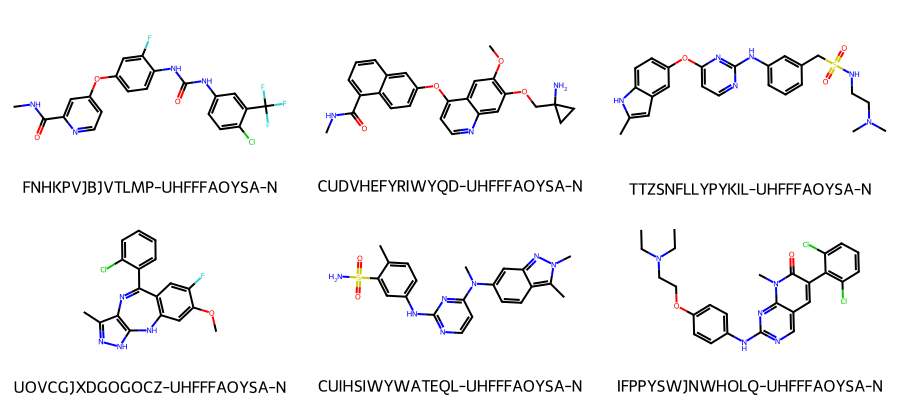

In [41]:
Draw.MolsToGridImage(
    cmpd_df['mol'][:6].tolist(), 
    legends= cmpd_df['inchikey'].tolist(),
    subImgSize=(300, 200), 
    useSVG=True
    )

In [42]:
cmpd_df['mol'] = cmpd_df.smiles.apply(Chem.MolFromSmiles)

In [43]:
cmpd_df['mol'] = cmpd_df.smiles.progress_apply(Chem.MolFromSmiles)

100%|████████████████████████████████████████████████████████████████████████████| 5530/5530 [00:01<00:00, 3033.26it/s]


In [44]:
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors

In [45]:
def mol2morgan_fp(mol, radius=2, nBits=2048):
    """Convert an RDKit molecule to a Morgan fingerprint
    :param mol: RDKit molecule
    :param radius: fingerprint radius
    :param nBits: number of fingerprint bits
    :return: RDKit Morgan fingerprint
    """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return fp

In [46]:
cmpd_df['fp'] = cmpd_df.mol.progress_apply(mol2morgan_fp)

100%|████████████████████████████████████████████████████████████████████████████| 5530/5530 [00:00<00:00, 9040.74it/s]


In [47]:
cmpd_df

inchikey  \
0     FNHKPVJBJVTLMP-UHFFFAOYSA-N   
1     CUDVHEFYRIWYQD-UHFFFAOYSA-N   
2     TTZSNFLLYPYKIL-UHFFFAOYSA-N   
3     UOVCGJXDGOGOCZ-UHFFFAOYSA-N   
4     CUIHSIWYWATEQL-UHFFFAOYSA-N   
...                           ...   
5525  UBAHPEHGSJRHGA-UHFFFAOYSA-N   
5526  RTTIKBHDHKOSNI-UHFFFAOYSA-N   
5527  HVUOSZANYULBJR-UHFFFAOYSA-N   
5528  SNFWCJIVWUVRNO-UHFFFAOYSA-N   
5529  MKSAGABLDNGEAP-DHIUTWEWSA-N   

                                                 smiles  group  activity  \
0     CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...  train    active   
1     CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...  train    active   
2     Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...   test    active   
3          COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2  train    active   
4     Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...   test    active   
...                                                 ...    ...       ...   
5525  Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...   test  inactive   
5526        Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C   test  inactive   
5527  Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...   test  inactive   
5528  N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...   test  inactive   
5529  CCOP(=O)(OCC)[C@@H]1C[C@H](C(=O)Nc2cc3c4c(cccc...   test  inactive   

                                                    mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
1     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
2     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
3     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
4     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
...                                                 ...   
5525  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5526  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5527  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5528  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5529  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   

                                                     fp  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
5525  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5526  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5527  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5528  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5529  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[5530 rows x 6 columns]

In [48]:
cmpd_df['activity'].unique()

array(['active', 'inactive', 'unknown', 'intermediate'], dtype=object)

In [49]:
target = cmpd_df[cmpd_df['activity'].str.contains('unknown')].index

In [50]:
cmpd_df.drop(target,inplace=True)

In [51]:
cmpd_df.activity.unique()

array(['active', 'inactive', 'intermediate'], dtype=object)

In [52]:
target2 = cmpd_df[cmpd_df['activity'].str.contains('intermediate')].index

In [53]:
cmpd_df.drop(target2,inplace=True)

In [54]:
cmpd_df.activity.unique()

array(['active', 'inactive'], dtype=object)

In [55]:
cmpd_df['activity1'] = cmpd_df['activity'].map({'active': 1, 'inactive': 0})

In [56]:
cmpd_df

inchikey  \
0     FNHKPVJBJVTLMP-UHFFFAOYSA-N   
1     CUDVHEFYRIWYQD-UHFFFAOYSA-N   
2     TTZSNFLLYPYKIL-UHFFFAOYSA-N   
3     UOVCGJXDGOGOCZ-UHFFFAOYSA-N   
4     CUIHSIWYWATEQL-UHFFFAOYSA-N   
...                           ...   
5525  UBAHPEHGSJRHGA-UHFFFAOYSA-N   
5526  RTTIKBHDHKOSNI-UHFFFAOYSA-N   
5527  HVUOSZANYULBJR-UHFFFAOYSA-N   
5528  SNFWCJIVWUVRNO-UHFFFAOYSA-N   
5529  MKSAGABLDNGEAP-DHIUTWEWSA-N   

                                                 smiles  group  activity  \
0     CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...  train    active   
1     CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...  train    active   
2     Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...   test    active   
3          COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2  train    active   
4     Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...   test    active   
...                                                 ...    ...       ...   
5525  Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...   test  inactive   
5526        Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C   test  inactive   
5527  Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...   test  inactive   
5528  N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...   test  inactive   
5529  CCOP(=O)(OCC)[C@@H]1C[C@H](C(=O)Nc2cc3c4c(cccc...   test  inactive   

                                                    mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
1     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
2     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
3     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
4     <rdkit.Chem.rdchem.Mol object at 0x0000027CA0C...   
...                                                 ...   
5525  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5526  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5527  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5528  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   
5529  <rdkit.Chem.rdchem.Mol object at 0x0000027CA0B...   

                                                     fp  activity1  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          1  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...          1  
2     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          1  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          1  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          1  
...                                                 ...        ...  
5525  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0  
5526  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0  
5527  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0  
5528  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0  
5529  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0  

[4590 rows x 7 columns]

# Bionsite's baseline model 

There are 5530 compound samples with:
* SMILES - 2D compound structure,
* InChIKey - a hash from InChI,
* group - a tag to split the dataset into train and test
* activity - y label

In [57]:
# with minimal modification, we obtain the fingerprint vector using RDKit

def get_Xy(df):
    X = np.vstack(df.mol.apply(lambda m: list(AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits=2048))))
    y = df.activity.eq('active').astype(float).to_numpy()
    return X, y

In [58]:
X_train, y_train = get_Xy(cmpd_df[cmpd_df.group.eq('train')])
X_test, y_test = get_Xy(cmpd_df[cmpd_df.group.eq('test')])

# Model: Random Forest

Probably, RF is the simplest classifier for numerical feature vectors without much tuning, and that gives us a start point of our model exploration.

In [59]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8056975894813733

In [60]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [61]:
# logloss
metrics.log_loss(y_test, y_pred, labels=[0, 1])

0.4755061803382243

In [62]:
# AUC PRC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred, pos_label=1)
metrics.auc(recall, precision)

0.9135941522363275

In [63]:
# AUC ROC
fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr_roc, tpr_roc)

0.9128515174416292

In [64]:
pred = clf.predict(X_test)
auc, mcc, kappa = roc_auc_score(y_test, pred),matthews_corrcoef(y_test,pred),cohen_kappa_score(y_test,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.82
Matthews Correlation Coefficient = 0.63
Cohen's Kappa = 0.61


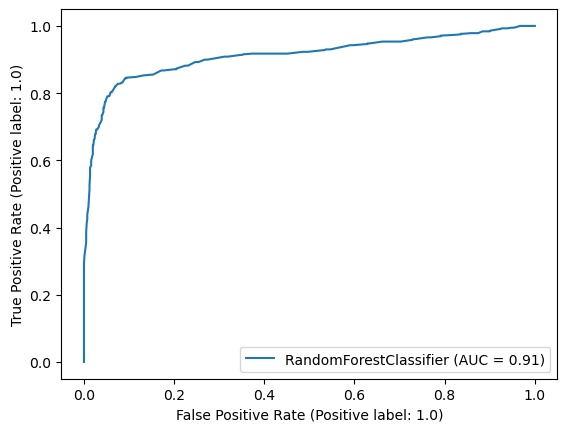

In [36]:
plot_roc_curve(clf,X_test,y_test)

# Hyperparameter Tuning


I will use a random forest classifier and will use hyperparameter tuning using grid search to find the best hyperparamters for the random forest. Below is a summary of the parameters that we will use in the search.

Hyperparameter	Value Range
Maximum Depth per tree	[1, 5, 11, 21, None]	
Split Evaluation function	[Entropy, Gini Impurity]	
Minimum Sample Split	[2, 5, 10]	
We will split the training data into K folds, and for each combination of the hyperparameters, the model is trained on K-1 folds of the data and evaluated on a holdout set for all possible sections of the holdout set, and the model score is the average value across the K folds.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
import time

In [73]:
t0 = time.perf_counter()
estimator = RandomForestClassifier() #criterion = 'gini' #max_depth=None
params = {
                 'n_estimators': [300],
                 'criterion': ['gini', 'entropy'], 
                 'max_depth': [1, 5, 11, 21, None],
                 'min_samples_split': [2, 5, 10],
        }
clf = GridSearchCV(estimator, 
                   param_grid=params, 
                   scoring=make_scorer(roc_auc_score,needs_proba=True),
                   cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2), 
                   verbose=True,
                   n_jobs=8,
                   refit=True
                  )
search_stratified = clf.fit(X_train, y_train)
print("Training time : {0:.2f} s.".format(time.perf_counter()-t0))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training time : 235.32 s.


In [72]:
search_stratified.cv_results_

{'mean_fit_time': array([ 2.07126088,  2.12810845,  2.44226685,  5.53160396,  6.56623745,
         6.63725867, 10.68772974, 11.07709942, 10.05233369, 14.17521362,
        13.85906281, 12.47107558, 17.60942802, 17.5214468 , 15.31164389,
         2.01700516,  1.80417342,  1.94001179,  5.42907901,  5.53200517,
         5.641609  ,  9.24367523,  8.63669858, 10.08721776, 11.02291675,
        12.82609353, 10.90582938, 14.60014772, 11.71286983,  9.87522812]),
 'std_fit_time': array([0.50718165, 0.52395644, 0.59358763, 1.23228266, 1.23005176,
        0.73719011, 2.31547148, 1.70160883, 0.8139137 , 2.96278346,
        1.3526519 , 0.78614474, 1.64341314, 2.18647292, 2.27872192,
        0.38519288, 0.31216851, 0.4165345 , 1.16558241, 1.17025235,
        0.98561053, 1.65390535, 1.64723224, 1.99500727, 2.03170593,
        1.92333941, 1.75560118, 2.80649549, 1.83059313, 1.27233863]),
 'mean_score_time': array([0.09674282, 0.11808414, 0.10412245, 0.12626166, 0.13404002,
        0.14581056, 0.20983858

In [69]:
search_stratified.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=300)

In [41]:
clf = RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=300)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.829072315558802

In [42]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [43]:
# logloss
metrics.log_loss(y_test, y_pred, labels=[0, 1])

0.46390102952355194

In [44]:
# AUC PRC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred, pos_label=1)
metrics.auc(recall, precision)

0.9202876489642148

In [45]:
# AUC ROC
fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr_roc, tpr_roc)

0.919382460699433

In [46]:
pred = clf.predict(X_test)
auc, mcc, kappa = roc_auc_score(y_test, pred),matthews_corrcoef(y_test,pred),cohen_kappa_score(y_test,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.84
Matthews Correlation Coefficient = 0.67
Cohen's Kappa = 0.66


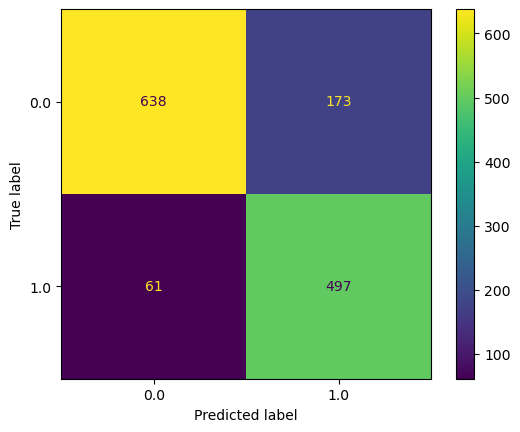

In [47]:
plot_confusion_matrix(clf,X_test,y_test)

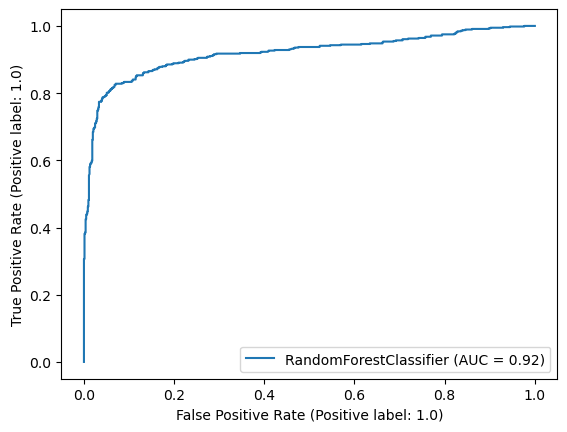

In [48]:
plot_roc_curve(clf,X_test,y_test)

# Model: DecisionTreeClassifier

In [49]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.706355003652301

In [50]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [51]:
# logloss
metrics.log_loss(y_test, y_pred, labels=[0, 1])

0.6781083997338307

In [52]:
# AUC PRC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred, pos_label=1)
metrics.auc(recall, precision)

0.6805852151396661

In [53]:
# AUC ROC
fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr_roc, tpr_roc)

0.7015720226809682

In [54]:
pred = clf.predict(X_test)
auc, mcc, kappa = roc_auc_score(y_test, pred),matthews_corrcoef(y_test,pred),cohen_kappa_score(y_test,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.69
Matthews Correlation Coefficient = 0.39
Cohen's Kappa = 0.39


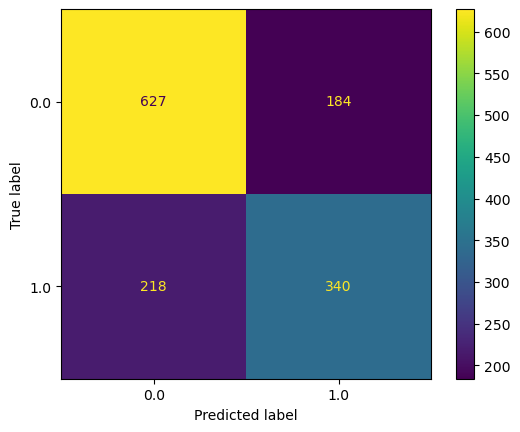

In [55]:
plot_confusion_matrix(clf,X_test,y_test)

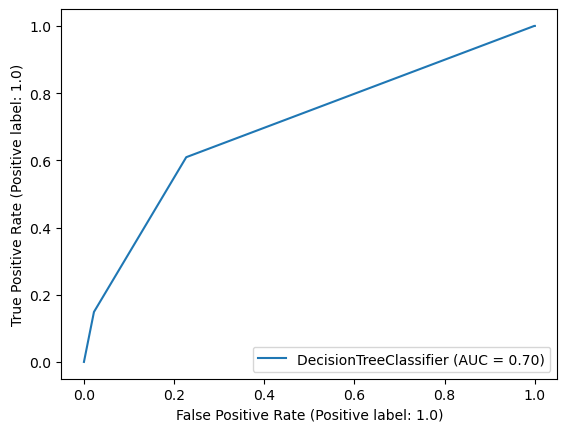

In [56]:
plot_roc_curve(clf,X_test,y_test)

 # Model: XGBClassifier

In [59]:
clf = XGBClassifier(objective="binary:logistic", random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7903579254930606

In [60]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [61]:
# logloss
metrics.log_loss(y_test, y_pred, labels=[0, 1])

0.45440190559588683

In [62]:
# AUC PRC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred, pos_label=1)
metrics.auc(recall, precision)

0.8964666839674955

In [63]:
# AUC ROC
fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr_roc, tpr_roc)

0.8975644034313142

In [64]:
pred = clf.predict(X_test)
auc, mcc, kappa = roc_auc_score(y_test, pred),matthews_corrcoef(y_test,pred),cohen_kappa_score(y_test,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.80
Matthews Correlation Coefficient = 0.59
Cohen's Kappa = 0.58


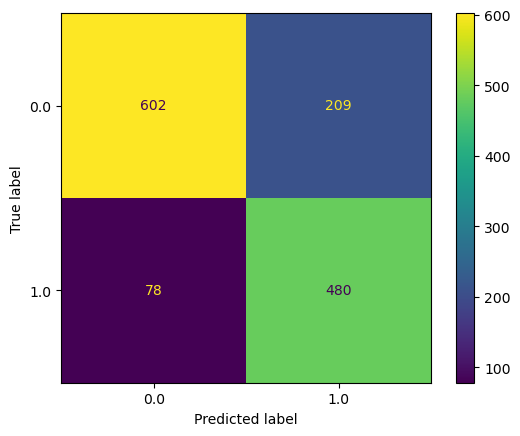

In [65]:
plot_confusion_matrix(clf,X_test,y_test)

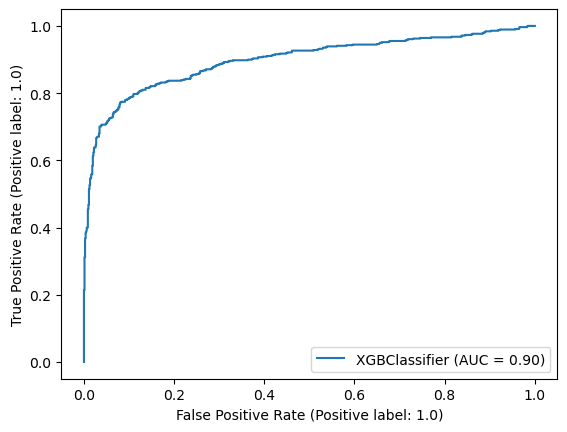

In [66]:
plot_roc_curve(clf,X_test,y_test)

# Model: LGBMClassifier

In [67]:
clf = LGBMClassifier(n_estimators=10000,n_jobs=-1,num_leaves=64, boost_from_average=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8466033601168736

In [68]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [69]:
# logloss
metrics.log_loss(y_test, y_pred, labels=[0, 1])

0.7793035478734874

In [70]:
# AUC PRC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred, pos_label=1)
metrics.auc(recall, precision)

0.915817595221723

In [71]:
# AUC ROC
fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr_roc, tpr_roc)

0.9234793542199771

In [72]:
pred = clf.predict(X_test)
auc, mcc, kappa = roc_auc_score(y_test, pred),matthews_corrcoef(y_test,pred),cohen_kappa_score(y_test,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.85
Matthews Correlation Coefficient = 0.69
Cohen's Kappa = 0.69


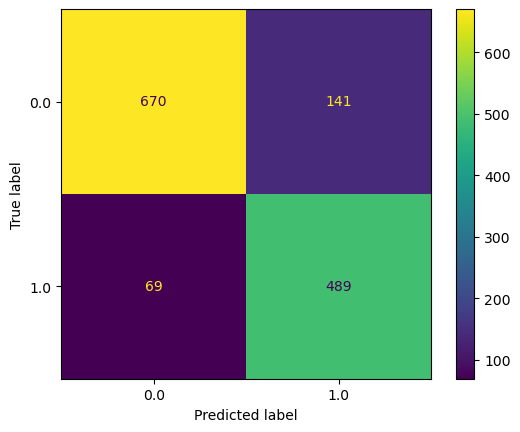

In [73]:
plot_confusion_matrix(clf,X_test,y_test)

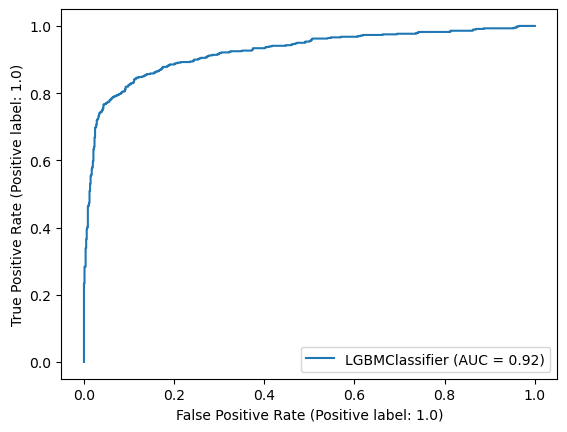

In [74]:
plot_roc_curve(clf,X_test,y_test)

#  comparing classification models

In [257]:
!pip install pandas seaborn numpy sklearn xgboost lightgbm rdkit_pypy useful_rdkit_utils scipy mlxtend scikit_posthocs 

ERROR: Could not find a version that satisfies the requirement rdkit_pypy (from versions: none)
ERROR: No matching distribution found for rdkit_pypy


In [48]:
!pip install xgboost

In [49]:
!pip install lightgbm

In [50]:
!pip install mlxtend

In [51]:
!pip install scikit_posthocs

In [58]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from rdkit import Chem
from mlxtend.evaluate import cochrans_q, mcnemar, mcnemar_table
from tqdm.notebook import tqdm
from itertools import combinations
#from delong_ci import calc_auc_ci
from scipy.stats import wilcoxon
from mlxtend.evaluate import paired_ttest_5x2cv
#from bootstrap import bootstrap_error_estimate
from scipy import stats
import scikit_posthocs as sp

from tqdm.auto import tqdm

In [76]:
method_list = [ XGBClassifier, RandomForestClassifier, LGBMClassifier]
method_name_list = [x().__class__.__name__ for x in method_list]
method_name_list = [x.replace("Classifier","") for x in method_name_list]
truth_list = []
pred_list = []
prob_list = []
cv_cycles = 10
for i in tqdm(range(0,cv_cycles)):
    train, test = train_test_split(cmpd_df)
    train_X = np.stack(train.fp)
    train_y = train.activity1.values
    test_X = np.stack(test.fp)
    test_y = test.activity1.values
    cycle_pred = []
    cycle_prob = []
    for method in method_list:
        clf = method(n_jobs=-1)
        clf.fit(train_X,train_y)
        cycle_pred.append(clf.predict(test_X))
        cycle_prob.append(clf.predict_proba(test_X))
        
    truth_list.append(test.activity1.values)        
    pred_list.append(cycle_pred)
    prob_list.append(cycle_prob)

  0%|          | 0/10 [00:00<?, ?it/s]

In [223]:
auc_result = []
for truth, prob in zip(truth_list,prob_list):
    for name, p in zip(method_name_list, prob):
        auc_result.append([name,roc_auc_score(truth,p[:,1])])
auc_df = pd.DataFrame(auc_result,columns=["Method","AUC"])

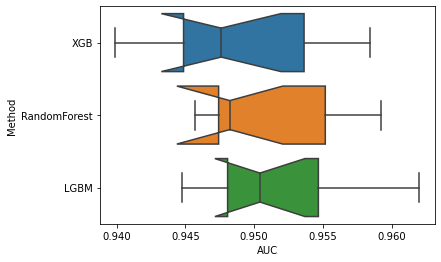

In [224]:
ax = sns.boxplot(y="Method",x="AUC",data=auc_df,notch=True)

In [261]:
auc_result = []
for cycle, [truth, prob] in enumerate(zip(truth_list,prob_list)):
    for name, p in zip(method_name_list, prob):
        truth = np.array([int(x) for x in truth])
        auc, (lb, ub) = calc_auc_ci(truth,p[:,1])
        auc_result.append([cycle,name, auc, lb, ub])
auc_ci_df = pd.DataFrame(auc_result,columns=["Cycle","Method","AUC","LB","UB"])
auc_ci_df.head()

Cycle        Method       AUC        LB        UB
0      0           XGB  0.944522  0.932074  0.956969
1      0  RandomForest  0.944011  0.931275  0.956748
2      0          LGBM  0.947893  0.935989  0.959796
3      1           XGB  0.950102  0.938237  0.961967
4      1  RandomForest  0.954499  0.943266  0.965732

In [262]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('white')

In [263]:
def ci_pointplot(input_df, x_col="Cycle", y_col="AUC", hue_col="Method", lb_col="LB", ub_col="UB"):
    dodge_val = 0.25
    palette_name = "deep"
    cv_cycles = len(input_df[x_col].unique())
    ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palettte=palette_name)
    ax.axvline(0.5, ls="--", c="gray")
    for x in np.arange(0.5, cv_cycles, 1):
        ax.axvline(x, ls="--", c="gray")
    y_val = input_df[y_col]
    lb = y_val - input_df[lb_col]
    ub = input_df[ub_col] - y_val
    x_pos = []
    cols = sns.color_palette(palette_name)[:3]
    for i in range(0, cv_cycles):
        x_pos += [i - dodge_val / 2, i, i + dodge_val / 2]
    _ = ax.errorbar(x_pos, y_val, yerr=[lb, ub], fmt="none", capsize=0,ecolor=cols)

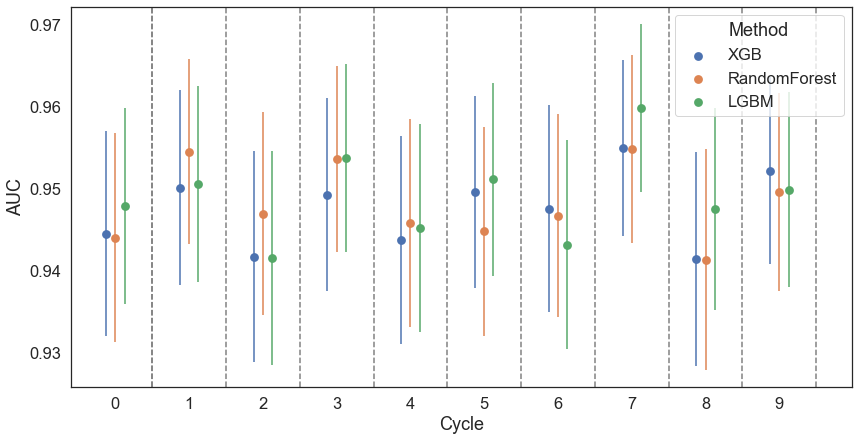

In [264]:
ci_pointplot(auc_ci_df)

In [268]:
from sklearn.utils import resample

In [269]:

def bootstrap_error_estimate(pred, truth, method, method_name="", alpha=0.95, sample_frac=0.5, iterations=1000):
    """
    Generate a bootstrapped estimate of confidence intervals
    :param pred: list of predicted values
    :param truth: list of experimental values
    :param method: method to evaluate performance, e.g. matthews_corrcoef
    :param method_name: name of the method for the progress bar
    :param alpha: confidence limit (e.g. 0.95 for 95% confidence interval)
    :param sample_frac: fraction to resample for bootstrap confidence interval
    :param iterations: number of iterations for resampling
    :return: lower and upper bounds for confidence intervals
    """
    index_list = range(0, len(pred))
    num_samples = int(len(index_list) * sample_frac)
    stats = []
    for _ in range(0, iterations):
        sample_idx = resample(index_list, n_samples=num_samples)
        pred_sample = [pred[x] for x in sample_idx]
        truth_sample = [truth[x] for x in sample_idx]
        stats.append(method(pred_sample, truth_sample))
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    return lower, upper


In [270]:
bootstrap_result = []
with tqdm(total=len(truth_list)) as pbar:
    for cycle,[truth,probs] in enumerate(zip(truth_list,prob_list)):
        for name,p in zip(method_name_list,probs):
            auc = roc_auc_score(truth,p[:,1])
            lb,ub = bootstrap_error_estimate(truth,p[:,1],roc_auc_score)
            bootstrap_result.append([cycle,name,auc,lb,ub])
        pbar.update(1)
bootstrap_df = pd.DataFrame(bootstrap_result,columns=["Cycle","Method","AUC","LB","UB"])

  0%|          | 0/10 [00:00<?, ?it/s]

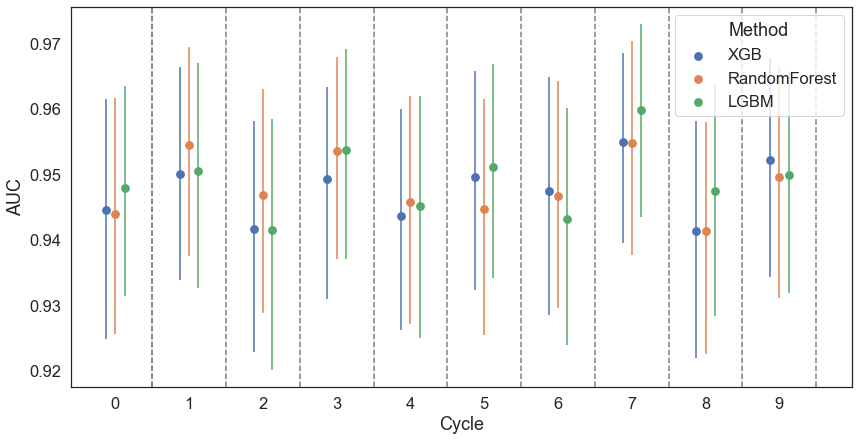

In [271]:
ci_pointplot(bootstrap_df)

In [273]:
X = np.stack(cmpd_df.fp)
y = cmpd_df.activity1.values
classifier_list = [x(n_jobs=-1) for x in method_list]
print(f"{'Method_1':12s} {'Method_2':12s} {'p-value'}")
for a,b in combinations(zip(classifier_list,method_name_list),2):
    clf1,name1 = a
    clf2,name2 = b
    t, p = paired_ttest_5x2cv(estimator1=clf1,estimator2=clf2,X=X, y=y, scoring="roc_auc")
    print(f"{name1:12s} {name2:12s} {p:.3f}")

Method_1     Method_2     p-value
XGB          RandomForest 0.470
XGB          LGBM         0.451
RandomForest LGBM         0.794


In [274]:
mc_result = []
for truth, pred in zip(truth_list,pred_list): 
    for i,j in combinations(range(len(method_list)),2):
        mc, mc_pvalue = mcnemar(mcnemar_table(truth, pred[i], pred[j]))
        mc_result.append([method_name_list[i],method_name_list[j], mc_pvalue])
mc_df = pd.DataFrame(mc_result,columns=["Method_1","Method_2","p_value"])
mc_df['Combo'] = mc_df.Method_1 + "_" + mc_df.Method_2
mc_df.head()

Method_1      Method_2   p_value              Combo
0           XGB  RandomForest  0.531971   XGB_RandomForest
1           XGB          LGBM  1.000000           XGB_LGBM
2  RandomForest          LGBM  0.596242  RandomForest_LGBM
3           XGB  RandomForest  0.027195   XGB_RandomForest
4           XGB          LGBM  0.348737           XGB_LGBM

In [275]:
alpha = 0.05/len(pred_list[0])
alpha

0.016666666666666666

In [276]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

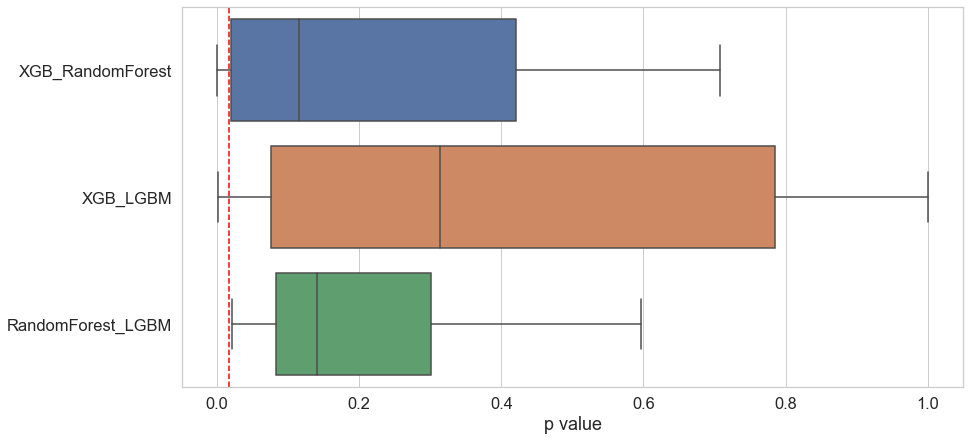

In [277]:
ax = sns.boxplot(x="p_value",y="Combo",data=mc_df)
ax.set(ylabel="",xlabel="p value")
_ = ax.axvline(alpha,c="red",ls="--")

In [278]:
auc_dict = {}
for k,v in auc_ci_df.groupby("Method"):
    auc_dict[k] = v.AUC
stats.friedmanchisquare(*auc_dict.values())

FriedmanchisquareResult(statistic=1.4000000000000057, pvalue=0.496585303791408)

# Hints
Although AUCPRC and AUCROC are already quite high, one may suspect possible overfitting since the dimension of features is 2048, and the number of train samples is 3977. Indeed, it is the case, but a simple regularization with some hyperparam tuning of the RF and/or the Morgan fingerprint does not improve the result significantly. Note that some graph-based deep learning models with minimal tuning easily get you have both AUCPRC and AUCROC > 0.93, and logloss < 0.35.

Also, remember that you may freely use other open resources. For example, there are many many compound samples in PubChem, ChEMBL, ChEBI, ..., and most compounds there are not likely "active".